<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, Lasso
from sklearn.linear_model import RidgeCV, Ridge
from sklearn import metrics
from sklearn.model_selection import train_test_split
import scipy.stats
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier,BaggingRegressor,RandomForestRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
#https://www.youtube.com/watch?v=0GrciaGYzV0

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
#http://localhost:8888/notebooks/Desktop/Unit-3-Restructured/03_Optimization/dsi-unit-3.25-optimization-gridsearch_hyperparameters-lesson/solution-code/introduction-to-gridsearching-hyperparameters-solutions.ipynb
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('housing.csv')
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [3]:
# Function to check data description as we have a lot of columns (81)
def data_description():
    with open('data_description.txt','r') as f:
        for line in f:
            print(line)
data_description()

MSSubClass: Identifies the type of dwelling involved in the sale.	



        20	1-STORY 1946 & NEWER ALL STYLES

        30	1-STORY 1945 & OLDER

        40	1-STORY W/FINISHED ATTIC ALL AGES

        45	1-1/2 STORY - UNFINISHED ALL AGES

        50	1-1/2 STORY FINISHED ALL AGES

        60	2-STORY 1946 & NEWER

        70	2-STORY 1945 & OLDER

        75	2-1/2 STORY ALL AGES

        80	SPLIT OR MULTI-LEVEL

        85	SPLIT FOYER

        90	DUPLEX - ALL STYLES AND AGES

       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER

       150	1-1/2 STORY PUD - ALL AGES

       160	2-STORY PUD - 1946 & NEWER

       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER

       190	2 FAMILY CONVERSION - ALL STYLES AND AGES



MSZoning: Identifies the general zoning classification of the sale.

		

       A	Agriculture

       C	Commercial

       FV	Floating Village Residential

       I	Industrial

       RH	Residential High Density

       RL	Residential Low Density

       RP	Residential 

### 1 cleaning data

In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
display (house.dtypes)
display (house.shape)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


(1460, 81)

## Notes:
    1460 entries and 81 columns
    A lot of null value columns
    A mixture of categorical and continuous data

## Notes:

<b>Lot Frontage </b>  = Linear feet of street connected to property.<br>
<b>Alley        </b>  = Type of alley access to property (NA for No Alley access).<br>
<b>MasVnrType   </b>  = Masonry veneer type (None for None).<br>
<b>MasVnrArea   </b>  = Masonry veneer area in square feet<br>
<b>BsmtQual     </b>  = Evaluates the height of the basement (NA for No Basement)<br>
<b>BsmtCond     </b>  = Evaluates the general condition of the basement (NA for No Basement)<br>
<b>BsmtExposure </b>  = Refers to walkout or garden level walls (NA for No Basement)<br>
<b>BsmtFinType1 </b>  = Rating of basement finished area (NA for No Basement)<br>
<b>BsmtFinType2 </b>  = Rating of basement finished area (if multiple types)(NA for No Basement)<br>
<b>Electrical   </b>  = Electrical system<br>
<b>FireplaceQu  </b>  = Fireplace quality (NA for No Fireplace)<br>
<b>GarageType   </b>  = Garage location (NA for No Garage)<br>
<b>GarageYrBlt  </b>  = Year garage was built<br>
<b>GarageFinish </b>  = Interior finish of the garage (NA for No Garage)<br>
<b>GarageQual   </b>  = Garage quality (NA for No Garage)<br>
<b>GarageCond   </b>  = Garage condition (NA for No Garage)<br>
<b>PoolQC       </b>  = Pool quality (NA for No Pool)<br>
<b>Fence        </b>  = Fence quality (NA for No Fence)<br>
<b>MiscFeature  </b>  = Miscellaneous feature not covered in other categories (NA for None)<br>

In [6]:
#Check for columns with null values
null_list = list(house.isnull().sum().sort_values(ascending= False).head(19).index)
house.isnull().sum().sort_values(ascending= False).head(22)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
YearRemodAdd       0
MSSubClass         0
dtype: int64

## FIXING NULLS

In [7]:
# For lot frontage to be 0, Street type should also be None, which is highly unlikely.
## So, let check on it
house.Street.value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [8]:
## Looks like our basic assumption is true. Now, lets check the lot 
## frontages with null values
house[['Street','LotFrontage']][house.LotFrontage.isnull()].drop_duplicates()

## Since the NaN values come from both Pavement and Gravel, we will
## take the median of the LotFrontages and replace all NaN with it.

house.LotFrontage=house.LotFrontage.fillna(house.LotFrontage.median())
house.LotFrontage.isnull().sum()

0

In [9]:
house.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [10]:
house.Electrical=house.Electrical.fillna('SBrkr')

In [11]:
house[['Fireplaces','FireplaceQu']][house.FireplaceQu.isnull()].drop_duplicates()

Fireplaces FireplaceQu
0           0         NaN

In [12]:
house.MasVnrType.unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [13]:
house.MasVnrType=house.Electrical.fillna('None')

## Note
    1 MasVnrType and MasVnrArea can be "None" and O so we will 
      replace it likewise.
    2 Maximum electical are SBrkr (Standard Circuit Breakers & 
      Romex), so replace it with it as we have only 1 null value
    3 Rest all fields can be replaced with NA except for GarageYrBlt 
      which can be replaced by YearBuilt
    4 1369 out of 1460 values are NULL NA is for No alley access. So, 
      we will replace it with NA.

In [14]:
str_cols = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
           'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
           'PoolQC','Fence','MiscFeature']
int_cols = ['MasVnrArea']

In [15]:
for columns in str_cols:
    house[columns].fillna('NA', inplace = True)
    
for columns in int_cols:
    house[columns].fillna(0, inplace = True)

In [16]:
# Check for null values in the Garage Year Built
house[['YearBuilt','YearRemodAdd', 'GarageYrBlt']].head(10)

YearBuilt  YearRemodAdd  GarageYrBlt
0       2003          2003       2003.0
1       1976          1976       1976.0
2       2001          2002       2001.0
3       1915          1970       1998.0
4       2000          2000       2000.0
5       1993          1995       1993.0
6       2004          2005       2004.0
7       1973          1973       1973.0
8       1931          1950       1931.0
9       1939          1950       1939.0

In [17]:
# Since Garage Year Built is similar to Year Built in most of the cases, 
# we will replace the null values by Year built

house.GarageYrBlt.fillna(house.YearBuilt, inplace=True)

In [18]:
# Check if there are any more null values
house.isnull().sum().sum()

0

## Looking at outlier

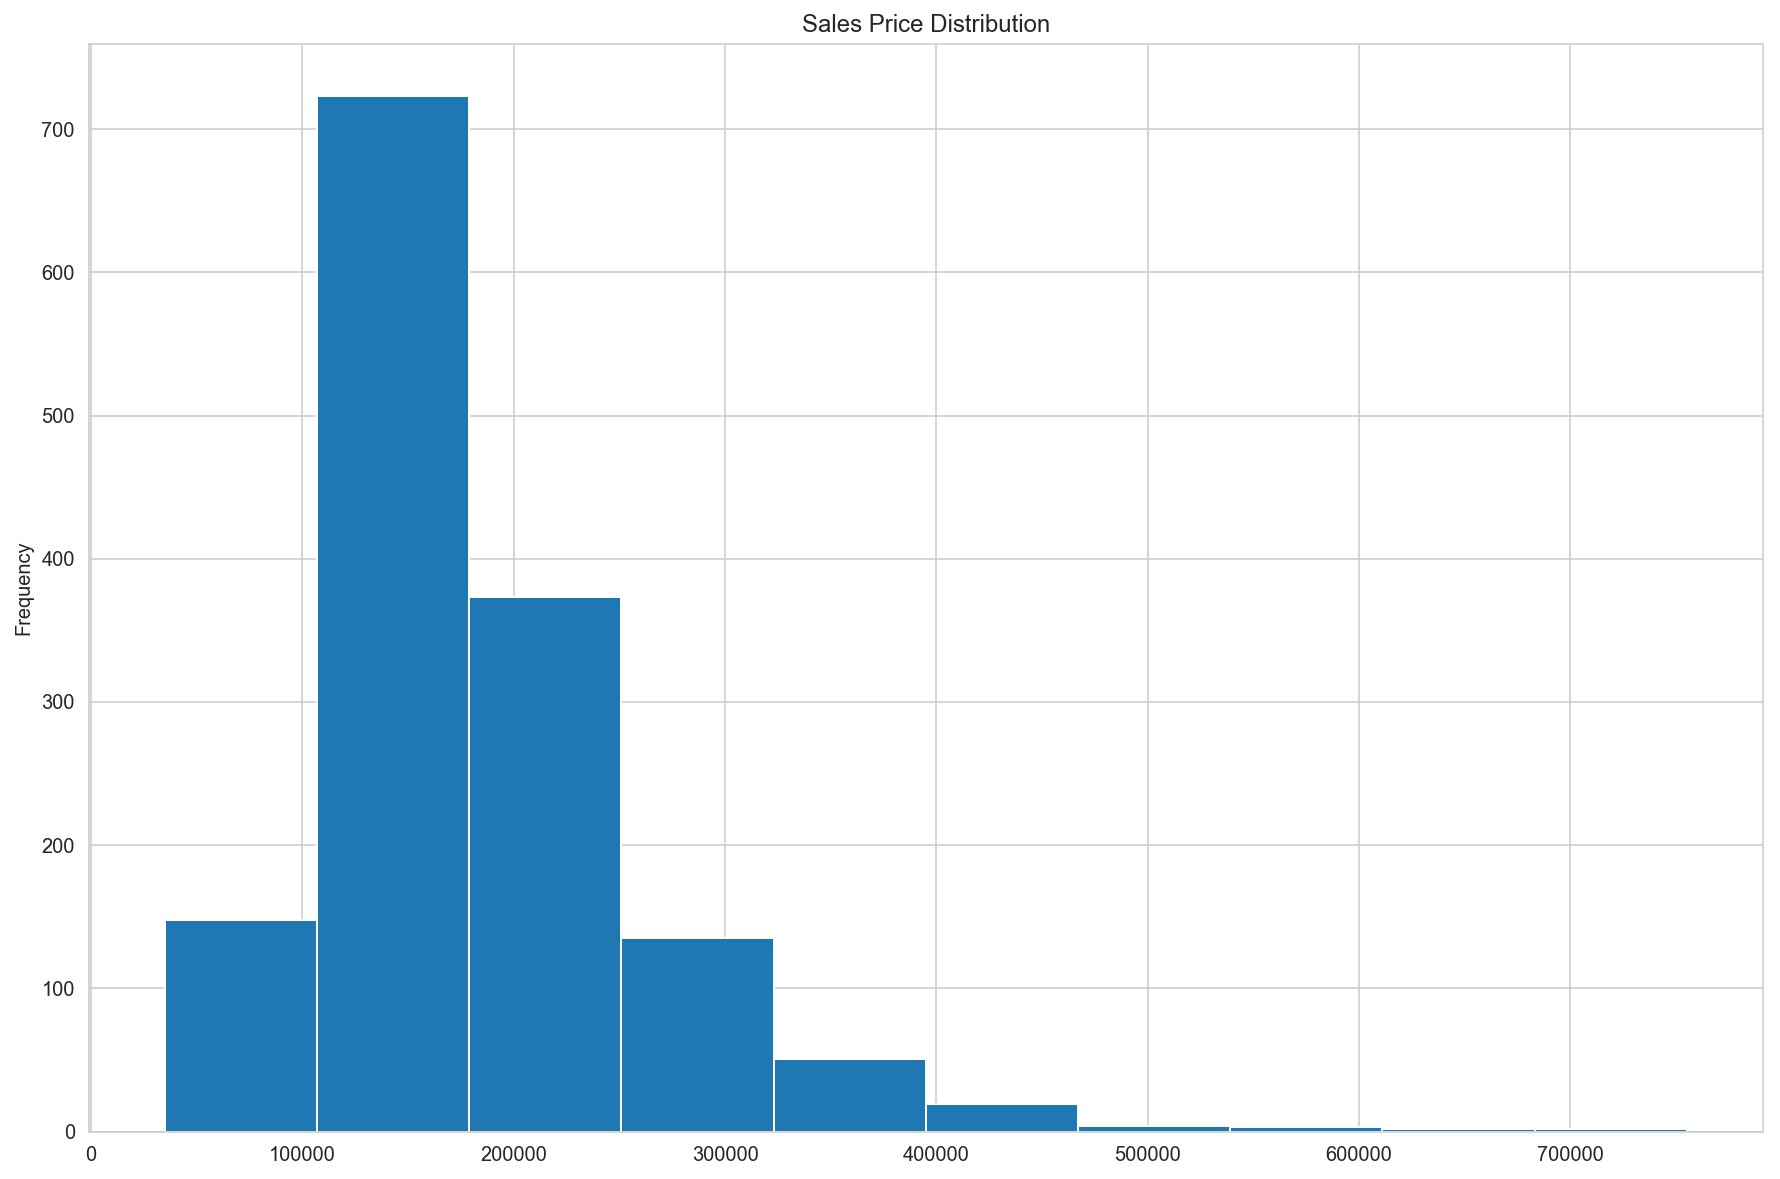

In [19]:
house.SalePrice.plot(kind = 'hist', figsize = (15,10), title='Sales Price Distribution')

In [20]:
house.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

1. Total number of data is 1460. 
2. The mean price of house sold was $180,921

3. The median price in which the houses were sold is $163,000

4. The difference is likely due to the huge different in the minimum selling price (34,900)  and the maximum selling price (755,000) of the house.
5. As projected in the histogram above, there seem to be outlier in the data as the range of selling price is much higher than the interquartile range. 
6. A boxplot would help us visualize the distribution better. 

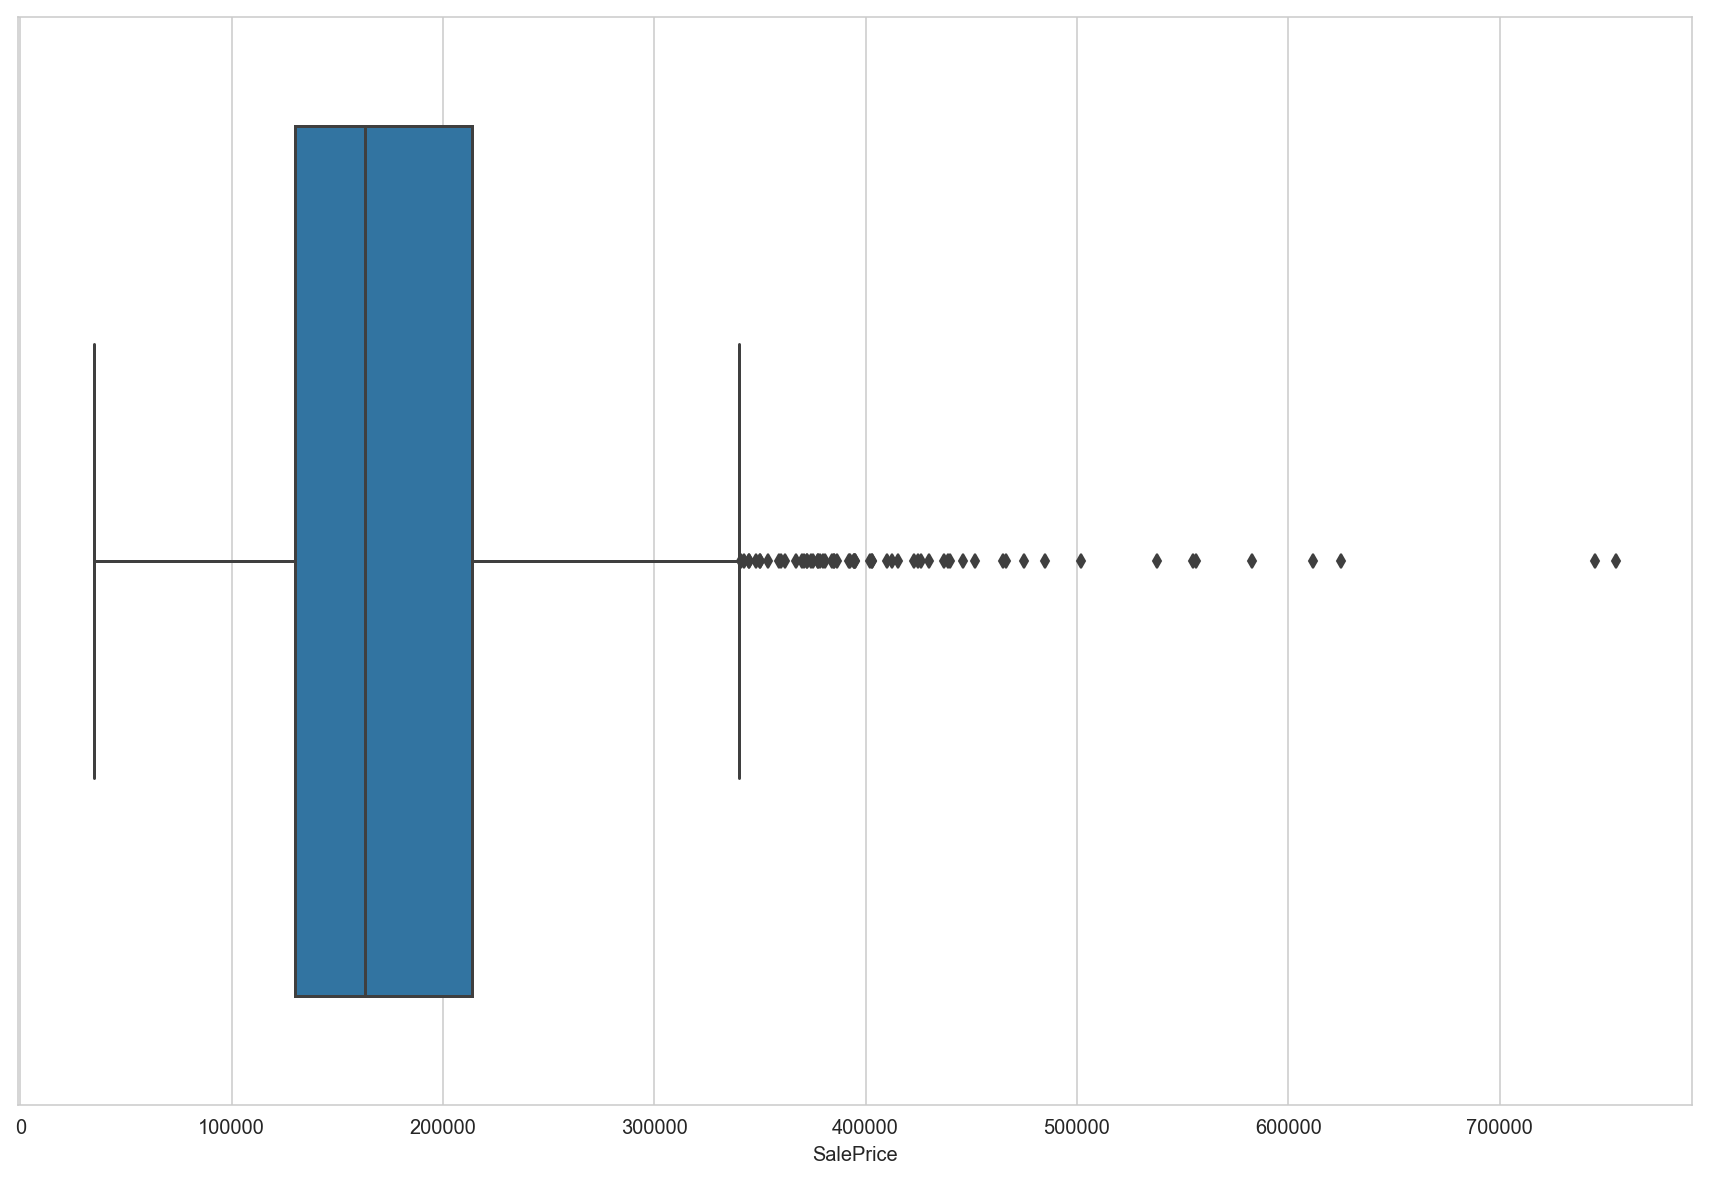

In [21]:
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.boxplot(house.SalePrice)

#A lot of outliers
#Lets check other sales related fields to gain more insight on the price distribution

In [22]:
house.SaleType.value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [23]:
house.SaleCondition.unique()

array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
      dtype=object)

1. High cost sales are contributed by abnormal sales.
2. Low cost in SalePrice is contributed by acquiring Adjoining Land and Family


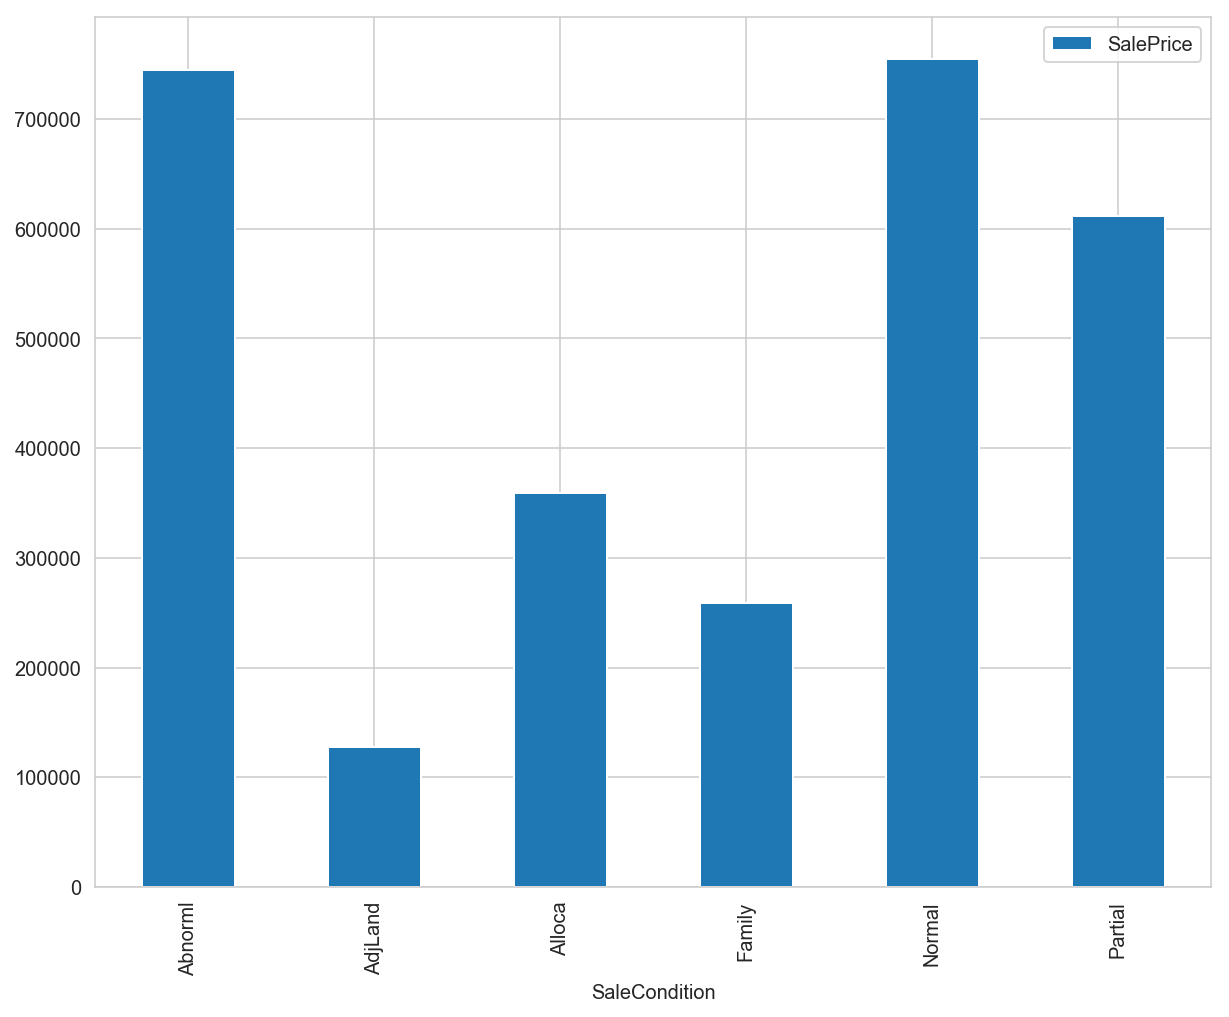

In [24]:
house.groupby('SaleCondition')[['SaleCondition','SalePrice']].max().plot(
    kind='bar', figsize = (10,8))

print ("1. High cost sales are contributed by abnormal sales.")
print ("2. Low cost in SalePrice is contributed by acquiring Adjoining Land and Family")

In [25]:
house[house['SaleCondition'] == 'AdjLand'].T

39       386      418      954
Id                  40      387      419      955
MSSubClass          90       50       50       90
MSZoning            RL       RL       RL       RL
LotFrontage         65       58       60       35
LotArea           6040     8410     8160     9400
Street            Pave     Pave     Pave     Pave
Alley               NA       NA       NA       NA
LotShape           Reg      Reg      Reg      IR1
LandContour        Lvl      Lvl      Lvl      Lvl
Utilities       AllPub   AllPub   AllPub   AllPub
LotConfig       Inside      FR2   Inside  CulDSac
LandSlope          Gtl      Gtl      Gtl      Gtl
Neighborhood   Edwards  Edwards  Edwards  Edwards
Condition1        Norm    Feedr     Norm     Norm
Condition2        Norm     Norm     Norm     Norm
BldgType        Duplex     1Fam     1Fam   Duplex
HouseStyle      1Story   1.5Fin   1.5Fin   SFoyer
OverallQual          4        5        5        6
OverallCond          5        3        6        5
YearBuilt         1955     1910     1940     1975
YearRemodAdd      1955     1996     1950     1975
RoofStyle        Gable  Gambrel    Gable     Flat
RoofMatl       CompShg  CompShg  CompShg  Tar&Grv
Exterior1st    AsbShng  Wd Sdng  MetalSd  WdShing
Exterior2nd    Plywood  VinylSd  MetalSd  Plywood
MasVnrType       FuseP    SBrkr    FuseF    SBrkr
MasVnrArea           0        0        0      250
ExterQual           TA       TA       TA       TA
ExterCond           TA       Fa       TA       TA
Foundation       PConc    PConc   BrkTil   CBlock
...                ...      ...      ...      ...
BedroomAbvGr         2        5        3        4
KitchenAbvGr         2        1        1        0
KitchenQual         Fa       TA       TA       TA
TotRmsAbvGrd         6        8        7        4
Functional         Typ      Typ      Typ      Typ
Fireplaces           0        0        0        0
FireplaceQu         NA       NA       NA       NA
GarageType          NA       NA   Detchd       NA
GarageYrBlt       1955     1910     1940     1975
GarageFinish        NA       NA      Unf       NA
GarageCars           0        0        1        0
GarageArea           0        0      240        0
GarageQual          NA       NA       TA       NA
GarageCond          NA       NA       TA       NA
PavedDrive           N        N        P        Y
WoodDeckSF           0        0        0        0
OpenPorchSF          0      151        0        0
EnclosedPorch        0        0        0        0
3SsnPorch            0        0        0        0
ScreenPorch          0        0        0        0
PoolArea             0        0        0        0
PoolQC              NA       NA       NA       NA
Fence               NA       NA       NA       NA
MiscFeature         NA       NA       NA       NA
MiscVal              0        0        0        0
MoSold               6        5        4       10
YrSold            2008     2006     2007     2006
SaleType            WD       WD       WD       WD
SaleCondition  AdjLand  AdjLand  AdjLand  AdjLand
SalePrice        82000    81000   126000   127500

[81 rows x 4 columns]

In [26]:
house[['SalePrice','BedroomAbvGr']][house['SaleCondition'] == 'Family'].head(10)

SalePrice  BedroomAbvGr
137     171000             5
154     125000             4
217     107000             3
251     235000             2
299     158500             3
454     188000             4
628     135000             5
632      82500             3
655      88000             3
734     108000             3

In [27]:
house[['SalePrice','BedroomAbvGr']][house['SaleCondition'] != 'Family'].head(10)

SalePrice  BedroomAbvGr
0     208500             3
1     181500             3
2     223500             3
3     140000             3
4     250000             4
5     143000             1
6     307000             3
7     200000             3
8     129900             2
9     118000             2

In [28]:
## Let's check other distributions as well
ax.scatter(x = house['GrLivArea'], y = house['SalePrice'])

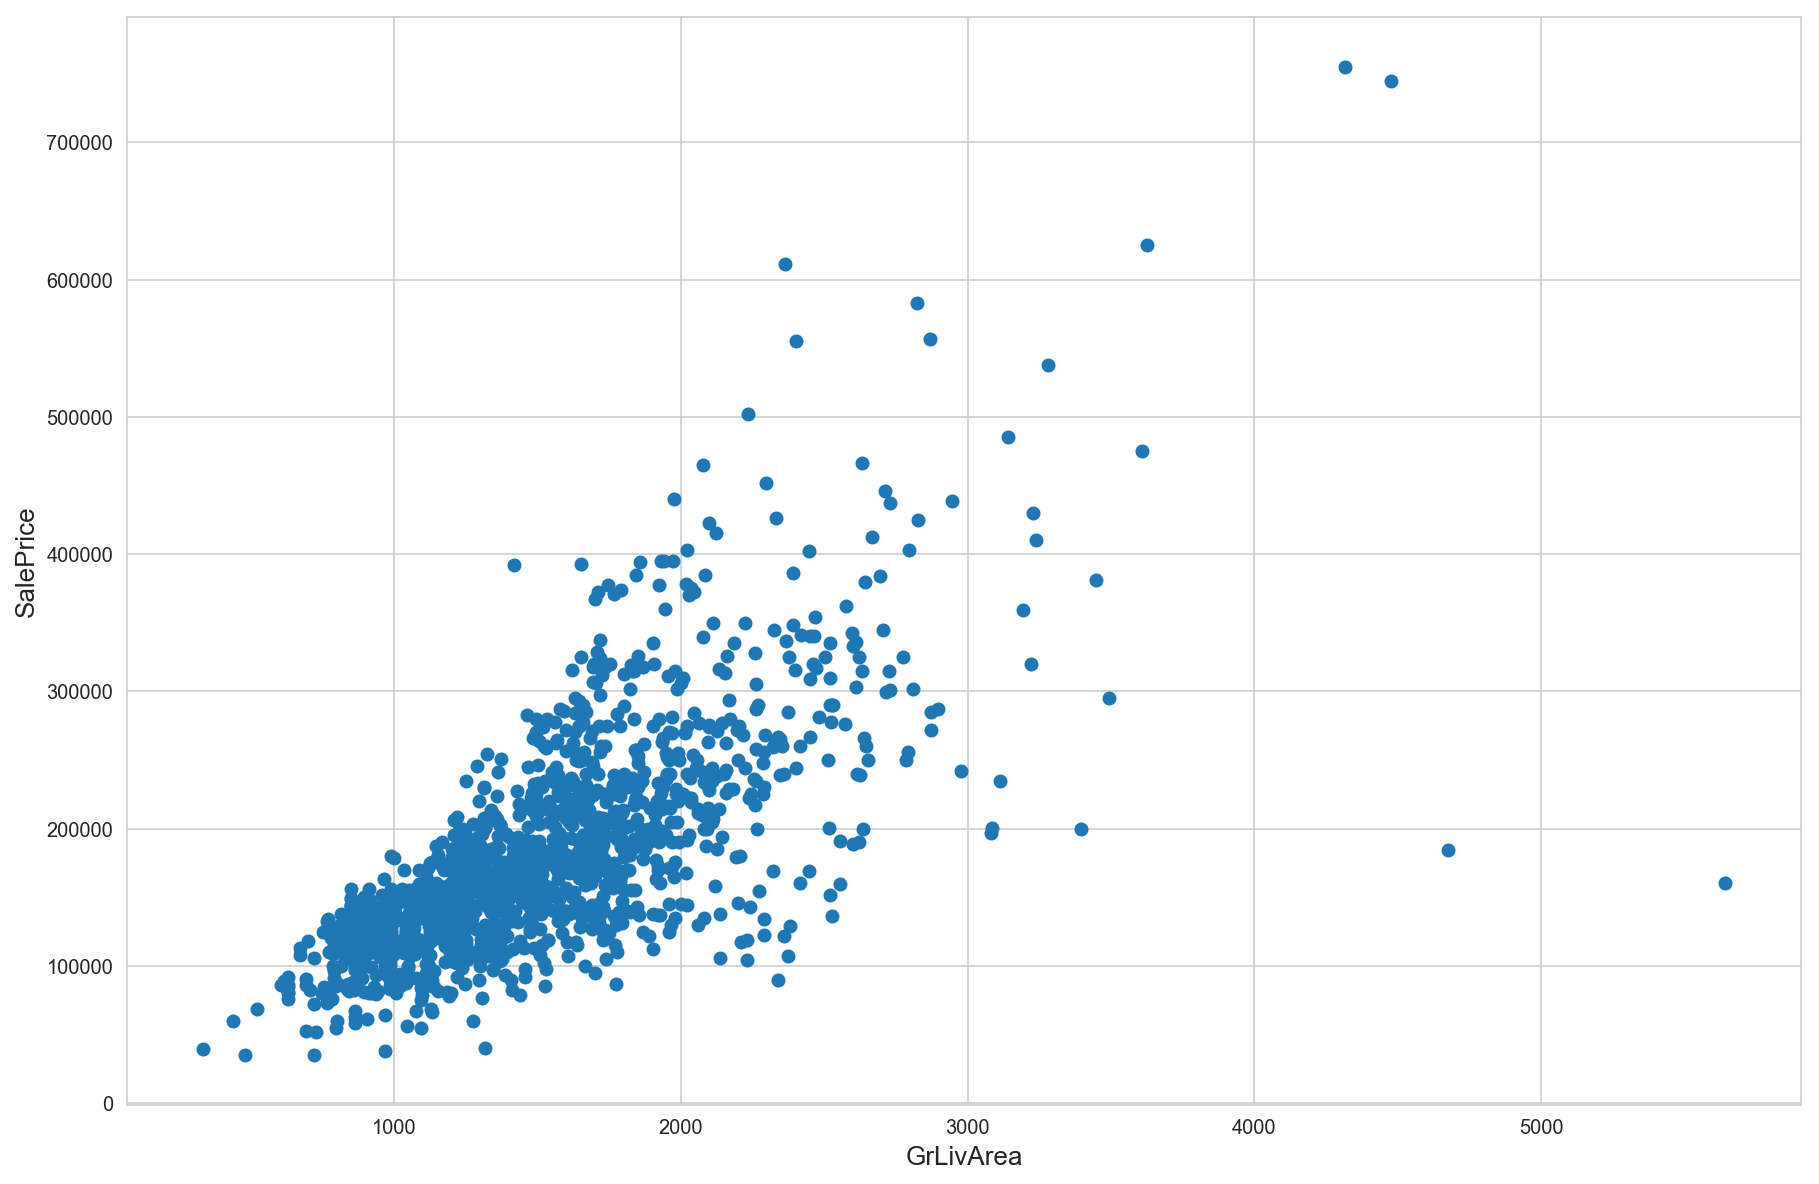

In [29]:
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(x = house['GrLivArea'], y = house['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

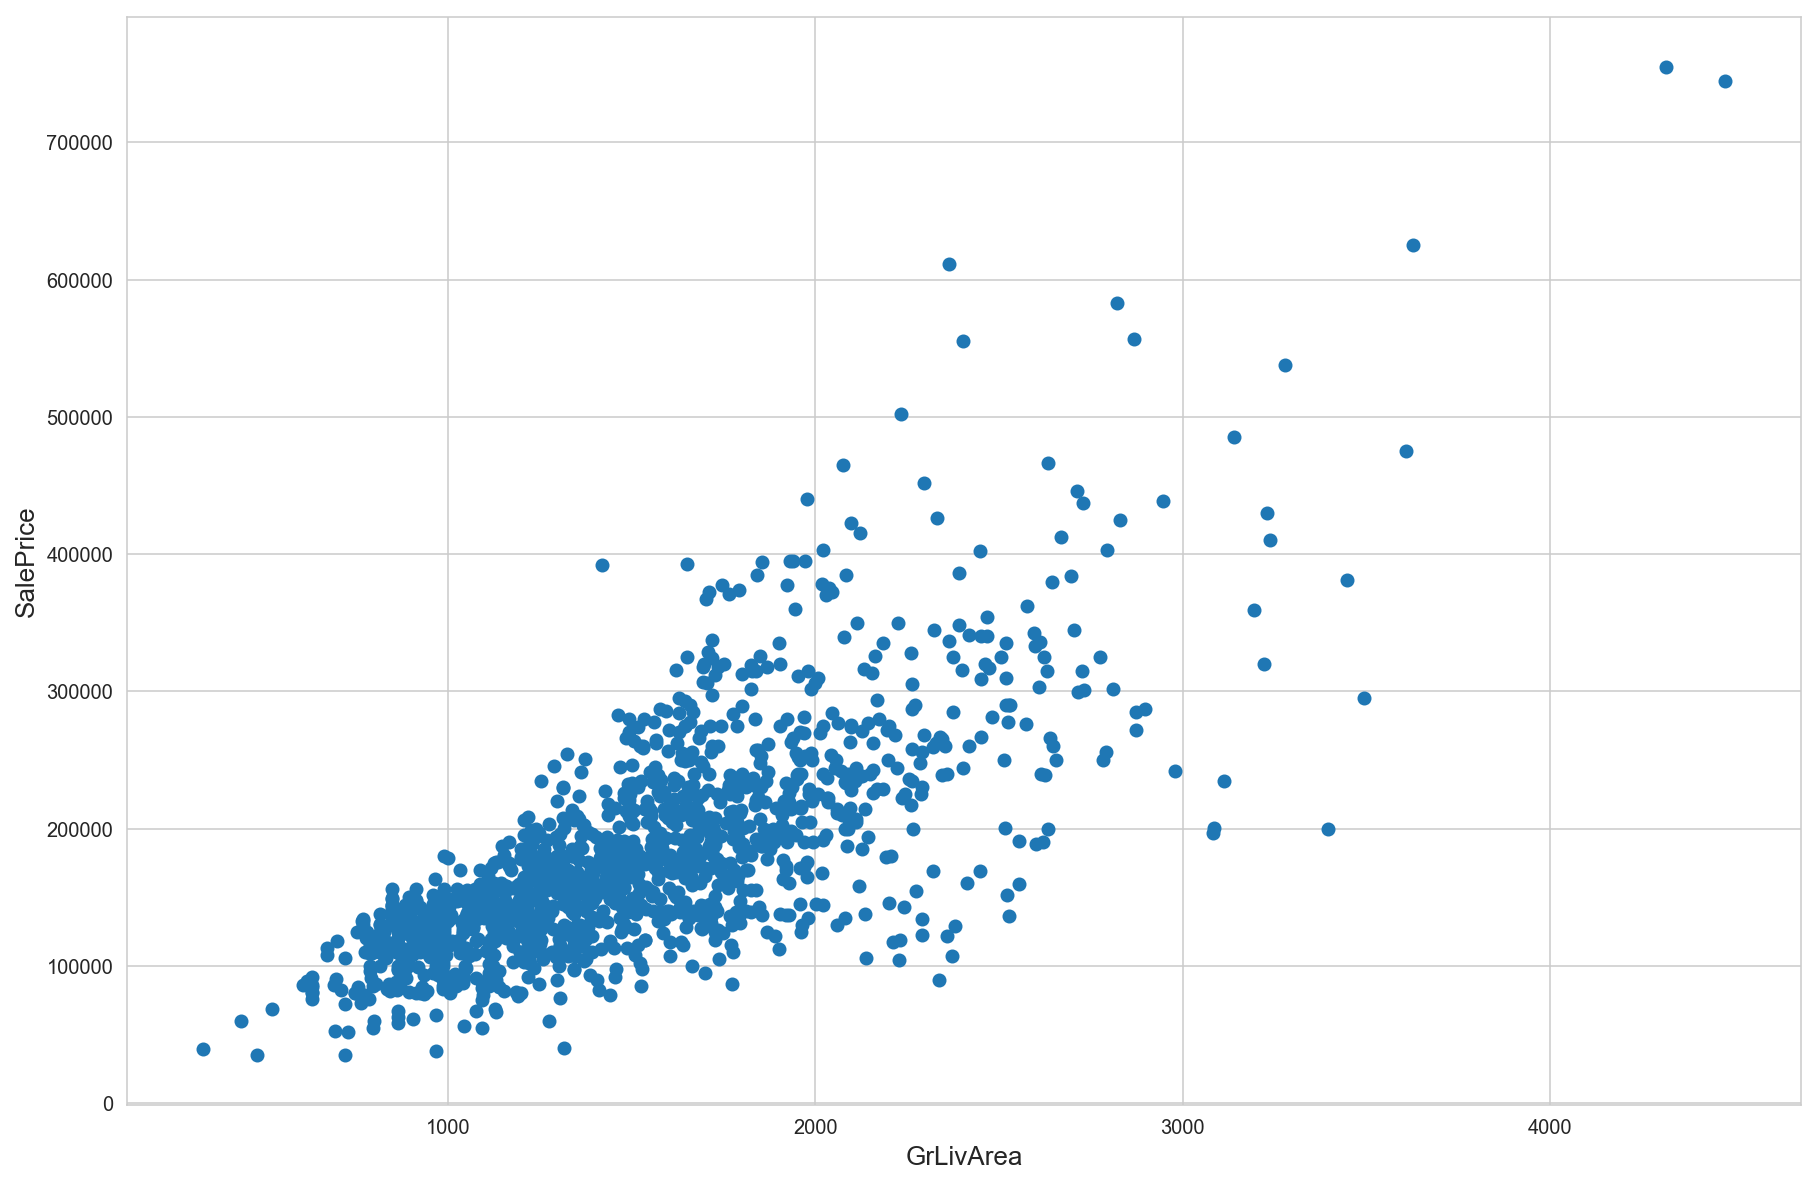

In [30]:
#Deleting outliers
house = house.drop(house[(house['GrLivArea']>4000) & (house['SalePrice']<300000)].index)

#Check the graph again
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(house['GrLivArea'], house['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

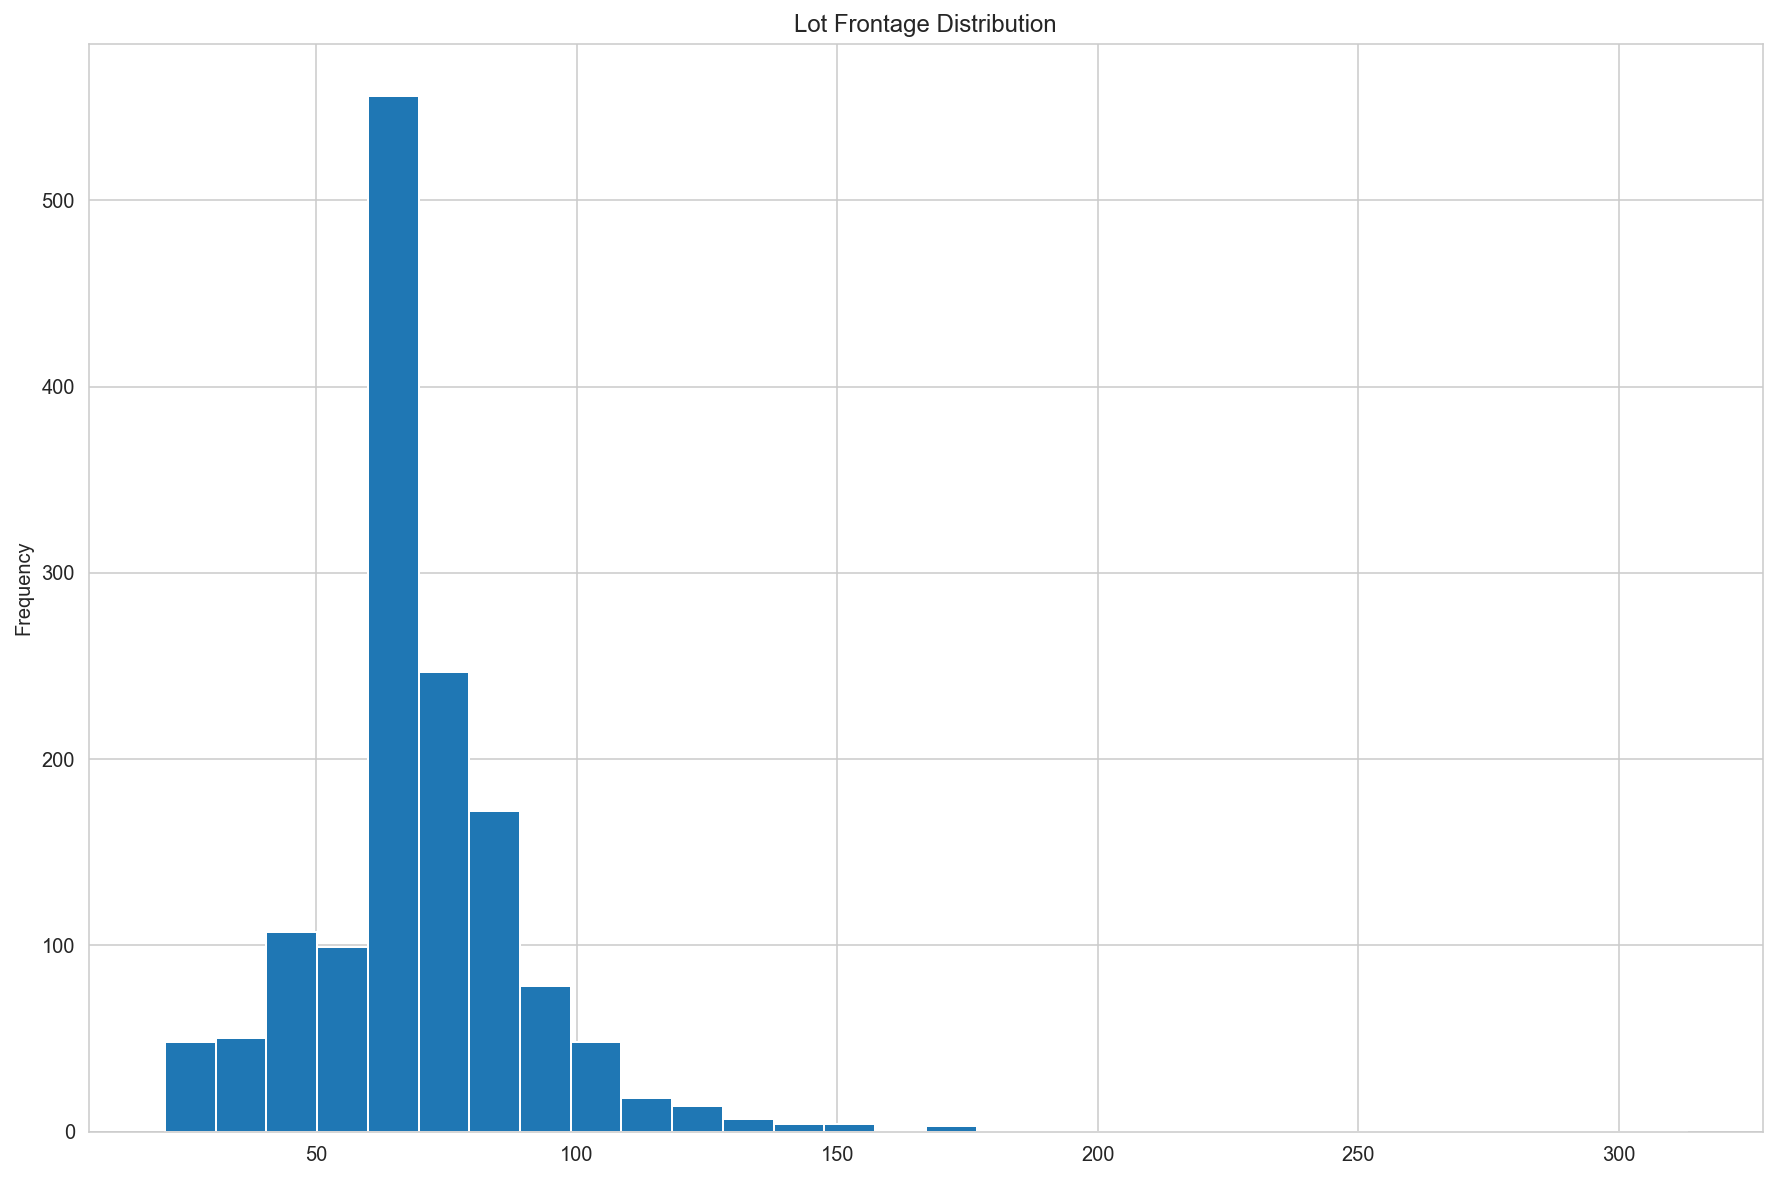

In [32]:
house.LotFrontage.plot(kind='hist', bins = 30, 
                       figsize = (15,10), title = 'Lot Frontage Distribution')

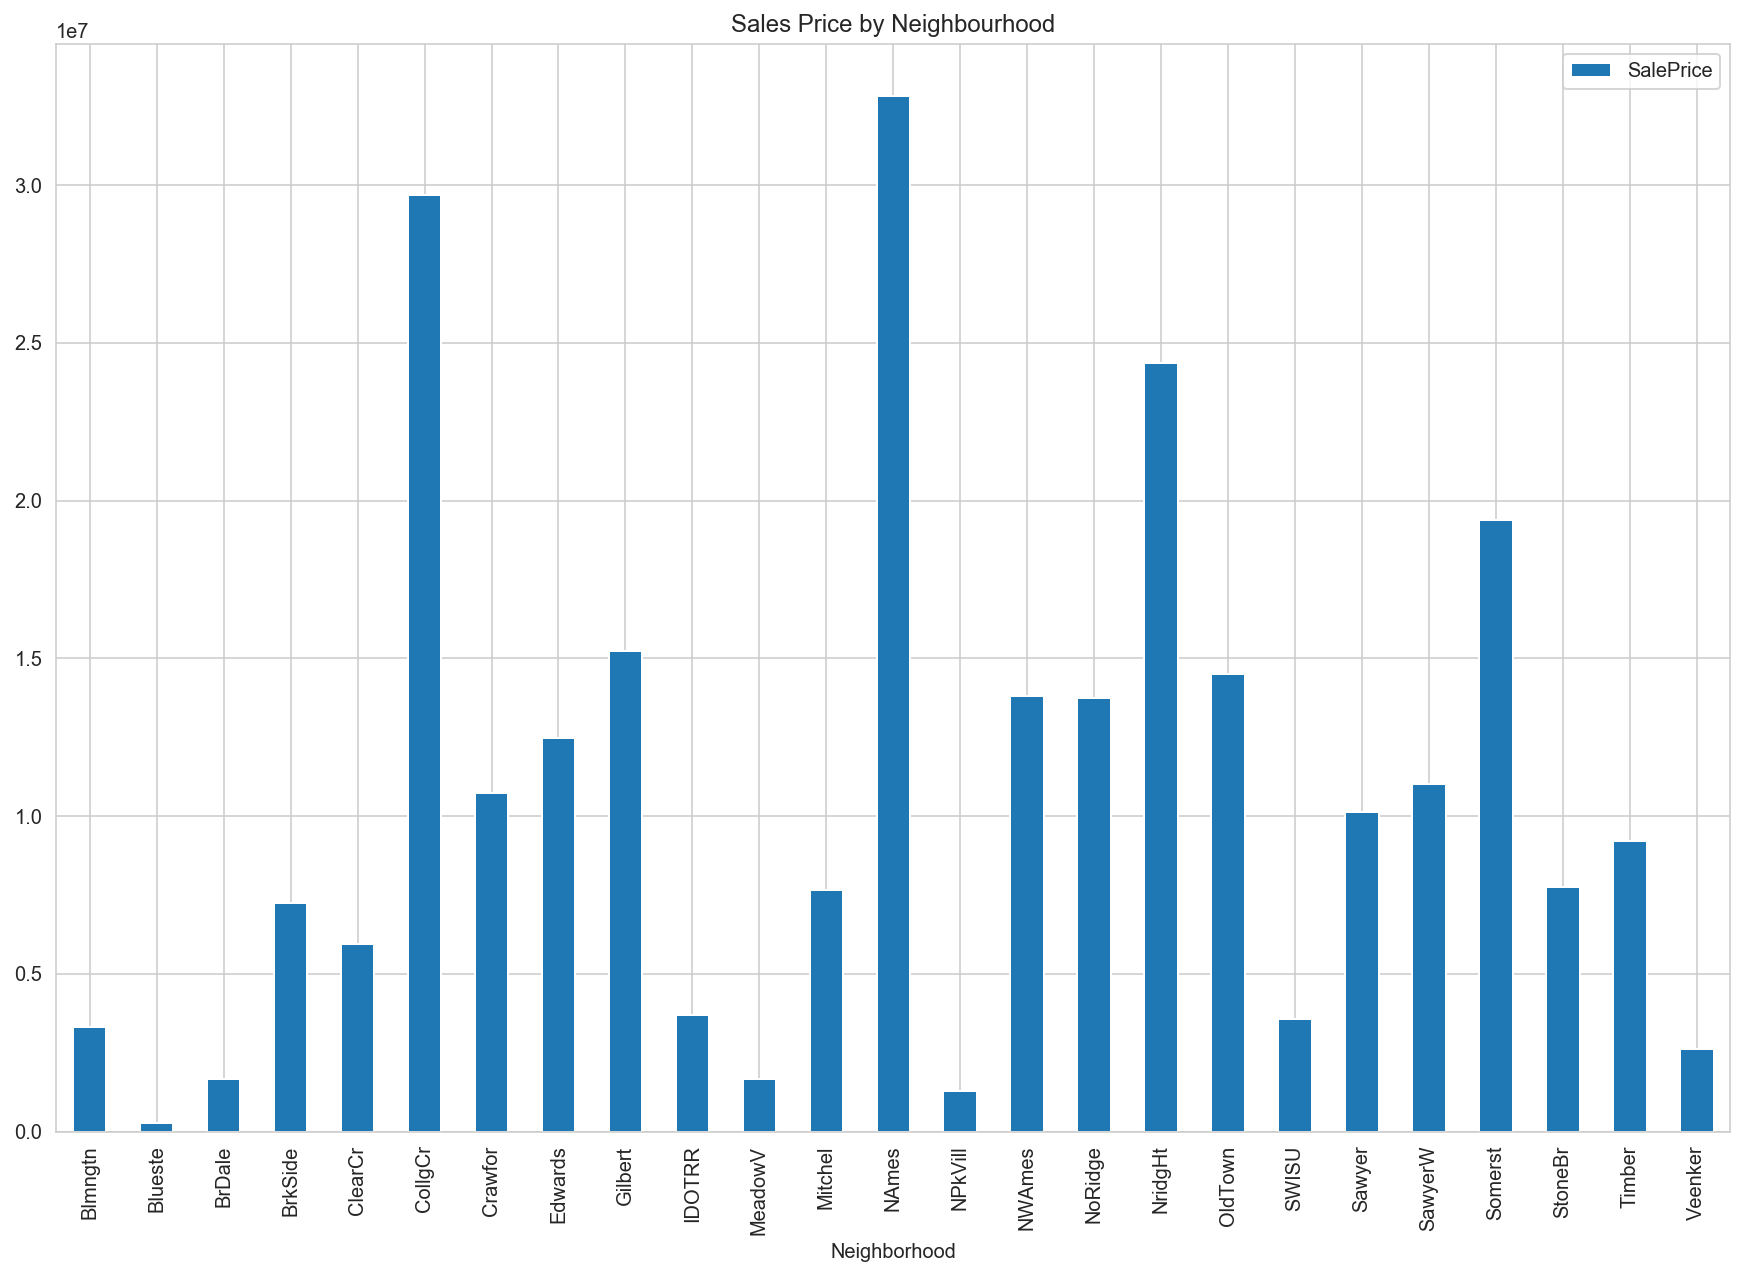

In [33]:
house.groupby('Neighborhood')[['SalePrice']].sum().plot(kind = 'bar', figsize = (15,10),title = 'Sales Price by Neighbourhood')

/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


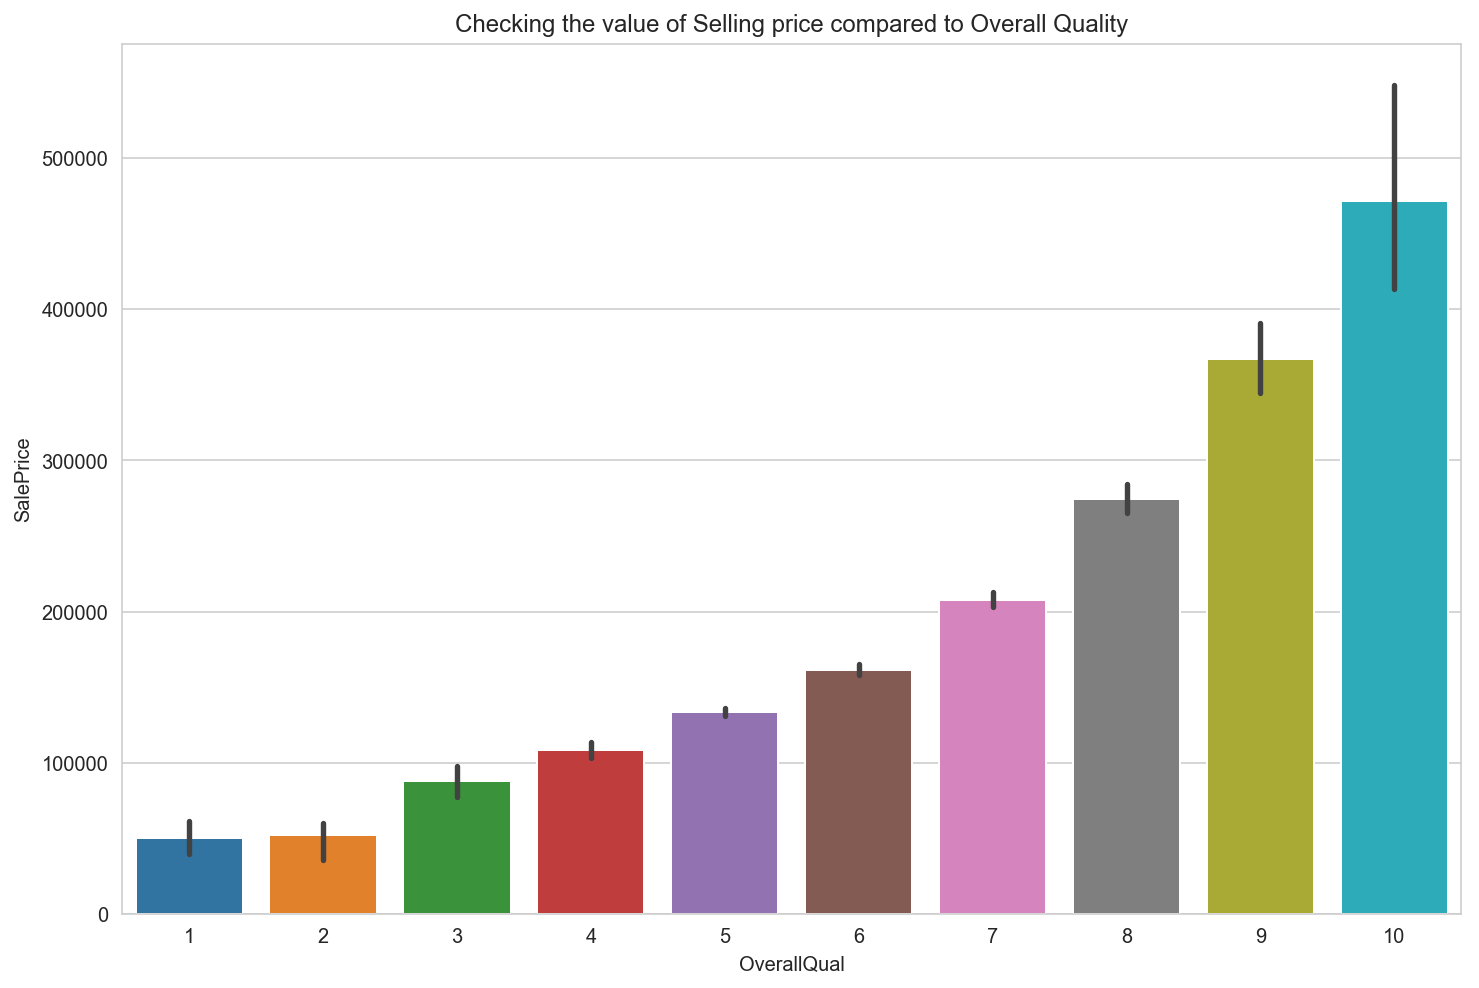

In [34]:
fig, ax = plt.subplots(figsize =(12,8))
ax = sns.barplot(house.OverallQual,house.SalePrice);
ax.set_title('Checking the value of Selling price compared to Overall Quality');

/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


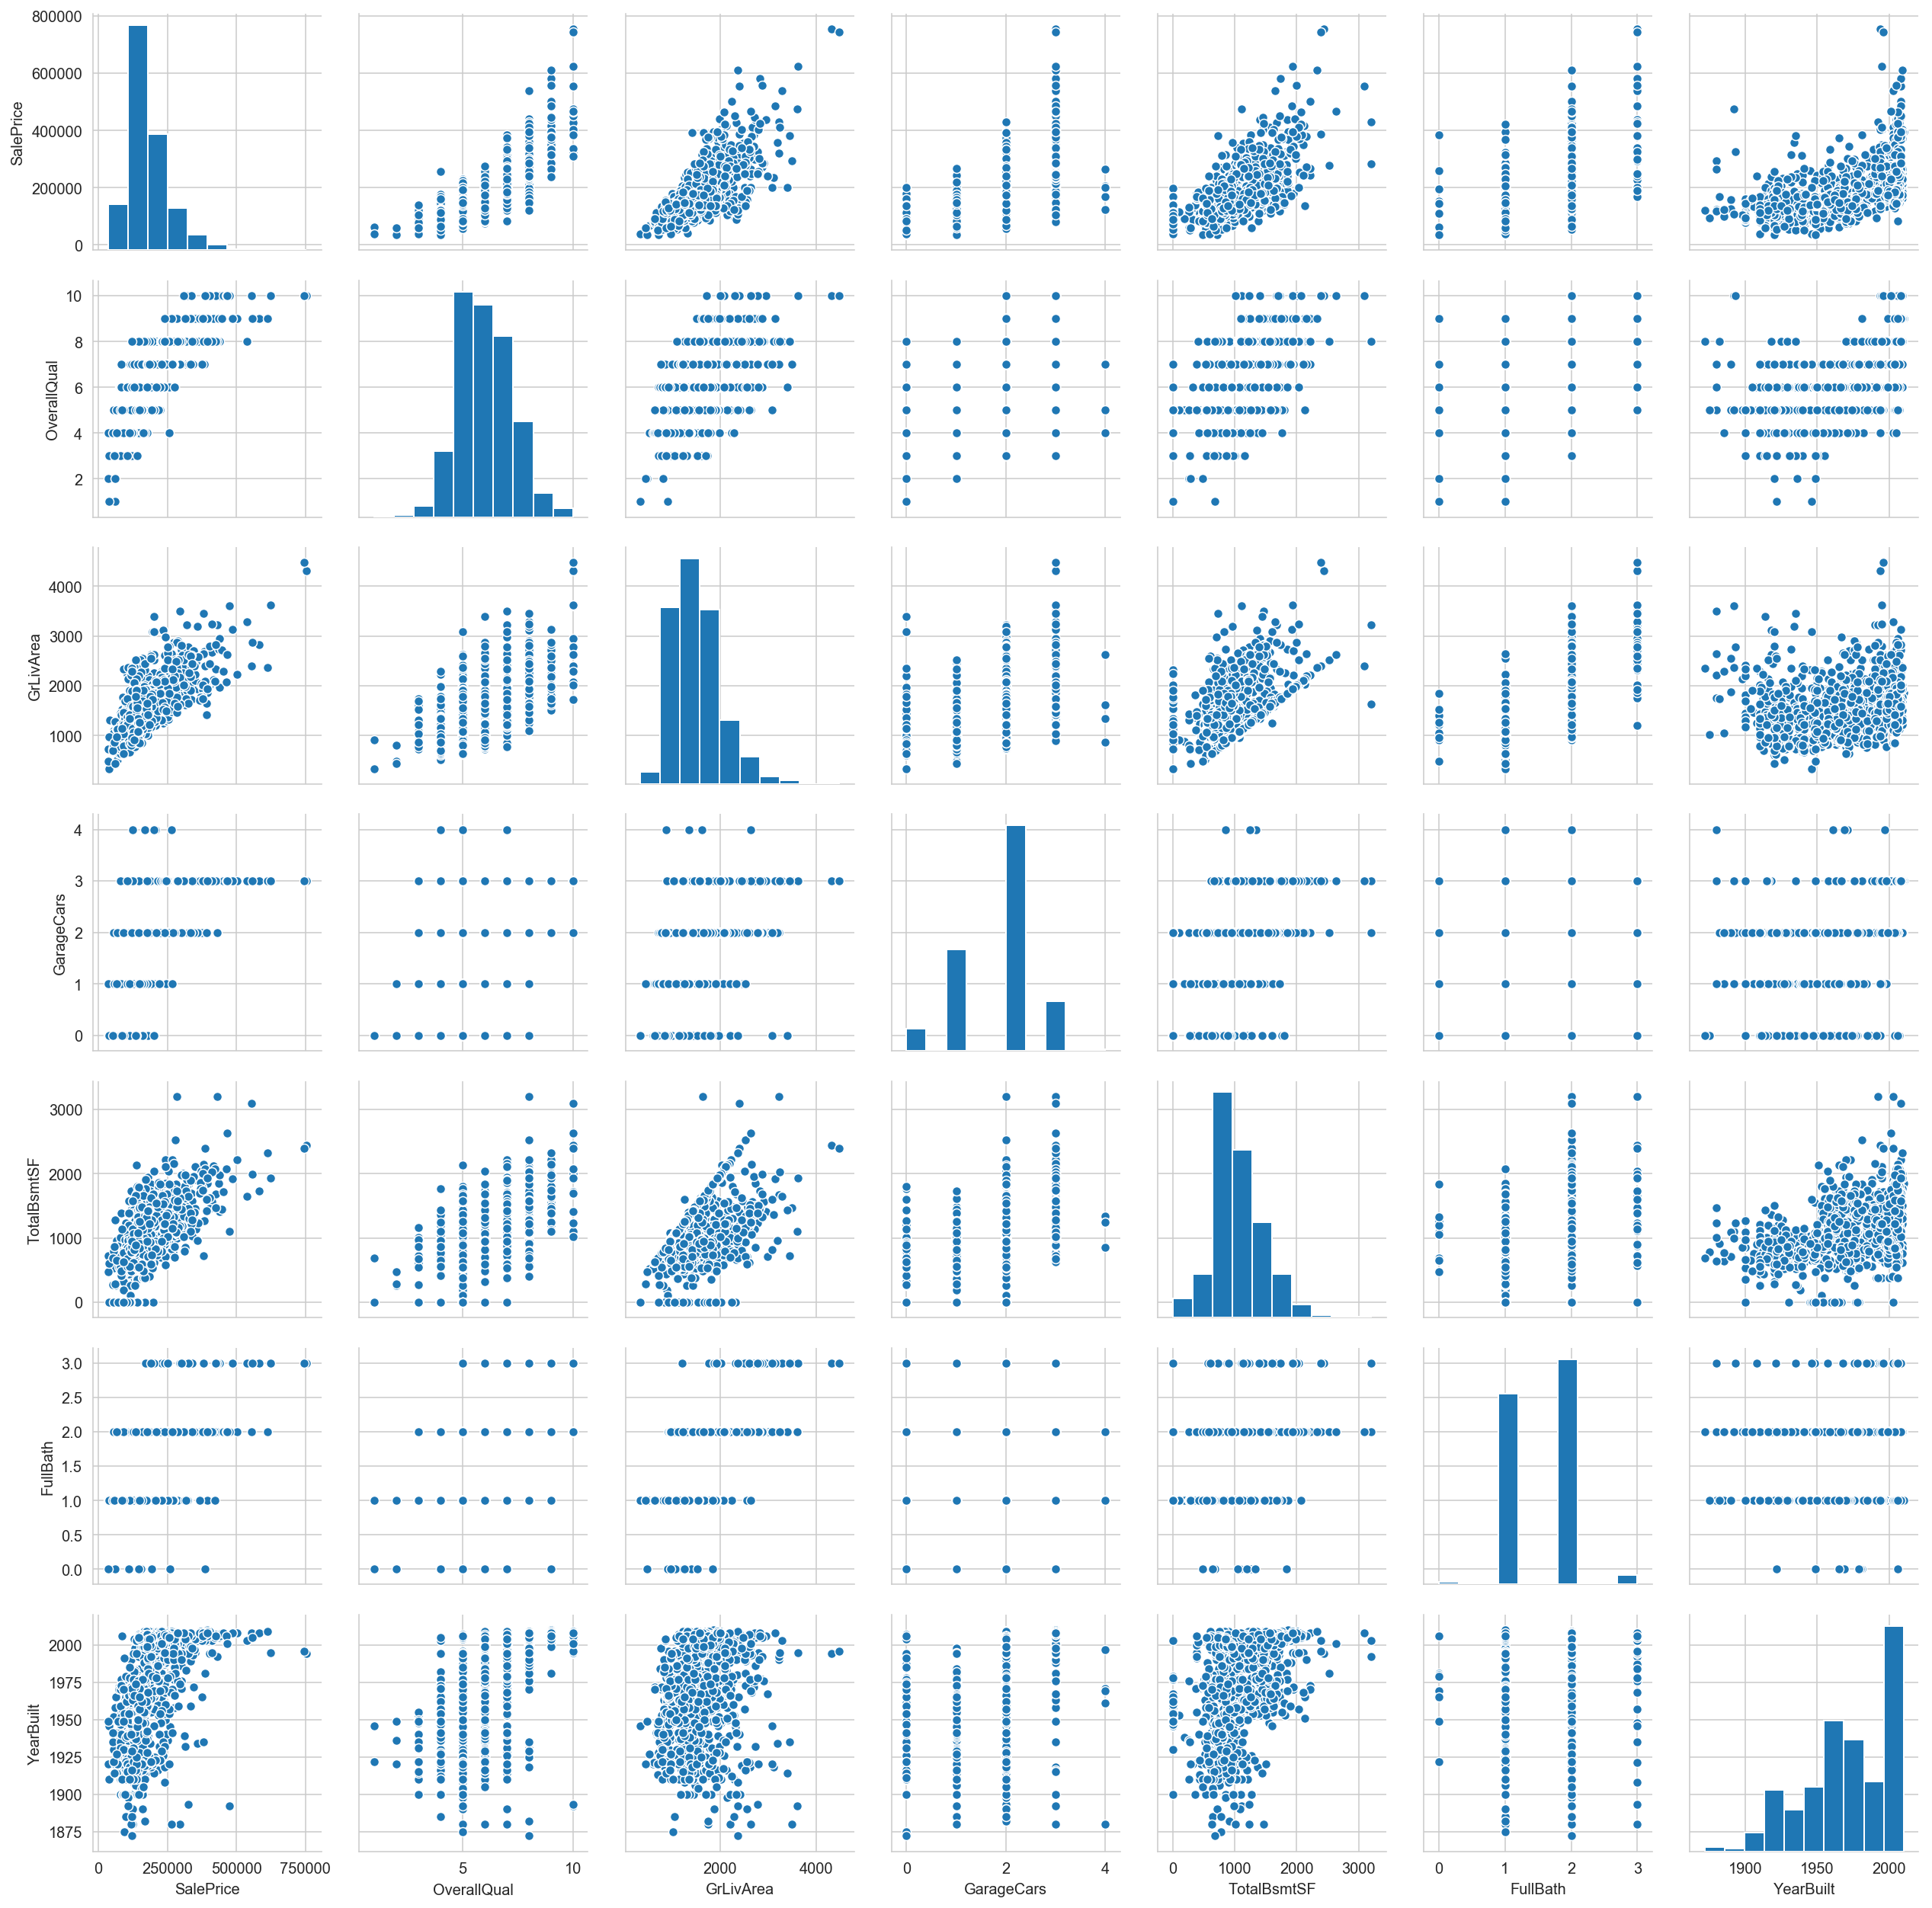

In [35]:
# checking distributions and relationships for some features 
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 
        'FullBath', 'YearBuilt']
sns.pairplot(house[cols], size = 2.5)
plt.show();

## Feature Selection
#### Continuous and discrete data

In [36]:
                            #option 1#

In [1269]:
fixed = [
    'MSSubClass','MSZoning','LotFrontage','LotArea', 'Street', 'Alley','LotShape', 'LandContour', 'LotConfig', 
    'LandSlope','Neighborhood', 'Condition1','Condition2', 'BldgType', 'HouseStyle',
    'YearBuilt','Foundation', 'BsmtQual', 'BsmtExposure', 
    'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath','BsmtHalfBath', 'FullBath', 
    'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 
    'GarageFinish',  'GarageCars','PoolArea', 'MoSold', 'YrSold', 'SaleType',
    'SaleCondition', 'SalePrice']

non_fixed= []
for col in house.columns:
    if col in fixed:
        pass
    else:
        non_fixed.append(col)

print(non_fixed)

['Id', 'Utilities', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal']


In [1270]:
house_fixed = house[[
    'MSSubClass','MSZoning','LotFrontage', 
    'LotArea', 'Street', 'Alley', 
    'LotShape', 'LandContour', 'LotConfig', 
    'LandSlope','Neighborhood', 'Condition1', 
    'Condition2', 'BldgType', 'HouseStyle',
    'YearBuilt',
    'Foundation', 'BsmtQual', 'BsmtExposure', 
    'TotalBsmtSF', 'GrLivArea', 
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
    'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
    'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 
    'GarageFinish',  'GarageCars',
    'PoolArea', 'MoSold', 'YrSold', 'SaleType',
    'SaleCondition', 'SalePrice']]
house_fixed.head(4)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave    NA      Reg   
1          20       RL         80.0     9600   Pave    NA      Reg   
2          60       RL         68.0    11250   Pave    NA      IR1   
3          70       RL         60.0     9550   Pave    NA      IR1   

  LandContour LotConfig LandSlope    ...     Fireplaces GarageYrBlt  \
0         Lvl    Inside       Gtl    ...              0      2003.0   
1         Lvl       FR2       Gtl    ...              1      1976.0   
2         Lvl    Inside       Gtl    ...              1      2001.0   
3         Lvl    Corner       Gtl    ...              1      1998.0   

  GarageFinish GarageCars PoolArea  MoSold YrSold SaleType SaleCondition  \
0          RFn          2        0       2   2008       WD        Normal   
1          RFn          2        0       5   2007       WD        Normal   
2          RFn          2        0       9   2008       WD        Normal   
3          Unf          3        0       2   2006       WD       Abnorml   

   SalePrice  
0     208500  
1     181500  
2     223500  
3     140000  

[4 rows x 38 columns]

In [1271]:
house_non_fixed = house[['Utilities', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal']]
house_non_fixed.head(4)

Utilities  OverallQual  OverallCond  YearRemodAdd RoofStyle RoofMatl  \
0    AllPub            7            5          2003     Gable  CompShg   
1    AllPub            6            8          1976     Gable  CompShg   
2    AllPub            7            5          2002     Gable  CompShg   
3    AllPub            7            5          1970     Gable  CompShg   

  Exterior1st Exterior2nd MasVnrType  MasVnrArea   ...   PavedDrive  \
0     VinylSd     VinylSd      SBrkr       196.0   ...            Y   
1     MetalSd     MetalSd      SBrkr         0.0   ...            Y   
2     VinylSd     VinylSd      SBrkr       162.0   ...            Y   
3     Wd Sdng     Wd Shng      SBrkr         0.0   ...            Y   

  WoodDeckSF OpenPorchSF EnclosedPorch  3SsnPorch ScreenPorch  PoolQC  Fence  \
0          0          61             0          0           0      NA     NA   
1        298           0             0          0           0      NA     NA   
2          0          42             0          0           0      NA     NA   
3          0          35           272          0           0      NA     NA   

  MiscFeature MiscVal  
0          NA       0  
1          NA       0  
2          NA       0  
3          NA       0  

[4 rows x 42 columns]

In [1272]:
                            #option 2#

In [1273]:
## Selecting the numerical columns of the housing dataframe
house_Continuous= house.select_dtypes(include=[np.number])
house_Continuous.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [1274]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = house.select_dtypes(include=['object']).columns
house_categorical = house[categorical_features]
house_categorical.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [1275]:
print ('continous',house_Continuous.shape)
print ('categorical',house_categorical.shape)
print ('total all',house.shape)

continous (1458, 38)
categorical (1458, 43)
total all (1458, 81)


#### Continous detail

In [1276]:
house_Continuous.head()

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1    ...      WoodDeckSF  OpenPorchSF  \
0          2003       196.0         706    ...               0           61   
1          1976         0.0         978    ...             298            0   
2          2002       162.0         486    ...               0           42   
3          1970         0.0         216    ...               0           35   
4          2000       350.0         655    ...             192           84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   
2              0          0            0         0        0       9    2008   
3            272          0            0         0        0       2    2006   
4              0          0            0         0        0      12    2008   

   SalePrice  
0     208500  
1     181500  
2     223500  
3     140000  
4     250000  

[5 rows x 38 columns]

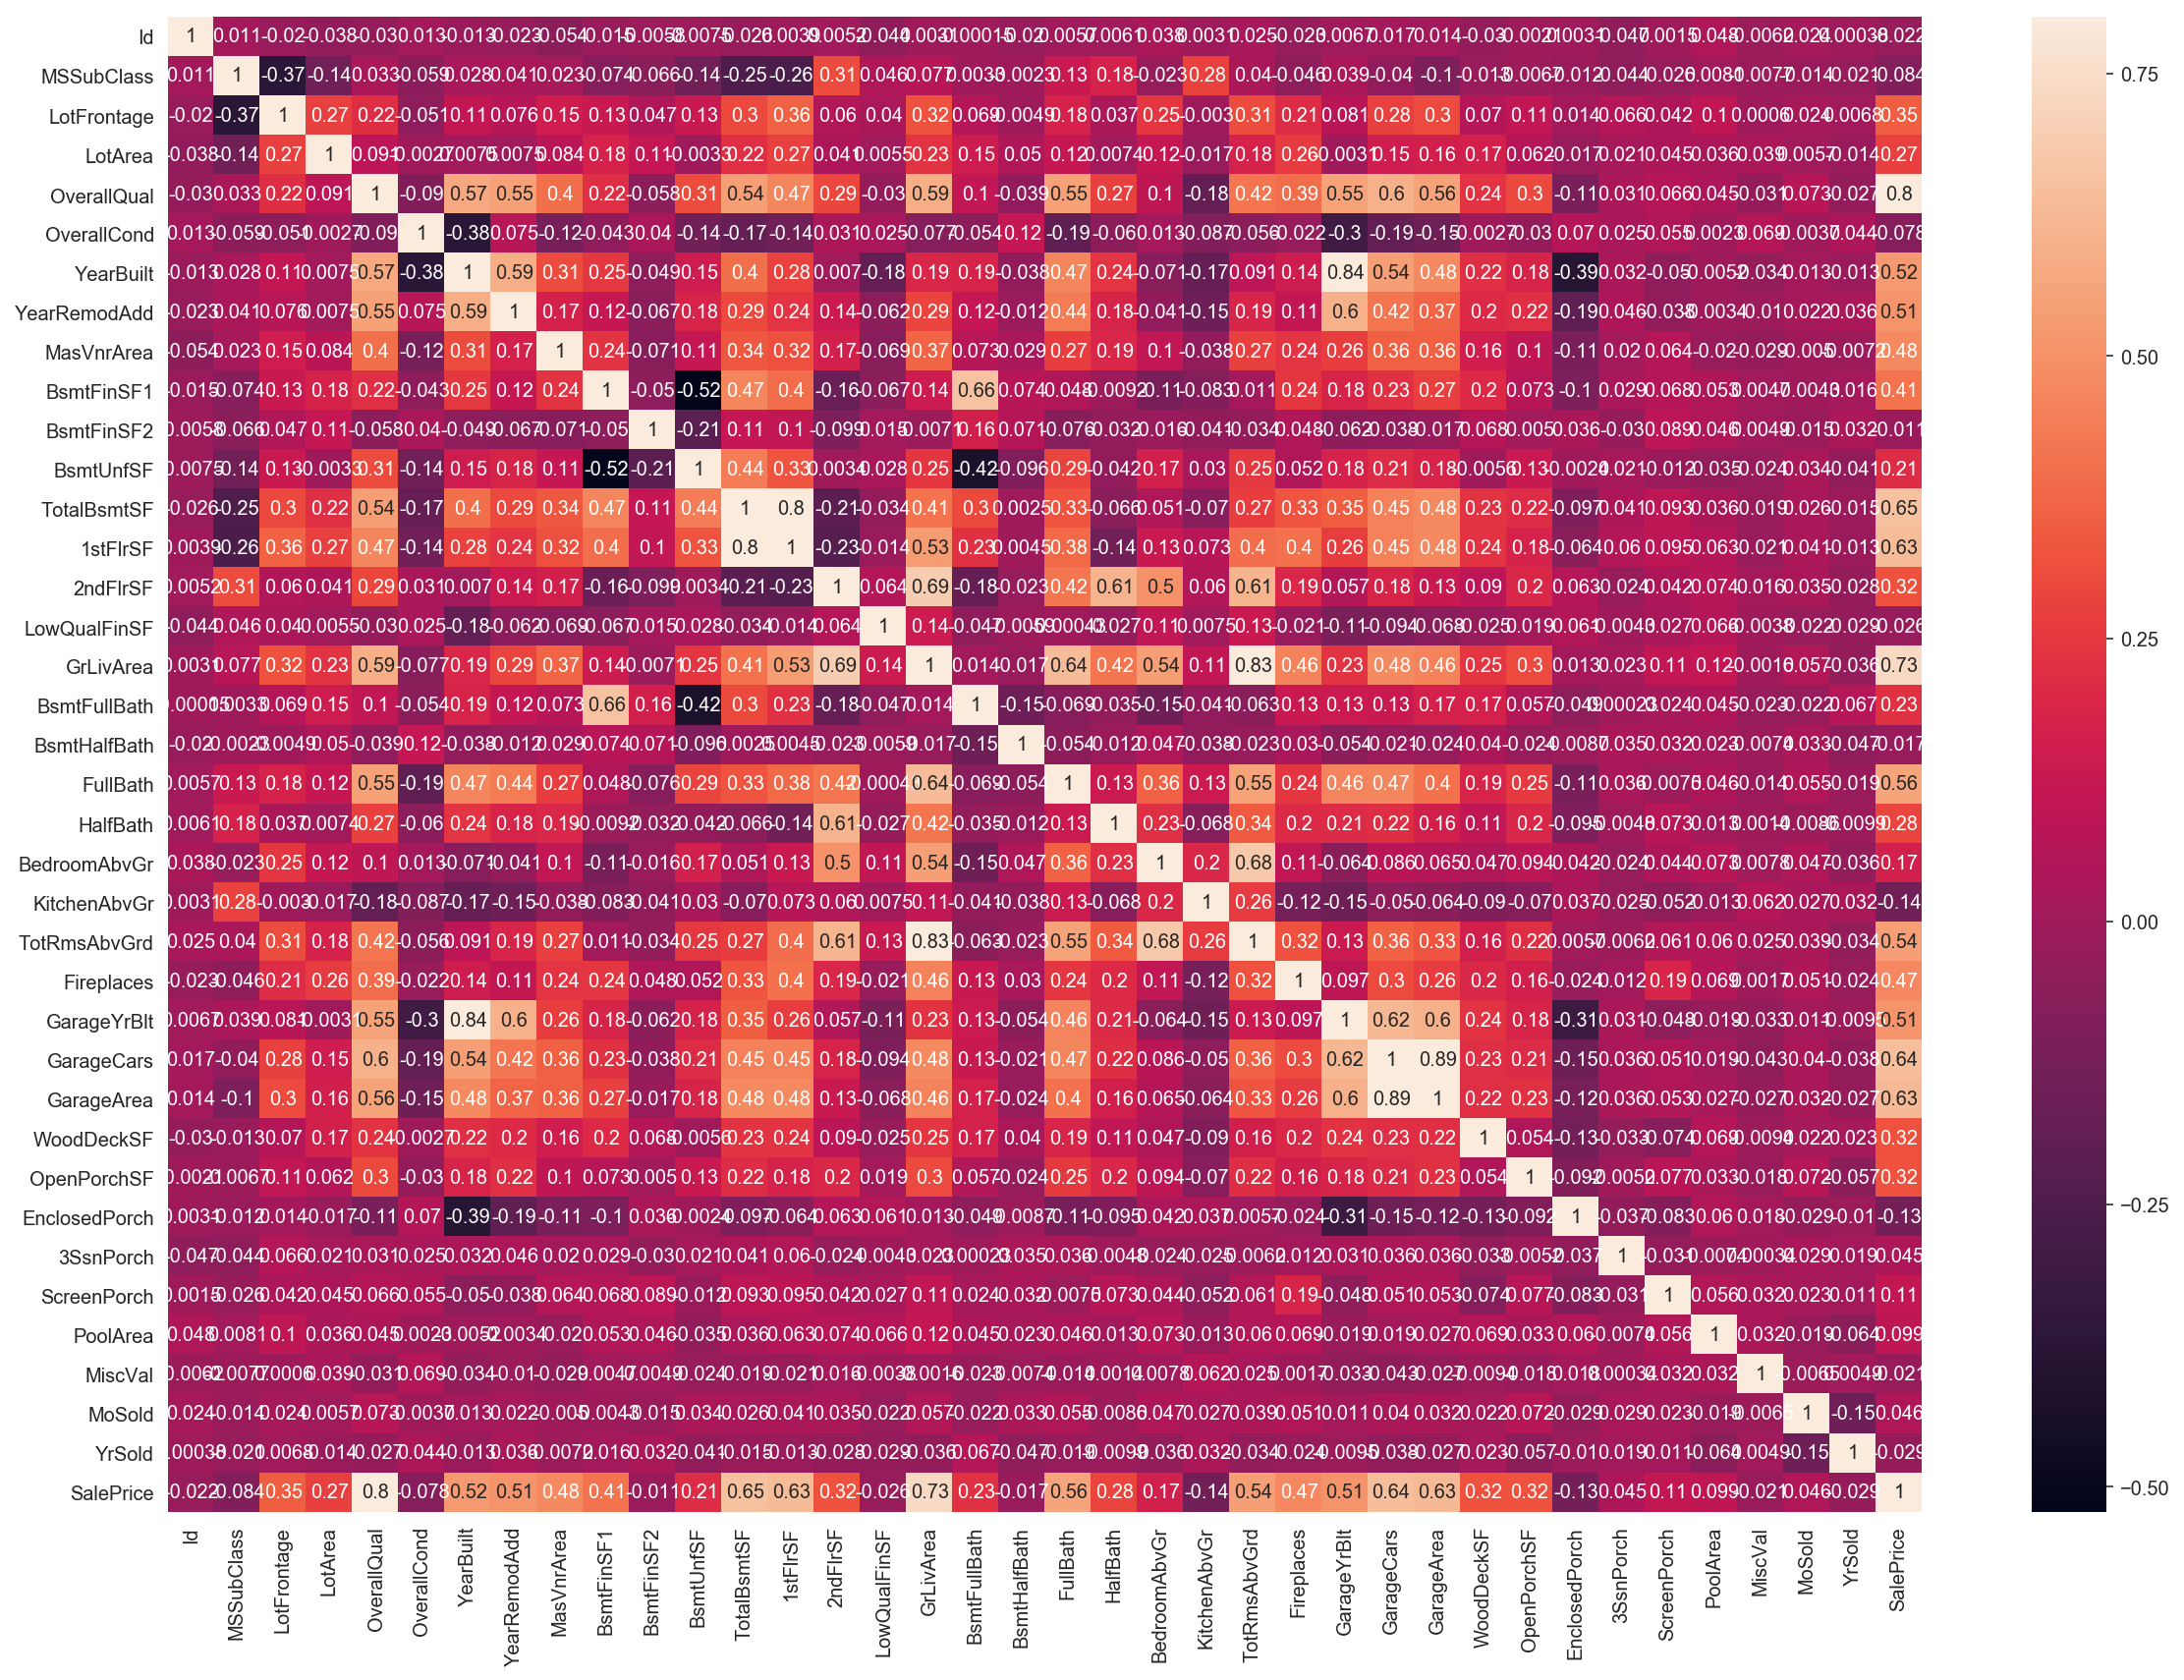

In [1277]:
#correlation matrix
corr_mat = house_Continuous.corr()
fig, ax = plt.subplots(figsize=(20, 14))
sns.heatmap(corr_mat, vmax=.8, annot=True);

In [1278]:
# Selecting features with correlation greater than 0.5
#top_corr_features = corr_mat.index[abs(corr_mat["SalePrice"])>0.4]

# Plot the correlation matrix with the selected features
#plt.figure(figsize=(15,10))
#ax = sns.heatmap(house_num[top_corr_features].corr(),annot=True, cmap = 'RdYlGn')
#ax.set_xticklabels(ax.xaxis.get_ticklabels(),rotation = 45) 
#plt.show()

#top_corr_features
#house_Continuous = house_Continuous[top_corr_features]

In [1279]:
house_Continuous.head().T

0         1         2         3         4
Id                  1.0       2.0       3.0       4.0       5.0
MSSubClass         60.0      20.0      60.0      70.0      60.0
LotFrontage        65.0      80.0      68.0      60.0      84.0
LotArea          8450.0    9600.0   11250.0    9550.0   14260.0
OverallQual         7.0       6.0       7.0       7.0       8.0
OverallCond         5.0       8.0       5.0       5.0       5.0
YearBuilt        2003.0    1976.0    2001.0    1915.0    2000.0
YearRemodAdd     2003.0    1976.0    2002.0    1970.0    2000.0
MasVnrArea        196.0       0.0     162.0       0.0     350.0
BsmtFinSF1        706.0     978.0     486.0     216.0     655.0
BsmtFinSF2          0.0       0.0       0.0       0.0       0.0
BsmtUnfSF         150.0     284.0     434.0     540.0     490.0
TotalBsmtSF       856.0    1262.0     920.0     756.0    1145.0
1stFlrSF          856.0    1262.0     920.0     961.0    1145.0
2ndFlrSF          854.0       0.0     866.0     756.0    1053.0
LowQualFinSF        0.0       0.0       0.0       0.0       0.0
GrLivArea        1710.0    1262.0    1786.0    1717.0    2198.0
BsmtFullBath        1.0       0.0       1.0       1.0       1.0
BsmtHalfBath        0.0       1.0       0.0       0.0       0.0
FullBath            2.0       2.0       2.0       1.0       2.0
HalfBath            1.0       0.0       1.0       0.0       1.0
BedroomAbvGr        3.0       3.0       3.0       3.0       4.0
KitchenAbvGr        1.0       1.0       1.0       1.0       1.0
TotRmsAbvGrd        8.0       6.0       6.0       7.0       9.0
Fireplaces          0.0       1.0       1.0       1.0       1.0
GarageYrBlt      2003.0    1976.0    2001.0    1998.0    2000.0
GarageCars          2.0       2.0       2.0       3.0       3.0
GarageArea        548.0     460.0     608.0     642.0     836.0
WoodDeckSF          0.0     298.0       0.0       0.0     192.0
OpenPorchSF        61.0       0.0      42.0      35.0      84.0
EnclosedPorch       0.0       0.0       0.0     272.0       0.0
3SsnPorch           0.0       0.0       0.0       0.0       0.0
ScreenPorch         0.0       0.0       0.0       0.0       0.0
PoolArea            0.0       0.0       0.0       0.0       0.0
MiscVal             0.0       0.0       0.0       0.0       0.0
MoSold              2.0       5.0       9.0       2.0      12.0
YrSold           2008.0    2007.0    2008.0    2006.0    2008.0
SalePrice      208500.0  181500.0  223500.0  140000.0  250000.0

In [1280]:
## Function to drop column of dataframe
def drop_cols(df, col_name):
    df.drop(col_name, axis=1, inplace=True)

In [1281]:
## Lets combine fullbath and half bath together
house_Continuous['total_bath'] = house_Continuous['FullBath'] + house['HalfBath']
#drop_cols(house_Continuous,'FullBath')

In [1282]:
#house_Continuous[['PoolArea', 'MiscVal']]

In [1283]:
house_Continuous.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 39 columns):
Id               1458 non-null int64
MSSubClass       1458 non-null int64
LotFrontage      1458 non-null float64
LotArea          1458 non-null int64
OverallQual      1458 non-null int64
OverallCond      1458 non-null int64
YearBuilt        1458 non-null int64
YearRemodAdd     1458 non-null int64
MasVnrArea       1458 non-null float64
BsmtFinSF1       1458 non-null int64
BsmtFinSF2       1458 non-null int64
BsmtUnfSF        1458 non-null int64
TotalBsmtSF      1458 non-null int64
1stFlrSF         1458 non-null int64
2ndFlrSF         1458 non-null int64
LowQualFinSF     1458 non-null int64
GrLivArea        1458 non-null int64
BsmtFullBath     1458 non-null int64
BsmtHalfBath     1458 non-null int64
FullBath         1458 non-null int64
HalfBath         1458 non-null int64
BedroomAbvGr     1458 non-null int64
KitchenAbvGr     1458 non-null int64
TotRmsAbvGrd     1458 non-null int64
F

In [1284]:
house_Continuous['house_age'] = house['YrSold'] - house['YearBuilt']

In [1285]:
house_Continuous.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'total_bath', 'house_age'],
      dtype='object')

In [1286]:
house_Continuous_corr = house_Continuous.corr()

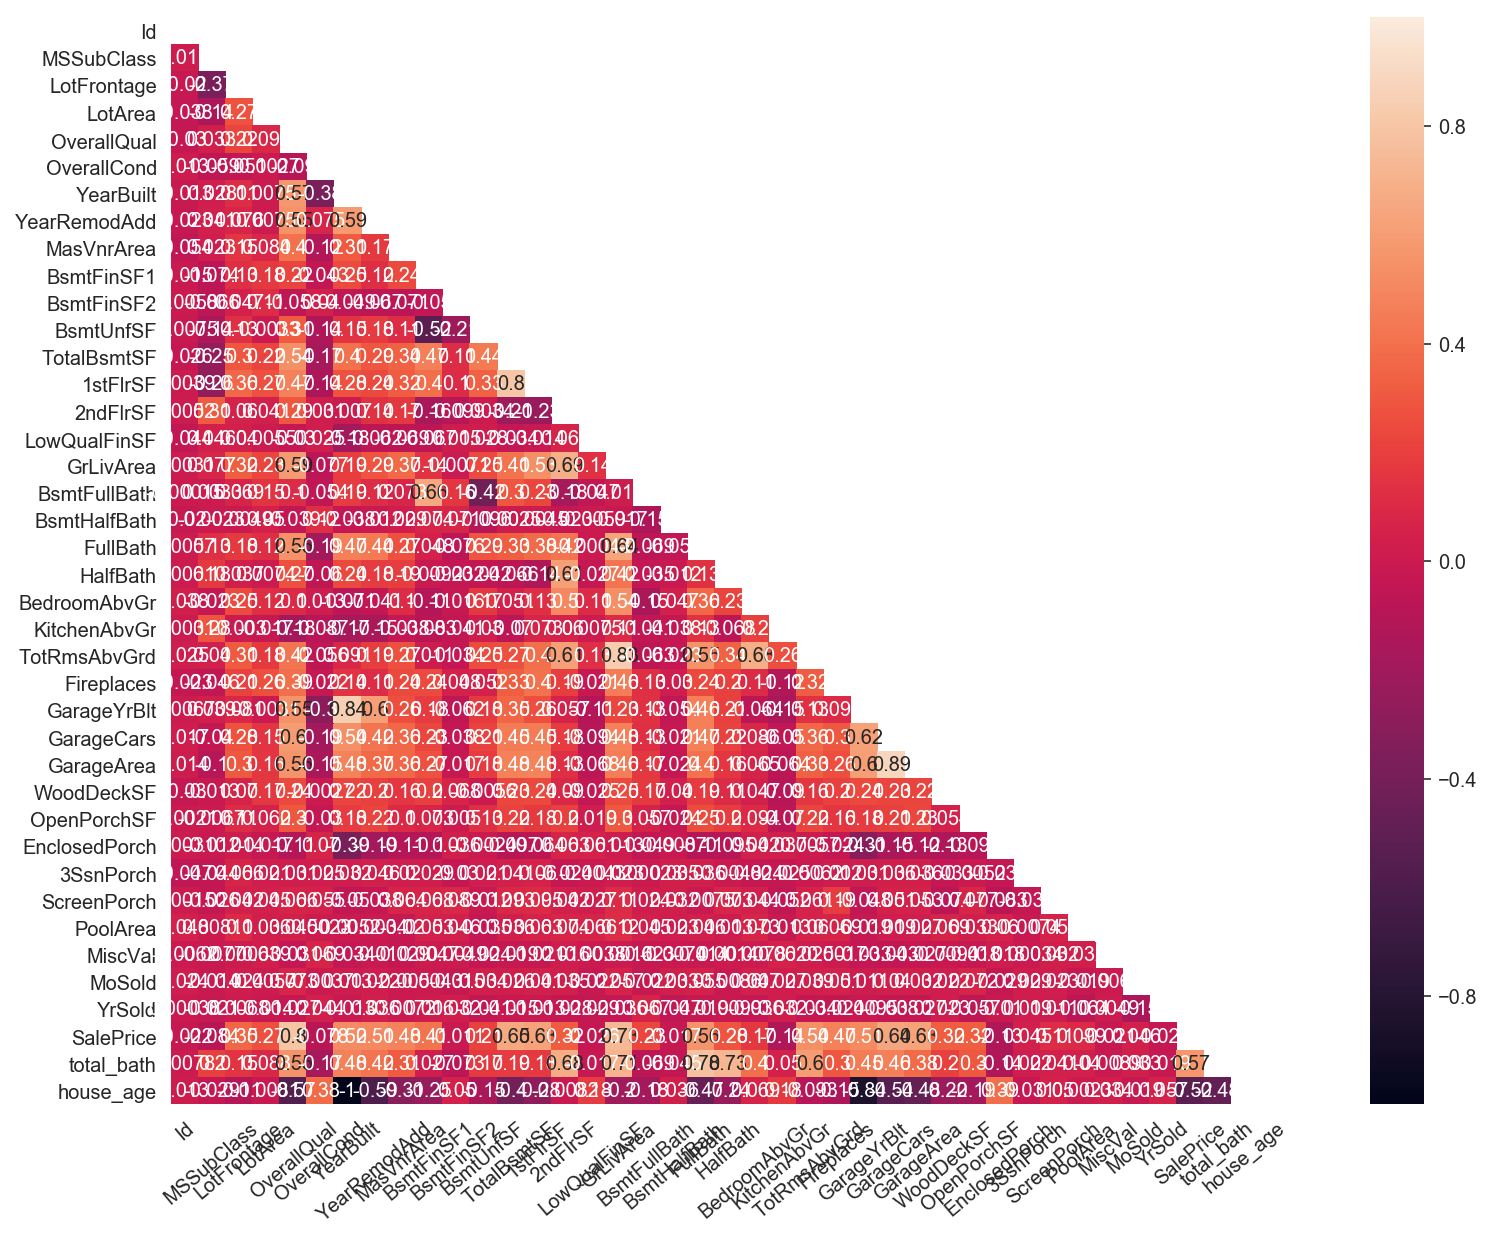

In [1287]:
plt.figure(figsize=(20,10))
mask = np.zeros_like(house_Continuous_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(house_Continuous_corr, annot = True, mask = mask, square = True )
ax.set_xticklabels(ax.xaxis.get_ticklabels(),rotation = 40);   

In [1288]:
len(house_Continuous)

1458

#### Categorical detail

In [1289]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = house.select_dtypes(include=['object']).columns
house_categorical = house[categorical_features]
house_categorical.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [1290]:
house_categorical.CentralAir.replace(('Y', 'N'), (1, 0), inplace=True)

In [1291]:
house_categorical.head(4)

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0       RL   Pave    NA      Reg         Lvl    AllPub    Inside       Gtl   
1       RL   Pave    NA      Reg         Lvl    AllPub       FR2       Gtl   
2       RL   Pave    NA      IR1         Lvl    AllPub    Inside       Gtl   
3       RL   Pave    NA      IR1         Lvl    AllPub    Corner       Gtl   

  Neighborhood Condition1      ...      GarageType GarageFinish GarageQual  \
0      CollgCr       Norm      ...          Attchd          RFn         TA   
1      Veenker      Feedr      ...          Attchd          RFn         TA   
2      CollgCr       Norm      ...          Attchd          RFn         TA   
3      Crawfor       Norm      ...          Detchd          Unf         TA   

  GarageCond PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition  
0         TA          Y     NA    NA          NA       WD        Normal  
1         TA          Y     NA    NA          NA       WD        Normal  
2         TA          Y     NA    NA          NA       WD        Normal  
3         TA          Y     NA    NA          NA       WD       Abnorml  

[4 rows x 43 columns]

In [1292]:
## Since MSZoning can be deduced from other features, it is redundant
house_categorical.drop('MSZoning', axis = 1, inplace = True)

In [1293]:
display (house_categorical.Street.value_counts())
display (house_categorical.Alley.value_counts())
display (house_categorical.Utilities.value_counts())
display (house_categorical.PoolQC.value_counts())
display (house_categorical.Fence.value_counts())
display (house_categorical.HouseStyle.value_counts())
display (house_categorical.RoofStyle.value_counts())

Pave    1452
Grvl       6
Name: Street, dtype: int64

NA      1367
Grvl      50
Pave      41
Name: Alley, dtype: int64

AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64

NA    1452
Ex       2
Gd       2
Fa       2
Name: PoolQC, dtype: int64

NA       1177
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

1Story    726
2Story    443
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

Gable      1141
Hip         284
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

In [1294]:
# Since overallQual is categorical, we need to change it into categorical
house_categorical['OverallQual'] = house_num['OverallQual'].astype(str)

In [1295]:
#function rename column
def rename_cols(df,col_name, new_name): 
    df.rename(columns={col_name : new_name}, inplace = True)

In [1296]:
house_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 43 columns):
Street           1458 non-null object
Alley            1458 non-null object
LotShape         1458 non-null object
LandContour      1458 non-null object
Utilities        1458 non-null object
LotConfig        1458 non-null object
LandSlope        1458 non-null object
Neighborhood     1458 non-null object
Condition1       1458 non-null object
Condition2       1458 non-null object
BldgType         1458 non-null object
HouseStyle       1458 non-null object
RoofStyle        1458 non-null object
RoofMatl         1458 non-null object
Exterior1st      1458 non-null object
Exterior2nd      1458 non-null object
MasVnrType       1458 non-null object
ExterQual        1458 non-null object
ExterCond        1458 non-null object
Foundation       1458 non-null object
BsmtQual         1458 non-null object
BsmtCond         1458 non-null object
BsmtExposure     1458 non-null object
BsmtFinType1     14

In [1297]:
len(discrete)

43

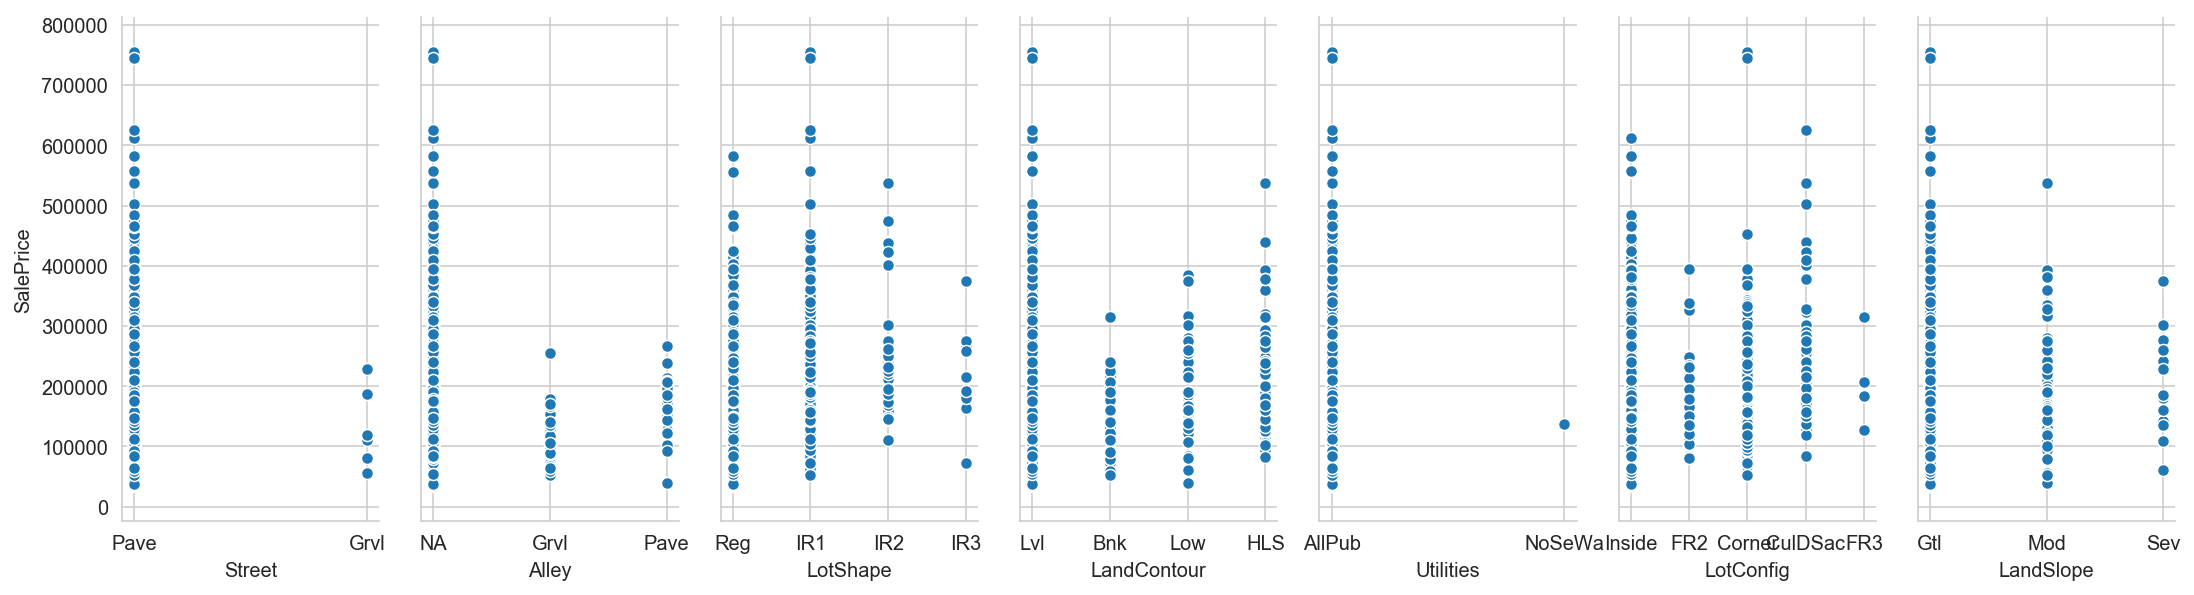

In [1298]:
#sns.pairplot(df, hue = 'continent')
#sns.pairplot(house_categorical)
discrete =['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition']
plot= sns.pairplot(house, y_vars= ['SalePrice'], x_vars= discrete[1:8])
plot.fig.set_size_inches(15,5)

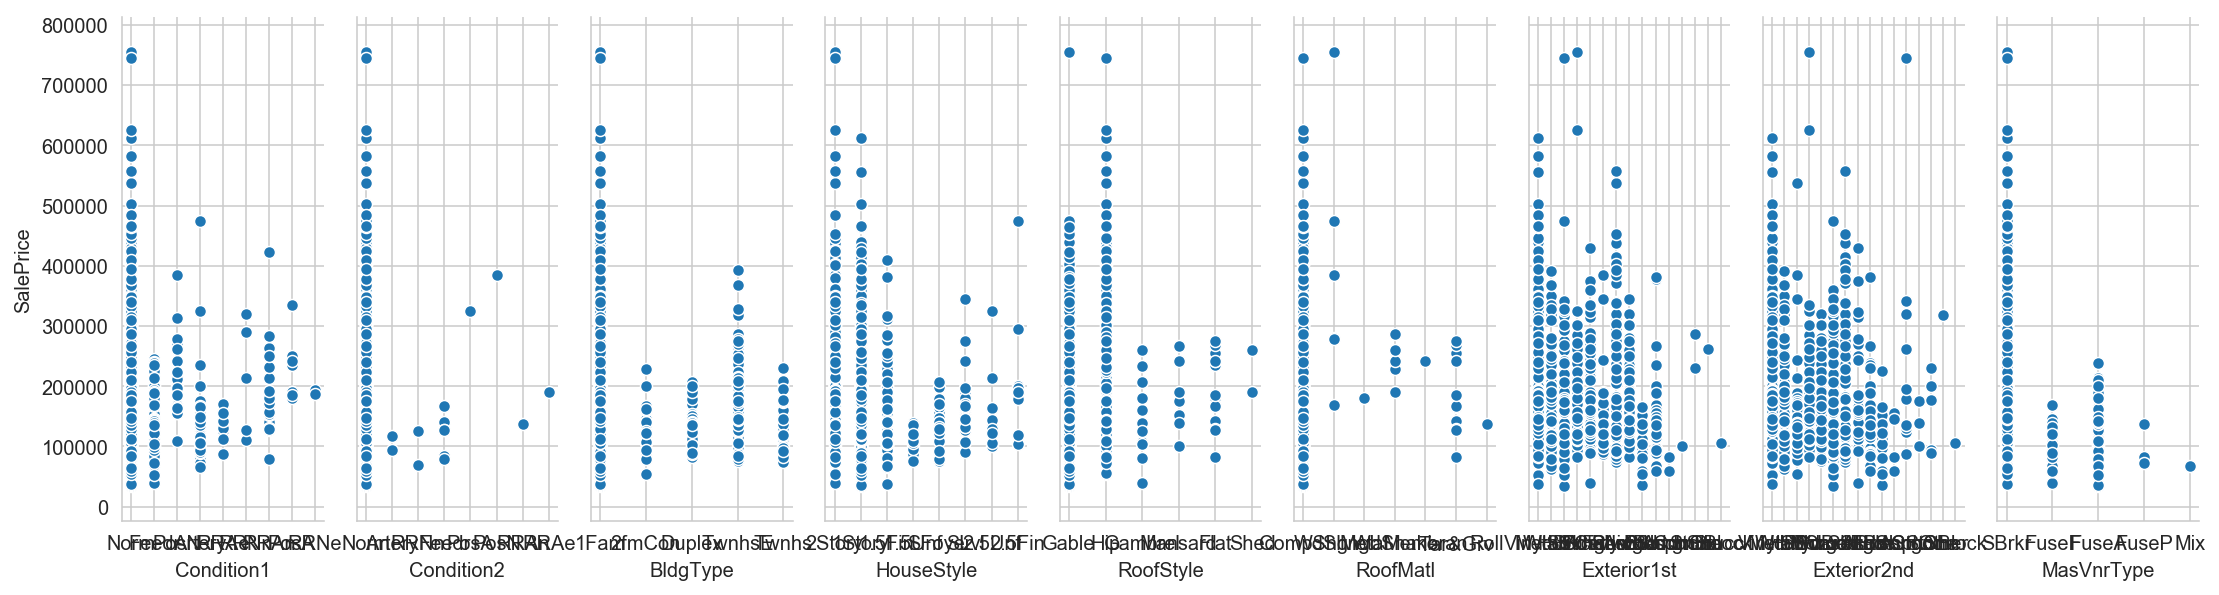

In [1299]:
plot= sns.pairplot(house, y_vars= ['SalePrice'], x_vars= discrete[9:18])
plot.fig.set_size_inches(15,5)

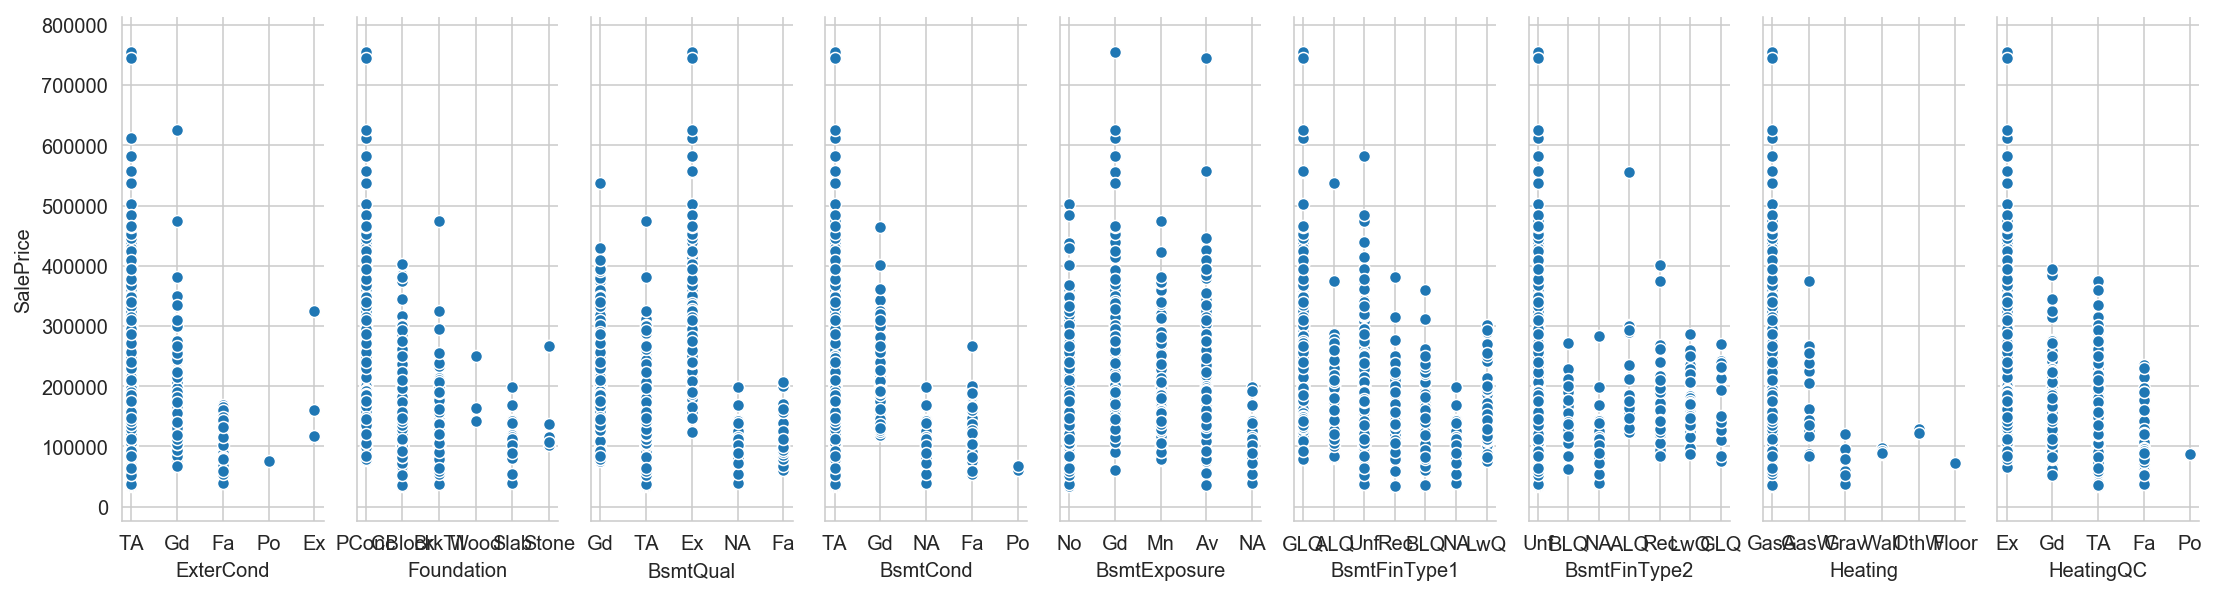

In [1300]:
plot= sns.pairplot(house, y_vars= ['SalePrice'], x_vars= discrete[19:28])
plot.fig.set_size_inches(15,5)

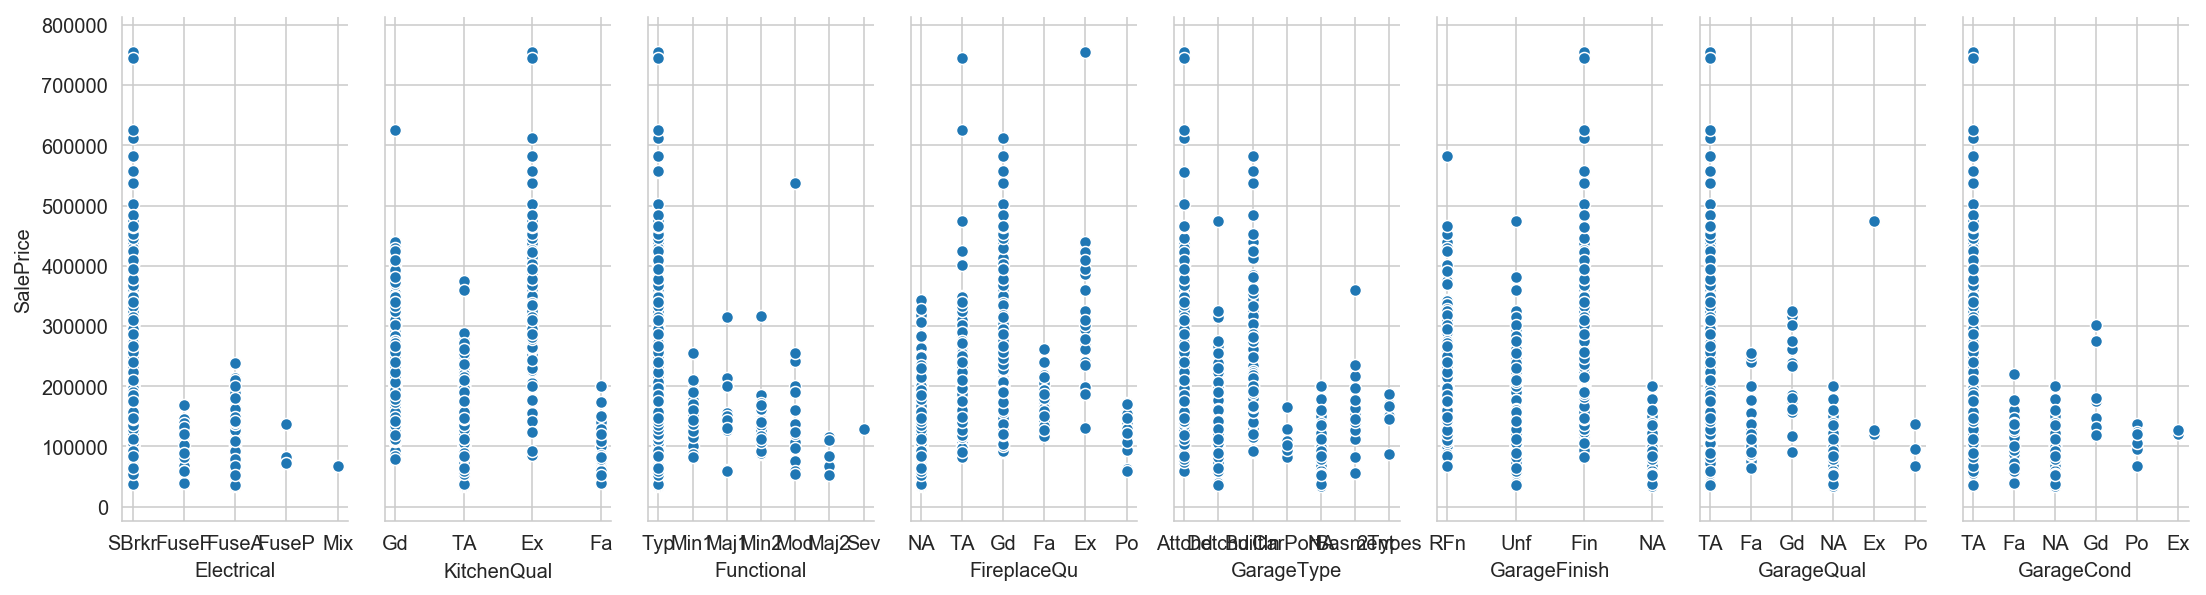

In [1301]:
plot= sns.pairplot(house, y_vars= ['SalePrice'], x_vars= discrete[29:37])
plot.fig.set_size_inches(15,5)

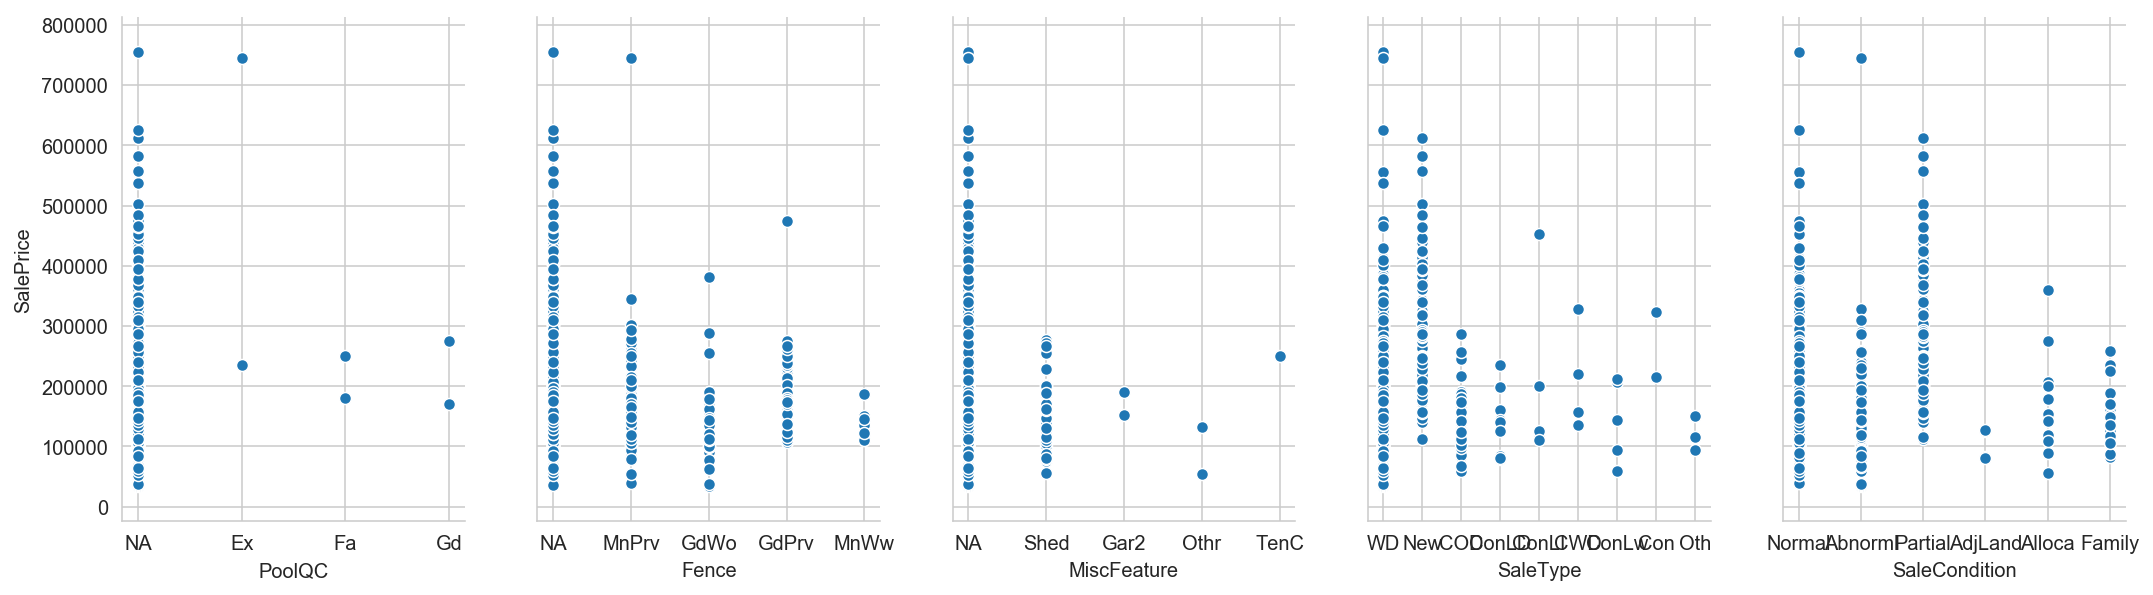

In [1302]:
plot= sns.pairplot(house, y_vars= ['SalePrice'], x_vars= discrete[38:43])
plot.fig.set_size_inches(15,5)

## Feature Selection

In [1303]:
#standardizesd in dataframe
p_convert= house_Continuous.copy()

predictor_convert=p_convert.apply(LabelEncoder().fit_transform) # to inverse, inverse_transform
min_residential = predictor_convert.min()
max_residential = predictor_convert.max()
predictor_standardized = (predictor_convert-min_residential)/(max_residential-min_residential)
display (predictor_standardized.head(2))

#dummies
predictor_dummies = pd.get_dummies(predictor_standardized)
predictor_dummies_convert=predictor_dummies.apply(LabelEncoder().fit_transform)
min_dummies = predictor_dummies_convert.min()
max_dummies = predictor_dummies_convert.max()
predictor_dummies_standardized = (predictor_dummies_convert-min_dummies)/(max_dummies-min_dummies)
display (predictor_dummies.head(2))

X=predictor_dummies.drop(['SalePrice'], axis=1)
y= house_Continuous.SalePrice.values

Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
0  0.000000    0.357143     0.330275  0.305607     0.666667        0.500   
1  0.000686    0.000000     0.467890  0.465421     0.555556        0.875   

   YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1    ...      EnclosedPorch  \
0   0.936937      0.883333    0.395062    0.569401    ...                0.0   
1   0.693694      0.433333    0.000000    0.760252    ...                0.0   

   3SsnPorch  ScreenPorch  PoolArea  MiscVal    MoSold  YrSold  SalePrice  \
0        0.0          0.0       0.0      0.0  0.090909    0.50   0.621785   
1        0.0          0.0       0.0      0.0  0.363636    0.25   0.512859   

   total_bath  house_age  
0        0.75   0.041322  
1        0.50   0.256198  

[2 rows x 40 columns]

Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
0  0.000000    0.357143     0.330275  0.305607     0.666667        0.500   
1  0.000686    0.000000     0.467890  0.465421     0.555556        0.875   

   YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1    ...      EnclosedPorch  \
0   0.936937      0.883333    0.395062    0.569401    ...                0.0   
1   0.693694      0.433333    0.000000    0.760252    ...                0.0   

   3SsnPorch  ScreenPorch  PoolArea  MiscVal    MoSold  YrSold  SalePrice  \
0        0.0          0.0       0.0      0.0  0.090909    0.50   0.621785   
1        0.0          0.0       0.0      0.0  0.363636    0.25   0.512859   

   total_bath  house_age  
0        0.75   0.041322  
1        0.50   0.256198  

[2 rows x 40 columns]

In [1304]:
X=predictor_dummies.drop(['SalePrice'], axis=1)
y= house_Continuous.SalePrice.values

X_train_fixed=X[house_Continuous.YrSold.isin([2006, 2007, 2008, 2009])]
X_test_fixed =X[house_Continuous.YrSold >= 2010]

y_train_fixed=y[house_Continuous.YrSold.isin([2006, 2007, 2008, 2009])]
y_test_fixed =y[house_Continuous.YrSold >= 2010]

X_train_fixed.shape,X_test_fixed.shape,y_train_fixed.shape,y_test_fixed.shape

((1283, 39), (175, 39), (1283,), (175,))

In [1305]:
cols = list(predictor_standardized.columns)
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# build the selector (we'll build one with each score type)
skb_f = SelectKBest(f_classif, k=5)
skb_chi2 = SelectKBest(chi2, k=5)

# train the selector on our data
skb_f.fit(X, y)
skb_chi2.fit(X, y)

# examine results
kbest = pd.DataFrame([cols, list(skb_f.scores_), list(skb_chi2.scores_)], 
                     index=['feature','f_classif','chi2 score']).T.sort_values('f_classif', ascending=False)
kbest.sort_values('chi2 score', ascending=False)

feature f_classif chi2 score
33       PoolArea   1.62638    603.008
32    ScreenPorch   1.07454    405.025
31      3SsnPorch  0.874362     391.12
34        MiscVal   1.11411    387.569
15   LowQualFinSF  0.815988    385.901
14       2ndFlrSF   1.95519    375.822
8      MasVnrArea   1.79897    370.548
10     BsmtFinSF2  0.872884    365.234
30  EnclosedPorch  0.792908    321.632
18   BsmtHalfBath   0.84765    298.146
9      BsmtFinSF1   1.78903    275.303
28     WoodDeckSF   1.25913    263.093
20       HalfBath   1.41585    260.417
29    OpenPorchSF   1.41491    252.356
38     total_bath   2.36014    196.139
24     Fireplaces   1.65838    189.755
1      MSSubClass  0.903322    185.744
27     GarageArea   2.76192    185.366
7    YearRemodAdd   1.83617    179.382
12    TotalBsmtSF   2.50049    178.396
16      GrLivArea   3.23821      177.5
36         YrSold   1.06964    166.589
13       1stFlrSF   2.19176    162.156
17   BsmtFullBath   1.14161    149.274
11      BsmtUnfSF   1.18972    147.713
3         LotArea   1.60442     142.64
0              Id  0.930526    106.067
6       YearBuilt   2.39972    99.6976
25    GarageYrBlt   2.14509    89.0224
37      SalePrice   2.91488    83.3473
26     GarageCars   2.85765    80.9886
35         MoSold   0.94621    79.8265
19       FullBath   2.66321    64.6689
2     LotFrontage   1.30865    59.3667
4     OverallQual   5.90027    49.9998
23   TotRmsAbvGrd   1.89449     46.708
21   BedroomAbvGr   1.24678    24.3867
5     OverallCond   1.10417    23.5975
22   KitchenAbvGr  0.876885    9.50463
39      house_age      None       None

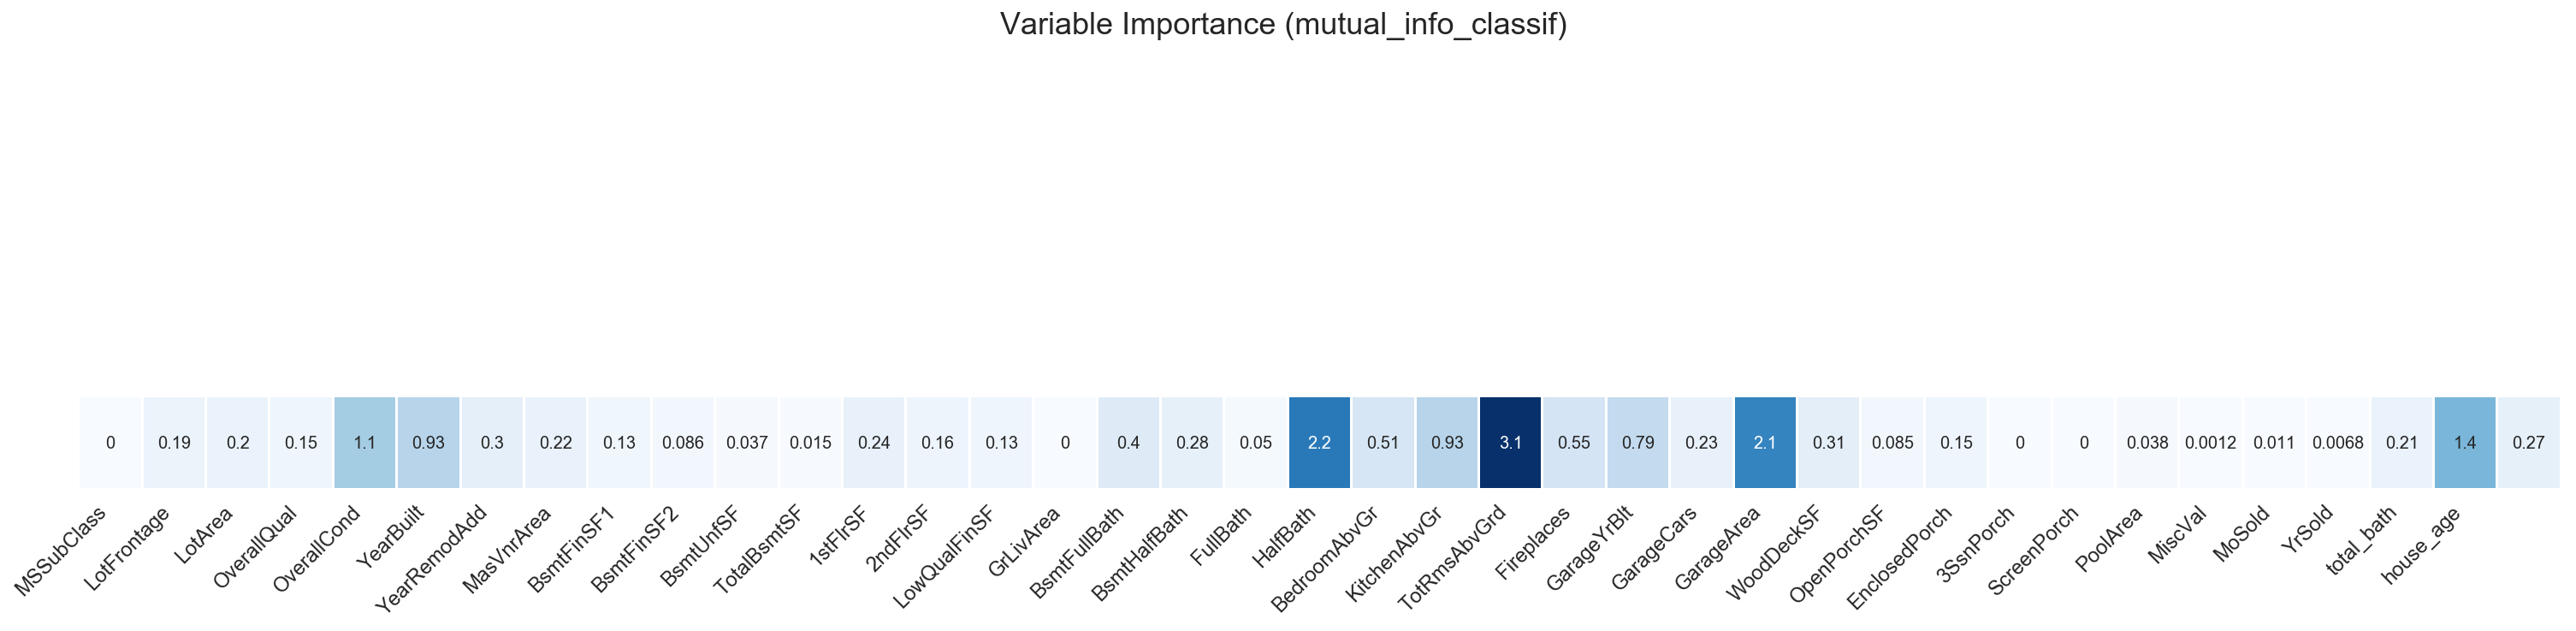

In [1306]:
#https://www.kaggle.com/residentmario/automated-feature-selection-with-sklearn
from sklearn.feature_selection import mutual_info_classif
kepler_mutual_information = mutual_info_classif(X, y)

plt.subplots(1, figsize=(26, 1))
sns.heatmap(kepler_mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(X.columns[1:], rotation=45, ha='right', fontsize=12)
plt.suptitle(" Variable Importance (mutual_info_classif)", fontsize=18, y=4)
plt.gcf().subplots_adjust(wspace=0.2)
pass

In [1307]:
from sklearn.feature_selection import GenericUnivariateSelect, chi2
trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=50)
kepler_X_trans = trans.fit_transform(X, y)

print("We started with {0} features but retained only {1} of them!".format(X.shape[1] - 1, kepler_X_trans.shape[1]))


We started with 38 features but retained only 19 of them!


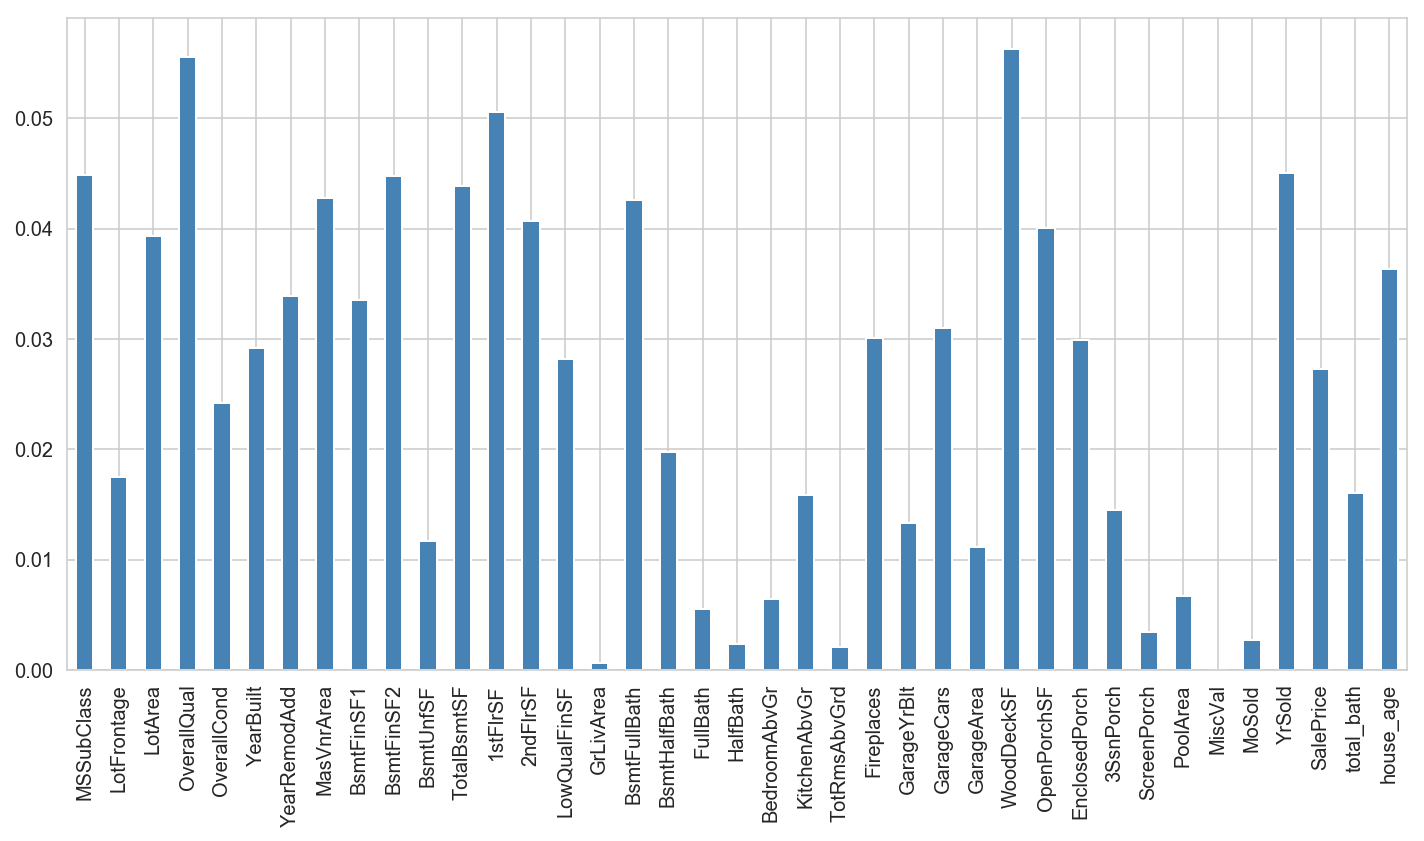

In [1308]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X, y)

pd.Series(clf.feature_importances_, index=predictor_standardized.columns[1:]).plot.bar(color='steelblue', figsize=(12, 6))

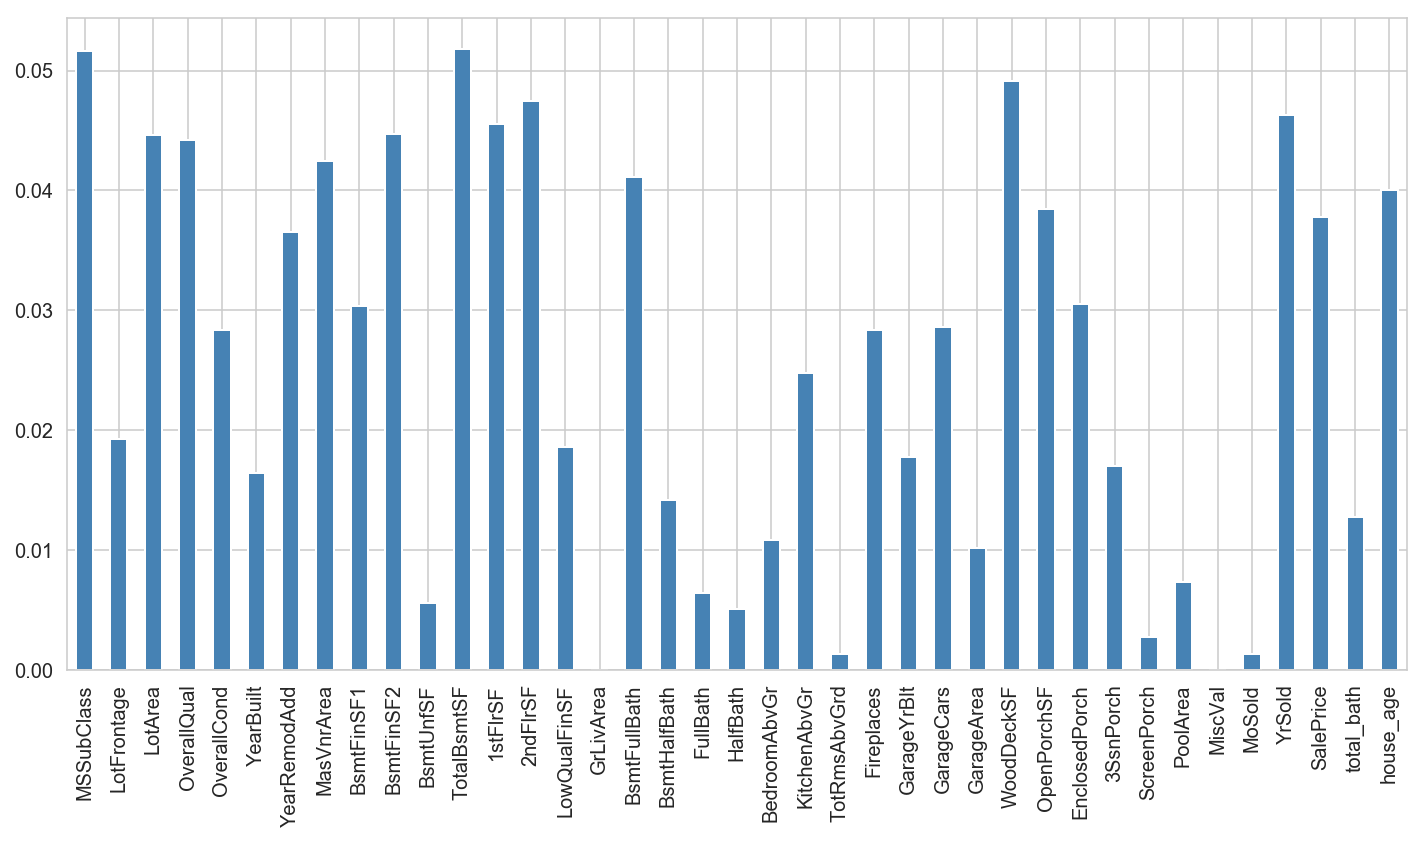

In [1309]:
lf = RandomForestClassifier()
clf.fit(X, y)

pd.Series(clf.feature_importances_, index=predictor_standardized.columns[1:]).plot.bar(color='steelblue', align='center',figsize=(12, 6))

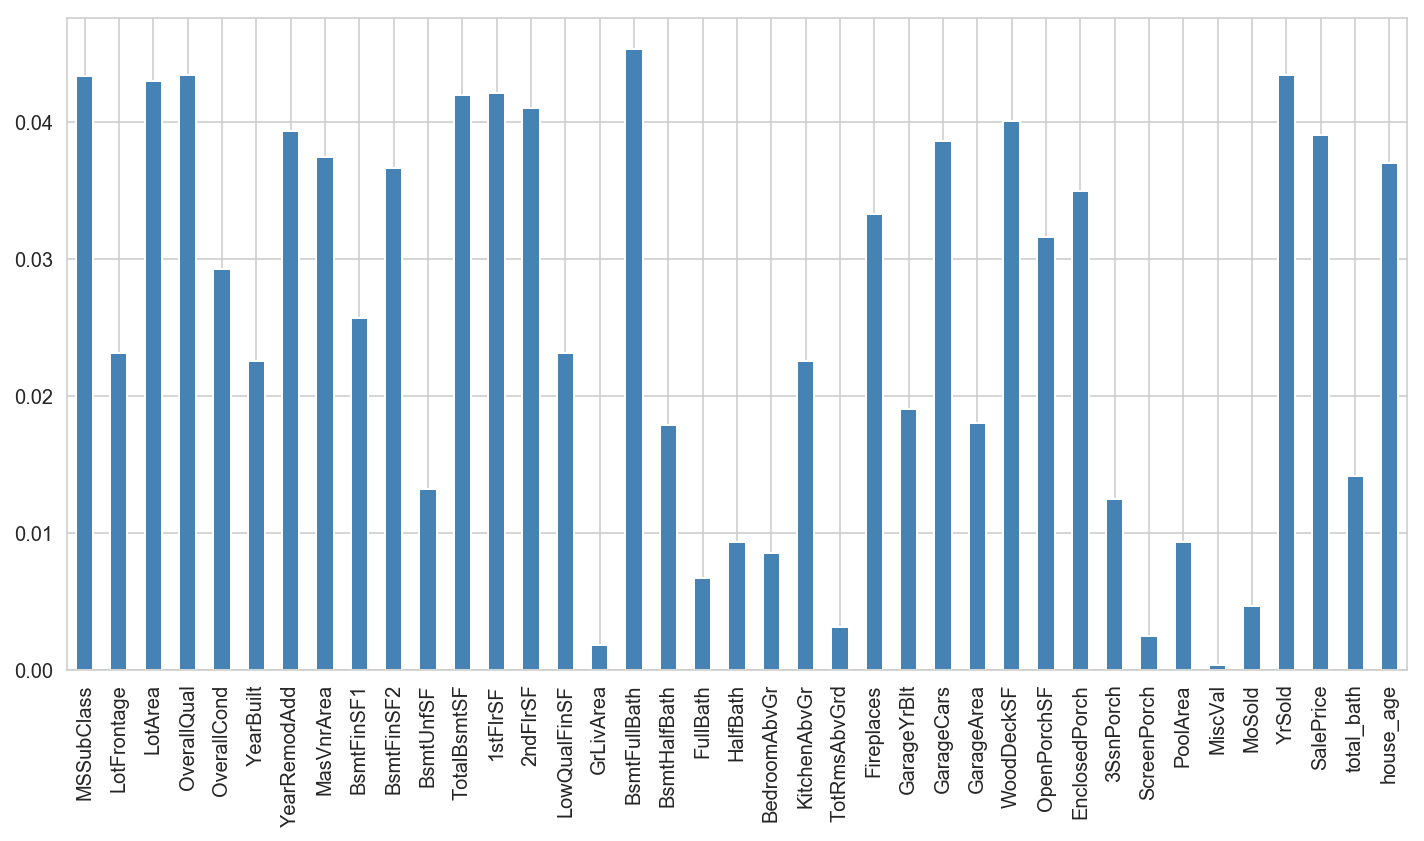

In [1310]:
from sklearn.tree import DecisionTreeClassifier

clf = ExtraTreesClassifier()
clf.fit(X, y)

pd.Series(clf.feature_importances_, index=predictor_standardized.columns[1:]).plot.bar(color='steelblue', figsize=(12, 6))

#### RFECV, SelectKbest, Lasso

In [1311]:
def feature_select_linear_reg(X, y, cv = 10):
    import pandas as pd
    import numpy as np
    # RFECV
    from sklearn.feature_selection import RFECV
    from sklearn.linear_model import LinearRegression

    lr = LinearRegression()

    selector = RFECV(lr, step = 1, cv = cv)
    selector = selector.fit(X, y)

    df_RFECV = pd.DataFrame({'variable_RFECV': X.columns.values.tolist(),
                            'support': selector.support_,
                            'ranking': selector.ranking_}).sort_values('ranking', ascending = True)
    df_RFECV.reset_index(drop = True, inplace = True)
    
    # SelectKbest
    from sklearn.feature_selection import SelectKBest, f_regression
    skb = SelectKBest(f_regression)

    skb.fit(X, y)

    df_skb = pd.DataFrame({'variable_skb': X.columns.values.tolist(),
                          'score': skb.scores_.tolist()}).sort_values('score', ascending = False)
    df_skb.reset_index(drop = True, inplace = True)
    
    # Lasso
    
    from sklearn.linear_model import Lasso, LassoCV
    optimal_lasso = LassoCV(n_alphas = 500, cv = cv, verbose = 1)
    optimal_lasso.fit(X, y)

    optimal_alpha = optimal_lasso.alpha_
    lasso_coef = optimal_lasso.coef_
    
    df_lasso = pd.DataFrame({'Variable_Lasso': X.columns.values.tolist(),
                            'Coefficients': lasso_coef.tolist(),
                            'CoeffAbs': abs(lasso_coef).tolist()}).sort_values('CoeffAbs', ascending = False)
    df_lasso.reset_index(drop = True, inplace = True)
    
    
    # combine all 3 dataframe
    df = pd.concat([df_RFECV, df_skb], axis = 1)
    df = pd.concat([df, df_lasso], axis = 1)
    
    return df

In [1312]:
feature_df = feature_select_linear_reg(X_train_fixed, y_train_fixed, cv = 10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [1313]:
feature_df.sort_values('Coefficients', ascending = False)

variable_RFECV  support  ranking   variable_skb        score  \
0        FullBath     True        1    OverallQual  2235.623231   
2        PoolArea     True        1     GarageArea   905.238562   
3     ScreenPorch     True        1     GarageCars   900.512025   
4      WoodDeckSF     True        1    TotalBsmtSF   794.217448   
6      Fireplaces     True        1     total_bath   630.456532   
7    TotRmsAbvGrd     True        1       FullBath   608.589347   
8    KitchenAbvGr     True        1   TotRmsAbvGrd   512.171287   
9    BedroomAbvGr     True        1      YearBuilt   499.331877   
10     total_bath     True        1      house_age   478.604257   
11   BsmtFullBath     True        1    GarageYrBlt   452.946449   
12       2ndFlrSF     True        1   YearRemodAdd   452.165319   
13      house_age     True        1     Fireplaces   371.998752   
14    TotalBsmtSF     True        1     MasVnrArea   344.317061   
15     MSSubClass     True        1        LotArea   336.865679   
16    LotFrontage     True        1    LotFrontage   218.029481   
17      BsmtUnfSF     True        1       2ndFlrSF   213.375030   
18        LotArea     True        1     BsmtFinSF1   188.595943   
20    OverallQual     True        1     WoodDeckSF   172.378498   
22     MasVnrArea     True        1   BsmtFullBath    71.614329   
23   YearRemodAdd     True        1      BsmtUnfSF    40.044320   
24      YearBuilt     True        1   BedroomAbvGr    39.375007   
25    OverallCond     True        1   KitchenAbvGr    22.117632   
26       1stFlrSF     True        1  EnclosedPorch    20.549919   
37             Id    False       12   BsmtHalfBath     0.259034   
31      GrLivArea    False        6      3SsnPorch     3.097991   
36   LowQualFinSF    False       11   LowQualFinSF     0.328879   
35       HalfBath    False       10         YrSold     0.826127   
34    GarageYrBlt    False        9             Id     1.386161   
33         YrSold    False        8     MSSubClass     2.274156   
32      3SsnPorch    False        7        MiscVal     2.495915   
38   BsmtHalfBath    False       13     BsmtFinSF2     0.211565   
30  EnclosedPorch    False        5         MoSold     3.174456   
29         MoSold    False        4    OverallCond     6.690860   
28    OpenPorchSF    False        3       PoolArea    10.146727   
27     GarageCars    False        2    ScreenPorch    17.132099   
21     BsmtFinSF1     True        1       HalfBath   111.532530   
19     BsmtFinSF2     True        1    OpenPorchSF   184.806864   
5      GarageArea     True        1       1stFlrSF   690.360665   
1         MiscVal     True        1      GrLivArea  1184.443725   

   Variable_Lasso   Coefficients       CoeffAbs  
0     OverallQual  167456.336858  167456.336858  
2    TotRmsAbvGrd   64303.002089   64303.002089  
3        2ndFlrSF   52155.964051   52155.964051  
4        PoolArea   49746.028431   49746.028431  
6     TotalBsmtSF   38007.417649   38007.417649  
7     OverallCond   33557.723649   33557.723649  
8        1stFlrSF   31366.352530   31366.352530  
9      BsmtFinSF1   25844.443651   25844.443651  
10     GarageArea   21373.077973   21373.077973  
11        LotArea   19999.176240   19999.176240  
12      YearBuilt   16169.776916   16169.776916  
13    LotFrontage   16044.066159   16044.066159  
14     Fireplaces   15320.007536   15320.007536  
15     MasVnrArea   12358.318966   12358.318966  
16   YearRemodAdd   12018.984436   12018.984436  
17       FullBath   11356.541657   11356.541657  
18     WoodDeckSF   11175.444185   11175.444185  
20   BsmtFullBath    8613.418020    8613.418020  
22     total_bath    8395.349352    8395.349352  
23    ScreenPorch    6387.670671    6387.670671  
24      GrLivArea    6205.536811    6205.536811  
25    OpenPorchSF    5509.484268    5509.484268  
26     GarageCars    5453.502547    5453.502547  
37     BsmtFinSF2      -0.000000       0.000000  
31      3SsnPorch       0.000000       0.000000  
36      BsmtUnfSF     

In [1314]:
lasso_columns = list(feature_df.loc[feature_df['Coefficients'] > 0, 'Variable_Lasso'])
print ('lasso_columns',len(lasso_columns))

skb_columns = list(feature_df.loc[feature_df['score'] > 10, 'variable_skb'])
print ('skb_columns',len(skb_columns))

rfecv_columns = list(feature_df.loc[feature_df['ranking'] < 10, 'variable_RFECV'])
print ('rfecv_columns',len(rfecv_columns))

lasso_columns 23
skb_columns 29
rfecv_columns 35


##  RFECV
#### Baseline

In [1315]:
#predictor set
X=predictor_dummies.drop(['SalePrice'], axis=1)
Xs=X_train_fixed[rfecv_columns]
y= y_train_fixed

#x=predictor_dummies.drop(['SalePrice'], axis=1)
#Y= predictor_standardized.loc[:,'SalePrice']

#Calculate the baseline accuracy
baseline = np.mean(1-Y)
print ('baseline mean score:',baseline)

baseline mean score: 0.5575789270527882


In [1316]:
import warnings
warnings.filterwarnings('ignore')
models = [
    LinearRegression(),
    BaggingRegressor(),
    ExtraTreesRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor()
]
CV = 14
entries = []
cv_d = pd.DataFrame(index=range(CV * len(models)))
for i,model in enumerate(models):
    print(i)
    model_name = model.__class__.__name__
    X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33, random_state=42)
    indexes = np.argsort(y_test)
    accuracies = cross_val_score(model, Xs, y, cv=CV)
    model.fit(X_train,y_train)
    model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    RMSE = np.sqrt(np.mean((y_test-y_pred)/y_test)**2)
    print( 'Model' ,model_name)
    print("R2 Cross-validated scores:", np.mean(accuracies))
    print('Score on Train:',  model.score(X_train, y_train))
    print('Score on Test:',  model.score(X_test, y_test))
    print('RMSE = {:.4f}'.format(RMSE))
    r,p = stats.pearsonr(y_test, y_pred)
    print('r2 = {:.4f}'.format(r**2))
    print('p = {:.4f}'.format(p))
    print('')
    
    
    #dataframe
    cv_ind = list(range(1,len(accuracies)+1))
    model_df = pd.DataFrame({'CV': cv_ind,'Accuracy': accuracies})
    model_df['model_name'] = model_name
    model_df = model_df[['model_name','CV', 'Accuracy']]
    if i == 0:
        cv_d = model_df
    else:
        cv_d = pd.concat([cv_d, model_df], axis = 0)
        
# for fold_idx, acc in enumerate(accuracies):
#     entries.append((model_name, fold_idx, acc))
#     cv_d = pd.DataFrame(entries, columns=['model_name', 'fold_idx','acc'])

0
Model LinearRegression
R2 Cross-validated scores: 0.8222401982519533
Score on Train: 0.8369013186634937
Score on Test: 0.8247658541481746
RMSE = 0.0100
r2 = 0.8284
p = 0.0000

1
Model BaggingRegressor
R2 Cross-validated scores: 0.862742369525402
Score on Train: 0.9756479320809299
Score on Test: 0.8504993962091695
RMSE = 0.0247
r2 = 0.8515
p = 0.0000

2
Model ExtraTreesRegressor
R2 Cross-validated scores: 0.8773583571817662
Score on Train: 1.0
Score on Test: 0.8605448855688906
RMSE = 0.0239
r2 = 0.8610
p = 0.0000

3
Model DecisionTreeRegressor
R2 Cross-validated scores: 0.761732361188779
Score on Train: 1.0
Score on Test: 0.7206689486417805
RMSE = 0.0228
r2 = 0.7538
p = 0.0000

4
Model RandomForestRegressor
R2 Cross-validated scores: 0.8668055436899548
Score on Train: 0.9766802060444438
Score on Test: 0.8425344202229306
RMSE = 0.0277
r2 = 0.8430
p = 0.0000



In [1317]:
cv_d.sort_values('Accuracy', ascending=False).head(22)

model_name  CV  Accuracy
8     ExtraTreesRegressor   9  0.909858
5        BaggingRegressor   6  0.909227
3   RandomForestRegressor   4  0.908241
3        BaggingRegressor   4  0.904543
0     ExtraTreesRegressor   1  0.901709
5     ExtraTreesRegressor   6  0.900667
5        LinearRegression   6  0.899337
13    ExtraTreesRegressor  14  0.895205
4   RandomForestRegressor   5  0.893305
7        BaggingRegressor   8  0.890043
8   RandomForestRegressor   9  0.889503
3     ExtraTreesRegressor   4  0.889429
4        BaggingRegressor   5  0.888553
4     ExtraTreesRegressor   5  0.886394
0   RandomForestRegressor   1  0.885713
9        BaggingRegressor  10  0.885274
13       BaggingRegressor  14  0.884766
11    ExtraTreesRegressor  12  0.884318
10  RandomForestRegressor  11  0.883185
11  RandomForestRegressor  12  0.881695
5   RandomForestRegressor   6  0.881591
7     ExtraTreesRegressor   8  0.881397

0.836762845011226
[0.84027628 0.84234282 0.84955201 0.87892663 0.77967882 0.82160708
 0.79557092 0.80564777 0.76250859 0.80234533]


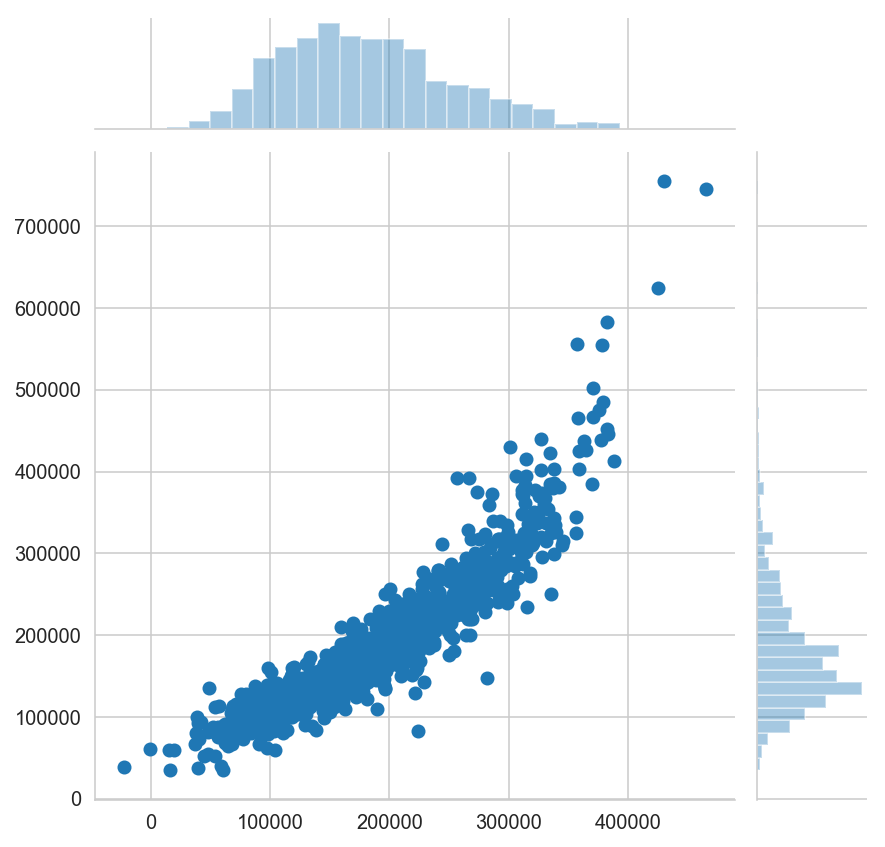

In [1318]:
lr=LinearRegression()

model = lr.fit(Xs,y)
print(model.score(Xs,y))
print(cross_val_score(model, Xs,y, cv= 10))
cross_val_score(model, Xs,y, cv= 10).mean()

sns.jointplot(lr.predict(Xs), y)

0.9762658589510362
[0.8509521  0.83883887 0.90595044 0.9049901  0.86279936 0.82743661
 0.84147343 0.83572907 0.90079681 0.8258334 ]


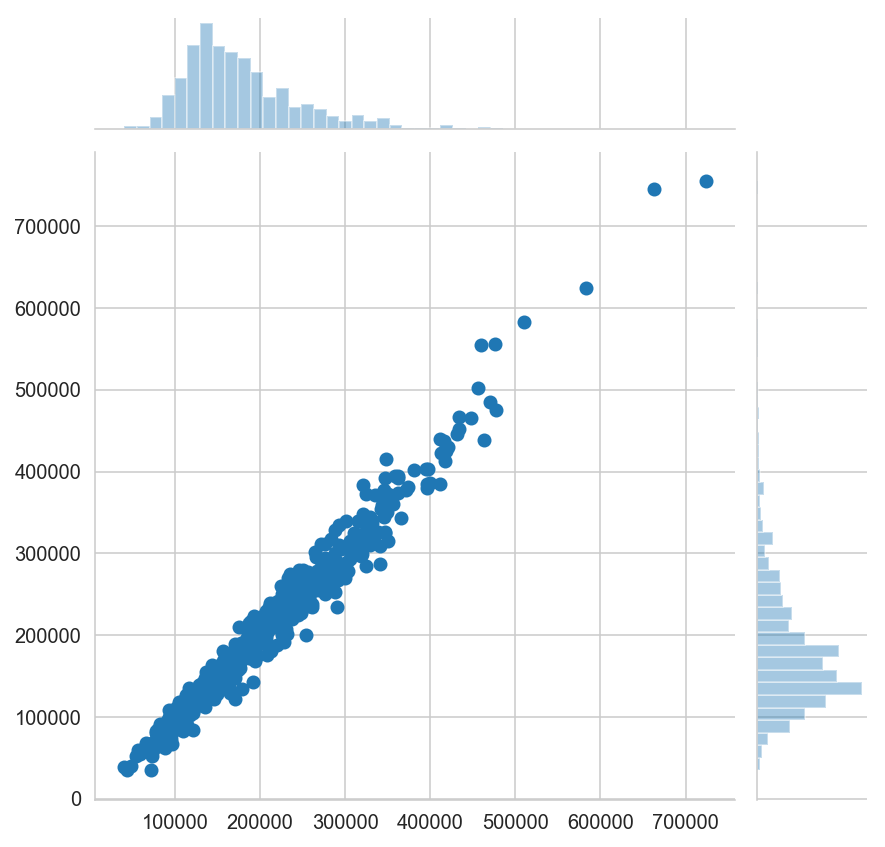

In [1319]:
br=BaggingRegressor()

model = br.fit(Xs,y)
print(model.score(Xs,y))
print(cross_val_score(model, Xs,y, cv= 10))
cross_val_score(model, Xs,y, cv= 10).mean()

sns.jointplot(br.predict(Xs), y)

0.9736686870933489
[0.84443303 0.83721568 0.89544068 0.87014598 0.84452824 0.89576715
 0.84298693 0.84887714 0.90950062 0.84083384]


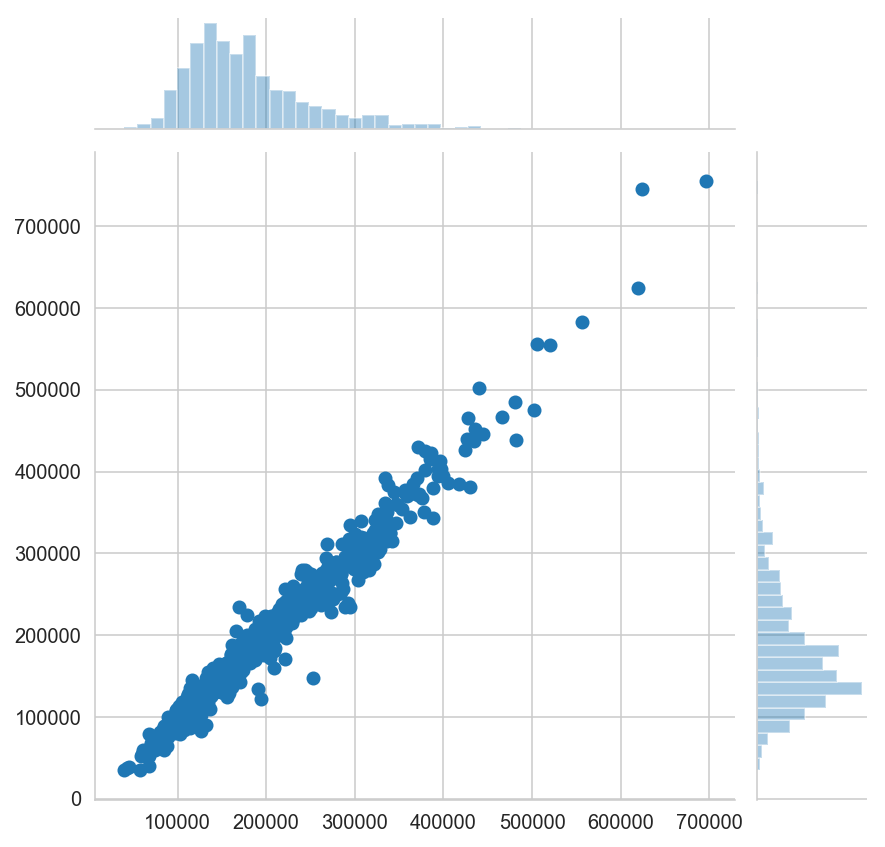

In [1320]:
rr=RandomForestRegressor()

model = rr.fit(Xs,y)
print(model.score(Xs,y))
print(cross_val_score(model, Xs,y, cv= 10))
cross_val_score(model, Xs,y, cv= 10).mean()

sns.jointplot(rr.predict(Xs), y)

0.9999957363551725
[0.84462623 0.88121268 0.87853582 0.8897587  0.87326922 0.91277979
 0.89675267 0.88170435 0.92802322 0.85227529]


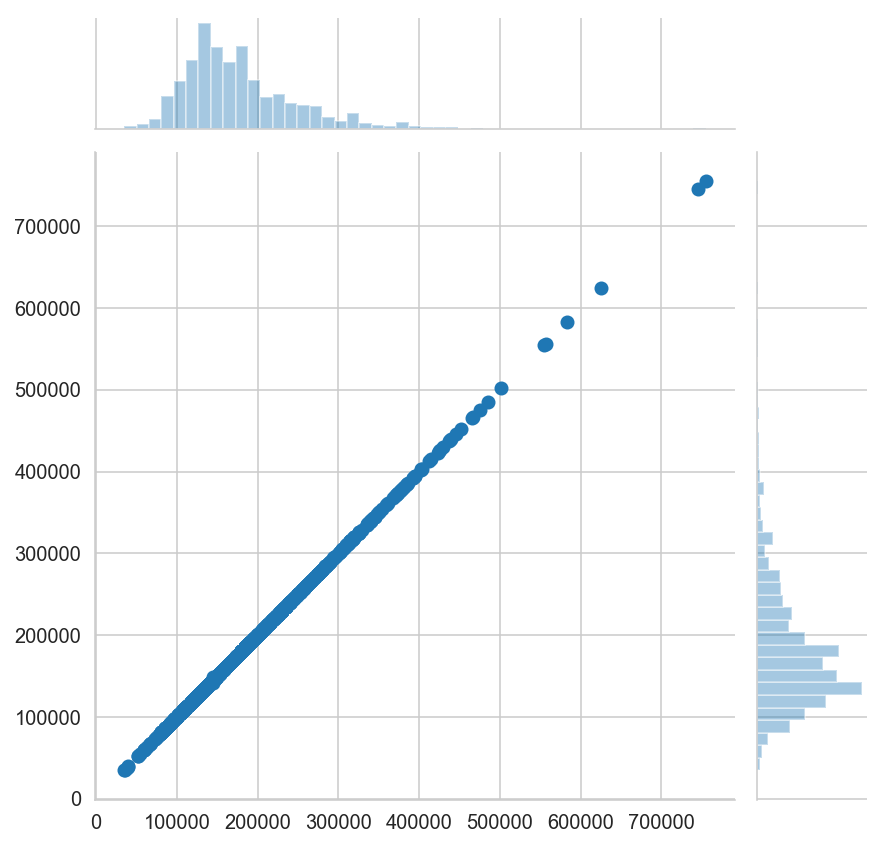

In [1321]:
et=ExtraTreesRegressor()
model = et.fit(Xs,y)
print(model.score(Xs,y))
print(cross_val_score(model, Xs,y, cv= 10))
cross_val_score(model, Xs,y, cv= 10).mean()

sns.jointplot(et.predict(Xs), y)

0.9762297442889073
[0.84350186 0.84580315 0.887938   0.87662746 0.84562133 0.88898011
 0.85923982 0.85929655 0.87438256 0.82695567]


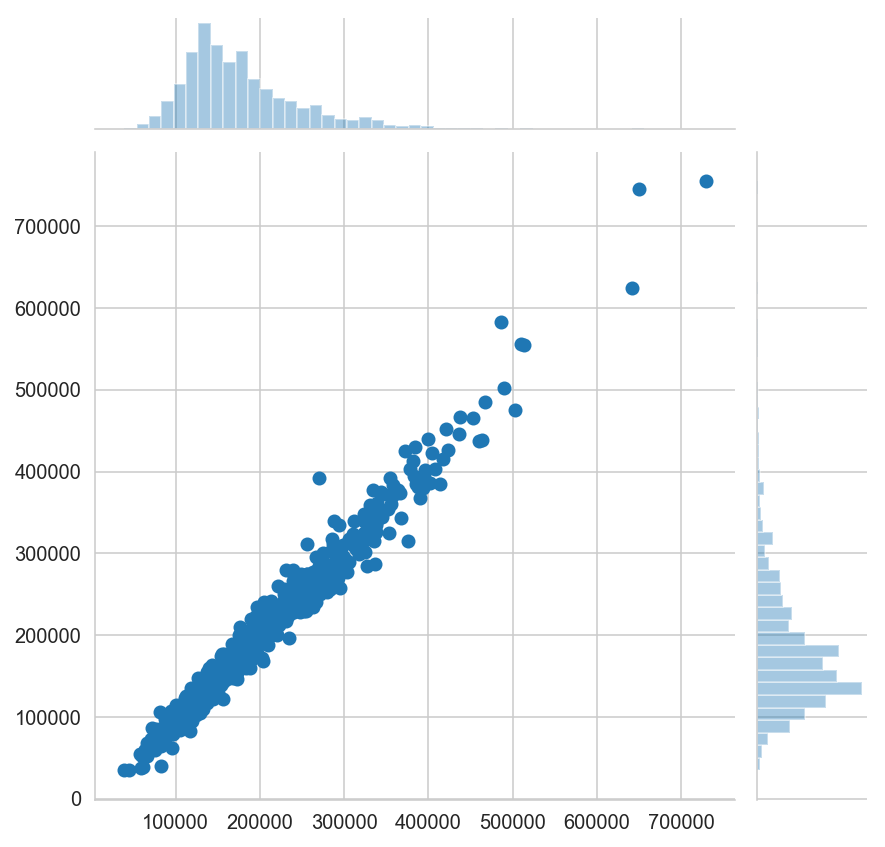

In [1322]:
rf=RandomForestRegressor()
model = rf.fit(Xs,y)
print(model.score(Xs,y))
print(cross_val_score(model, Xs,y, cv= 10))
cross_val_score(model, Xs,y, cv= 10).mean()

sns.jointplot(rf.predict(Xs), y)

0.9999957363551725
[0.69521792 0.71766998 0.78427752 0.77528566 0.74840061 0.77090047
 0.67009982 0.74198067 0.78086912 0.73464556]


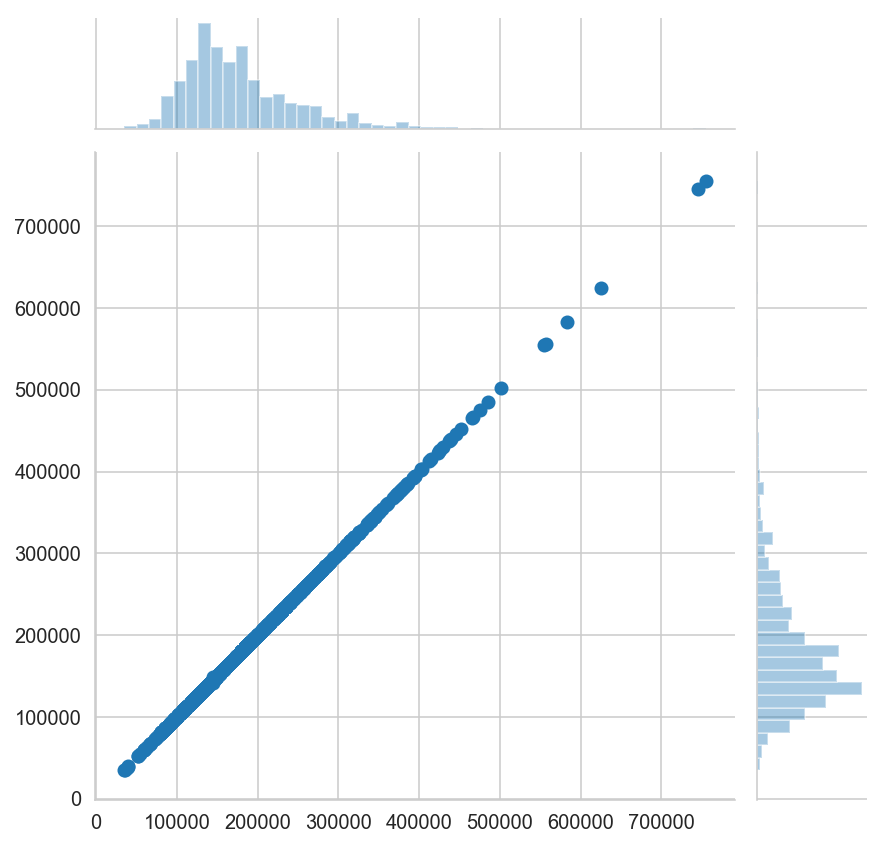

In [1323]:
dt=DecisionTreeRegressor() 
model = dt.fit(Xs,y)
print(model.score(Xs,y))
print(cross_val_score(model, Xs,y, cv= 10))
cross_val_score(model, Xs,y, cv= 10).mean()

sns.jointplot(dt.predict(Xs), y)

## Lasso 
#### Baseline

In [1324]:
#predictor set
X=predictor_dummies.drop(['SalePrice'], axis=1)
Xl= X_train_fixed[rfecv_columns]
y= y_train_fixed

#x=predictor_dummies.drop(['SalePrice'], axis=1)
#Y= predictor_standardized.loc[:,'SalePrice']

#Calculate the baseline accuracy
baseline = np.mean(1-Y)
print ('baseline mean score:',baseline)

baseline mean score: 0.5575789270527882


In [1325]:
import warnings
warnings.filterwarnings('ignore')
models = [
    LinearRegression(),
    BaggingRegressor(),
    ExtraTreesRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor()
]
CV = 14
entries = []
cv_d = pd.DataFrame(index=range(CV * len(models)))
for i,model in enumerate(models):
    print(i)
    model_name = model.__class__.__name__
    X_train, X_test, y_train, y_test = train_test_split(Xl, y, test_size=0.33, random_state=42)
    indexes = np.argsort(y_test)
    accuracies = cross_val_score(model, Xl, y, cv=CV)
    model.fit(X_train,y_train)
    model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    RMSE = np.sqrt(np.mean((y_test-y_pred)/y_test)**2)
    print( 'Model' ,model_name)
    print("R2 Cross-validated scores:", np.mean(accuracies))
    print('Score on Train:',  model.score(X_train, y_train))
    print('Score on Test:',  model.score(X_test, y_test))
    print('RMSE = {:.4f}'.format(RMSE))
    r,p = stats.pearsonr(y_test, y_pred)
    print('r2 = {:.4f}'.format(r**2))
    print('p = {:.4f}'.format(p))
    print('')
    
    
    #dataframe
    cv_ind = list(range(1,len(accuracies)+1))
    model_df = pd.DataFrame({'CV': cv_ind,'Accuracy': accuracies})
    model_df['model_name'] = model_name
    model_df = model_df[['model_name','CV', 'Accuracy']]
    if i == 0:
        cv_d = model_df
    else:
        cv_d = pd.concat([cv_d, model_df], axis = 0)
        
# for fold_idx, acc in enumerate(accuracies):
#     entries.append((model_name, fold_idx, acc))
#     cv_d = pd.DataFrame(entries, columns=['model_name', 'fold_idx','acc'])

0
Model LinearRegression
R2 Cross-validated scores: 0.8222401982519533
Score on Train: 0.8369013186634937
Score on Test: 0.8247658541481746
RMSE = 0.0100
r2 = 0.8284
p = 0.0000

1
Model BaggingRegressor
R2 Cross-validated scores: 0.8747640772748683
Score on Train: 0.9748079554787474
Score on Test: 0.8534839425631153
RMSE = 0.0299
r2 = 0.8537
p = 0.0000

2
Model ExtraTreesRegressor
R2 Cross-validated scores: 0.8759693348376818
Score on Train: 1.0
Score on Test: 0.8579830519571884
RMSE = 0.0346
r2 = 0.8587
p = 0.0000

3
Model DecisionTreeRegressor
R2 Cross-validated scores: 0.7501328024025657
Score on Train: 1.0
Score on Test: 0.7183141850103175
RMSE = 0.0250
r2 = 0.7459
p = 0.0000

4
Model RandomForestRegressor
R2 Cross-validated scores: 0.8635680975323652
Score on Train: 0.9738872250800836
Score on Test: 0.8367065566018463
RMSE = 0.0338
r2 = 0.8383
p = 0.0000



In [1326]:
cv_d.sort_values('Accuracy', ascending=False).head(22)

model_name  CV  Accuracy
7     ExtraTreesRegressor   8  0.935826
3        BaggingRegressor   4  0.925703
7        BaggingRegressor   8  0.915008
11    ExtraTreesRegressor  12  0.910036
3   RandomForestRegressor   4  0.907731
5        BaggingRegressor   6  0.907260
5        LinearRegression   6  0.899337
5   RandomForestRegressor   6  0.898766
9     ExtraTreesRegressor  10  0.898644
5     ExtraTreesRegressor   6  0.898571
6        BaggingRegressor   7  0.894150
13    ExtraTreesRegressor  14  0.893792
13       BaggingRegressor  14  0.892272
13  RandomForestRegressor  14  0.890980
11       BaggingRegressor  12  0.888081
3     ExtraTreesRegressor   4  0.887840
0     ExtraTreesRegressor   1  0.887214
4     ExtraTreesRegressor   5  0.883600
7   RandomForestRegressor   8  0.882960
10  RandomForestRegressor  11  0.881682
4        BaggingRegressor   5  0.880174
9        BaggingRegressor  10  0.879494

0.836762845011226
[0.84027628 0.84234282 0.84955201 0.87892663 0.77967882 0.82160708
 0.79557092 0.80564777 0.76250859 0.80234533]


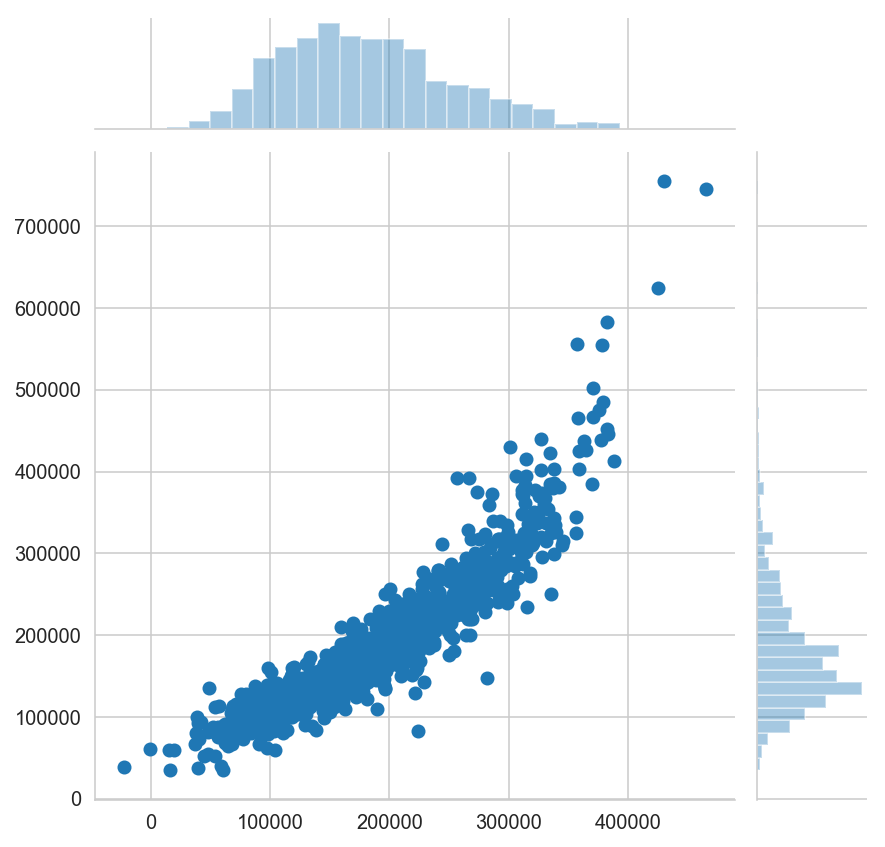

In [1327]:
lr=LinearRegression()
model = lr.fit(Xl,y)
print(model.score(Xl,y))
print(cross_val_score(model, Xl,y, cv= 10))
cross_val_score(model, Xl,y, cv= 10).mean()
sns.jointplot(lr.predict(Xl), y)

0.9780588317095021
[0.83592277 0.86300983 0.8814125  0.85019019 0.850864   0.87557098
 0.85306353 0.88740189 0.88412172 0.84381891]


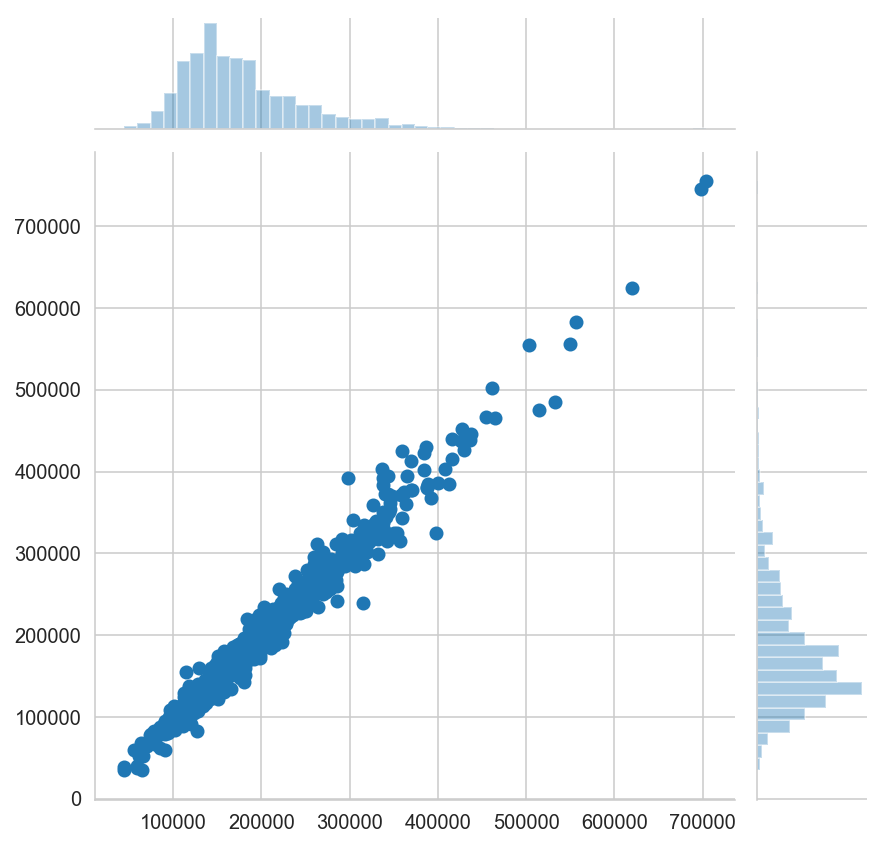

In [1328]:
br=BaggingRegressor()
model = br.fit(Xl,y)
print(model.score(Xl,y))
print(cross_val_score(model, Xl,y, cv= 10))
cross_val_score(model, Xl,y, cv= 10).mean()
sns.jointplot(br.predict(Xl), y)  

0.9752276655493117
[0.85762023 0.8554927  0.88489746 0.86728068 0.88281468 0.87971672
 0.86382947 0.87506102 0.88445315 0.82470683]


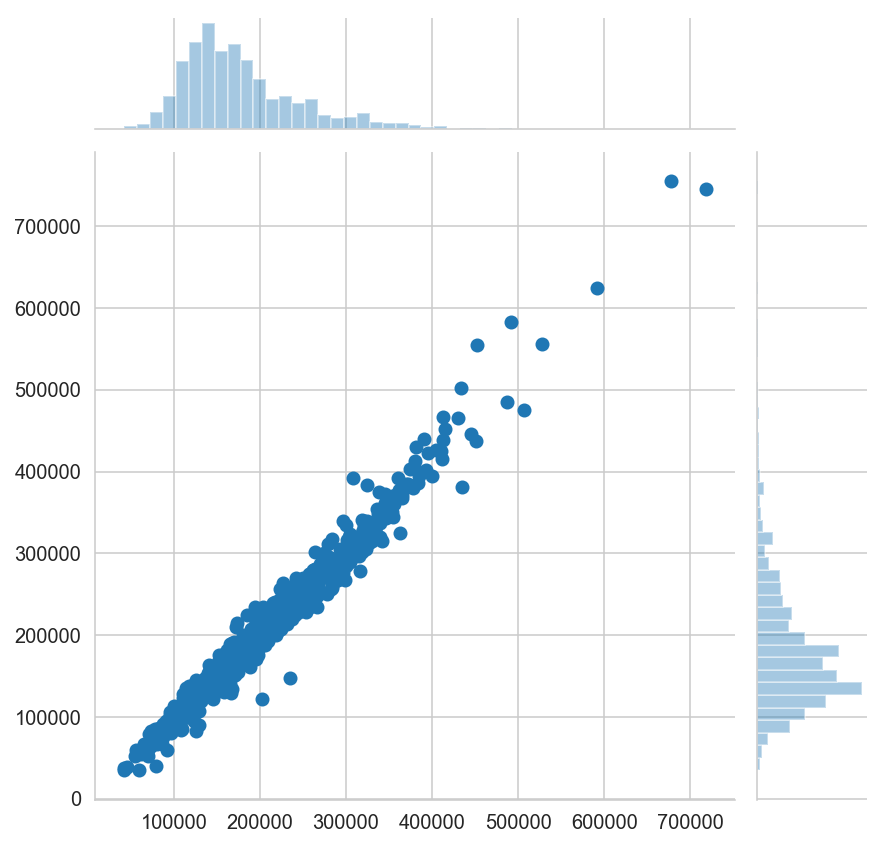

In [1329]:
rf=RandomForestRegressor()
model = rf.fit(Xl,y)
print(model.score(Xl,y))
print(cross_val_score(model, Xl,y, cv= 10))
cross_val_score(model, Xl,y, cv= 10).mean()
sns.jointplot(rf.predict(Xl), y)

0.9999957363551725
[0.87158277 0.86532646 0.86577114 0.87463598 0.87341444 0.9134758
 0.87122619 0.87665582 0.92836365 0.8523011 ]


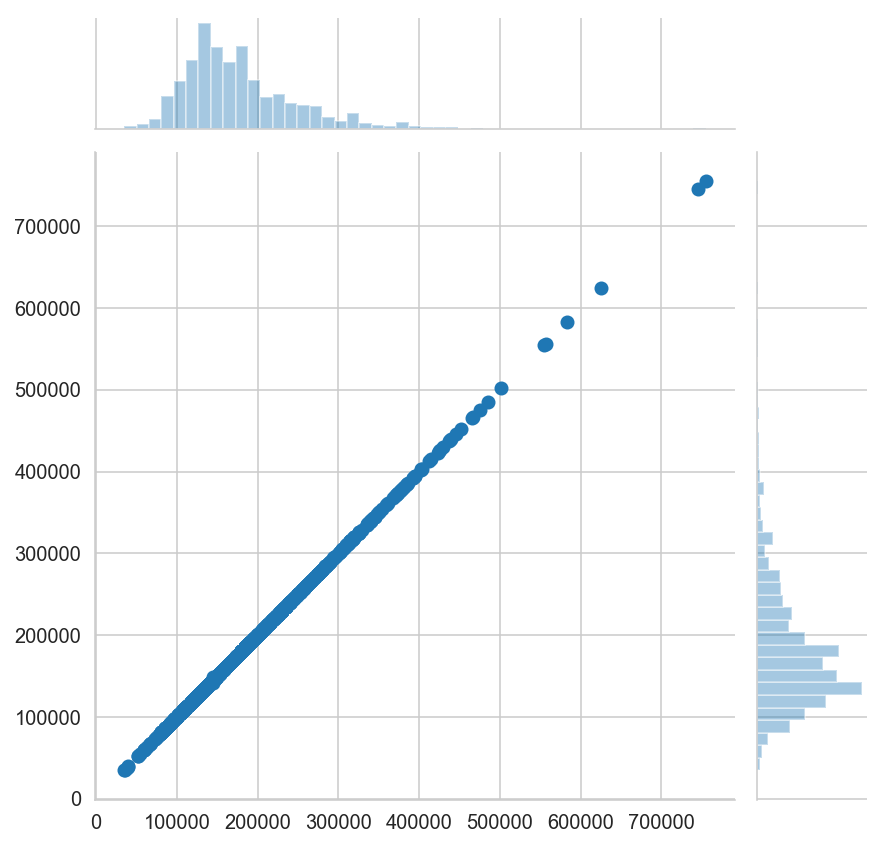

In [1330]:
et=ExtraTreesRegressor()
model = et.fit(Xl,y)
print(model.score(Xl,y))
print(cross_val_score(model, Xl,y, cv= 10))
cross_val_score(model, Xl,y, cv= 10).mean()
sns.jointplot(et.predict(Xl), y) 

0.9999957363551725
[0.71773513 0.72841708 0.7837339  0.77927953 0.76903459 0.78615904
 0.67420916 0.7073343  0.85841069 0.72003119]


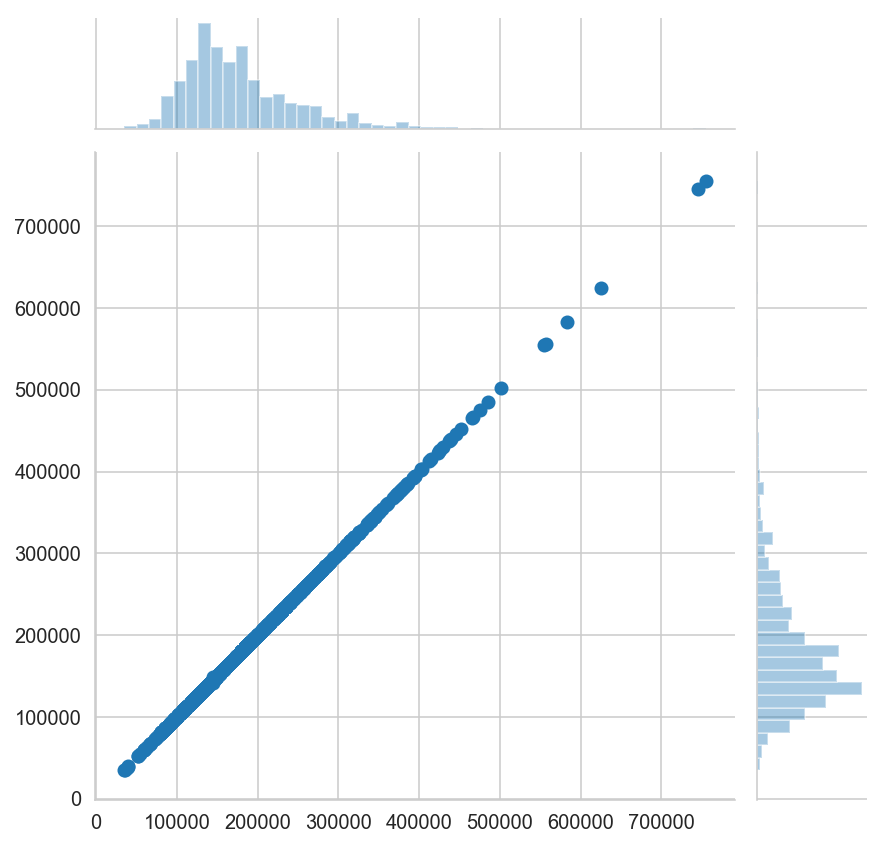

In [1331]:
dt=DecisionTreeRegressor()
model = dt.fit(Xl,y)
print(model.score(Xl,y))
print(cross_val_score(model, Xl,y, cv= 10))
cross_val_score(model, Xl,y, cv= 10).mean()
sns.jointplot(dt.predict(Xl), y)

#### SelectKbest

In [1332]:
#predictor set
X=predictor_dummies.drop(['SalePrice'], axis=1)
Xskb=X_train_fixed[skb_columns]
y= y_train_fixed

#x=predictor_dummies.drop(['SalePrice'], axis=1)
#Y= predictor_standardized.loc[:,'SalePrice']

#Calculate the baseline accuracy
baseline = np.mean(1-Y)
print ('baseline mean score:',baseline)

baseline mean score: 0.5575789270527882


In [1333]:
import warnings
warnings.filterwarnings('ignore')
models = [
    LinearRegression(),
    BaggingRegressor(),
    ExtraTreesRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor()
]
CV = 14
entries = []
cv_d = pd.DataFrame(index=range(CV * len(models)))
for i,model in enumerate(models):
    print(i)
    model_name = model.__class__.__name__
    X_train, X_test, y_train, y_test = train_test_split(Xskb, y, test_size=0.33, random_state=42)
    indexes = np.argsort(y_test)
    accuracies = cross_val_score(model, Xskb, y, cv=CV)
    model.fit(X_train,y_train)
    model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    RMSE = np.sqrt(np.mean((y_test-y_pred)/y_test)**2)
    print( 'Model' ,model_name)
    print("R2 Cross-validated scores:", np.mean(accuracies))
    print('Score on Train:',  model.score(X_train, y_train))
    print('Score on Test:',  model.score(X_test, y_test))
    print('RMSE = {:.4f}'.format(RMSE))
    r,p = stats.pearsonr(y_test, y_pred)
    print('r2 = {:.4f}'.format(r**2))
    print('p = {:.4f}'.format(p))
    print('')
    
    
    #dataframe
    cv_ind = list(range(1,len(accuracies)+1))
    model_df = pd.DataFrame({'CV': cv_ind,'Accuracy': accuracies})
    model_df['model_name'] = model_name
    model_df = model_df[['model_name','CV', 'Accuracy']]
    if i == 0:
        cv_d = model_df
    else:
        cv_d = pd.concat([cv_d, model_df], axis = 0)
        
# for fold_idx, acc in enumerate(accuracies):
#     entries.append((model_name, fold_idx, acc))
#     cv_d = pd.DataFrame(entries, columns=['model_name', 'fold_idx','acc'])

0
Model LinearRegression
R2 Cross-validated scores: 0.819800530465429
Score on Train: 0.8338131537645119
Score on Test: 0.8181390648993301
RMSE = 0.0105
r2 = 0.8226
p = 0.0000

1
Model BaggingRegressor
R2 Cross-validated scores: 0.8636383336367351
Score on Train: 0.9677551161562958
Score on Test: 0.8523967208796686
RMSE = 0.0340
r2 = 0.8537
p = 0.0000

2
Model ExtraTreesRegressor
R2 Cross-validated scores: 0.8687232842189941
Score on Train: 0.9999950171163695
Score on Test: 0.8545259782617602
RMSE = 0.0208
r2 = 0.8554
p = 0.0000

3
Model DecisionTreeRegressor
R2 Cross-validated scores: 0.7389222649812874
Score on Train: 0.9999950171163695
Score on Test: 0.7191308583104508
RMSE = 0.0237
r2 = 0.7479
p = 0.0000

4
Model RandomForestRegressor
R2 Cross-validated scores: 0.8646204794133637
Score on Train: 0.9773766856709007
Score on Test: 0.8552475123074739
RMSE = 0.0269
r2 = 0.8562
p = 0.0000



In [1334]:
cv_d.sort_values('Accuracy', ascending=False).head(22)

model_name  CV  Accuracy
11    ExtraTreesRegressor  12  0.929074
5     ExtraTreesRegressor   6  0.915031
7     ExtraTreesRegressor   8  0.908168
3     ExtraTreesRegressor   4  0.906213
5        BaggingRegressor   6  0.904307
5        LinearRegression   6  0.901281
3   RandomForestRegressor   4  0.900683
3        BaggingRegressor   4  0.900169
4   RandomForestRegressor   5  0.896222
4        BaggingRegressor   5  0.895607
11  RandomForestRegressor  12  0.893500
0        BaggingRegressor   1  0.892773
7        BaggingRegressor   8  0.892199
13  RandomForestRegressor  14  0.888461
13       BaggingRegressor  14  0.886505
9   RandomForestRegressor  10  0.885656
9     ExtraTreesRegressor  10  0.885306
11       BaggingRegressor  12  0.883210
13    ExtraTreesRegressor  14  0.882726
5   RandomForestRegressor   6  0.877930
4     ExtraTreesRegressor   5  0.877840
3        LinearRegression   4  0.876231

0.8325557566674431
[0.83466127 0.83530189 0.85994871 0.87586306 0.7804647  0.82418108
 0.80449241 0.78925788 0.76460707 0.79626991]


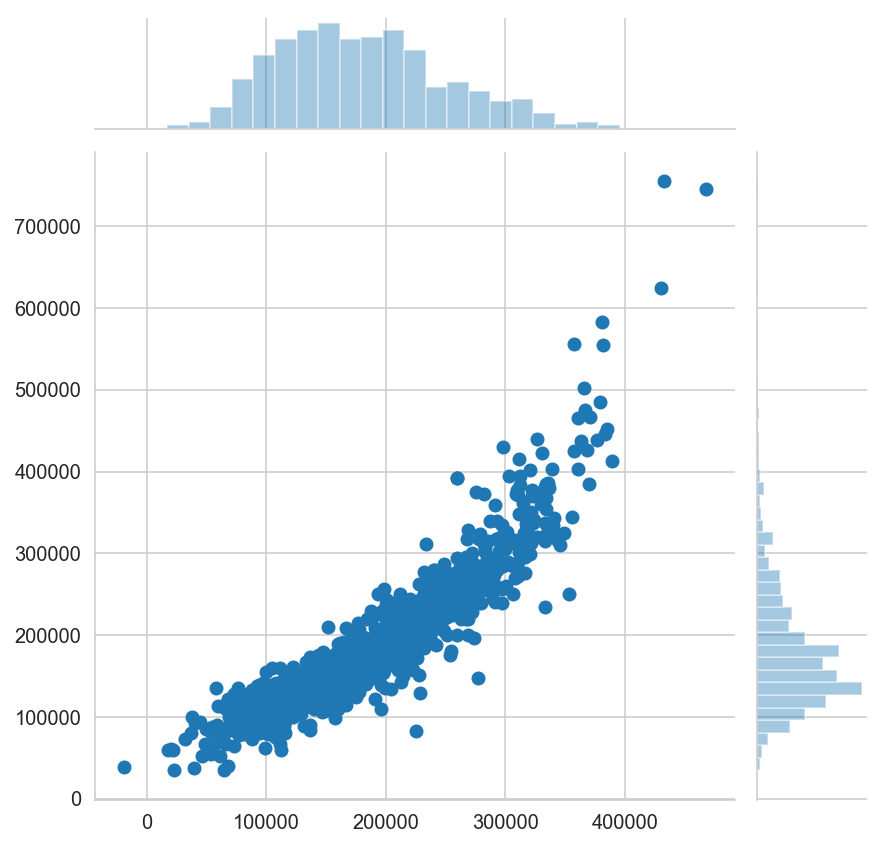

In [1335]:
Xskb=X_train_fixed[skb_columns]
y= y_train_fixed

lr= LinearRegression()
model = lr.fit(Xskb,y)
print(model.score(Xskb,y))
print(cross_val_score(model, Xskb,y, cv= 10))
model.score(X_test_fixed[skb_columns],y_test_fixed)
sns.jointplot(lr.predict(Xskb), y)

0.975587411885622
[0.83450246 0.82882712 0.89138509 0.8867327  0.85729951 0.88644669
 0.84311311 0.83038885 0.91228984 0.82151255]


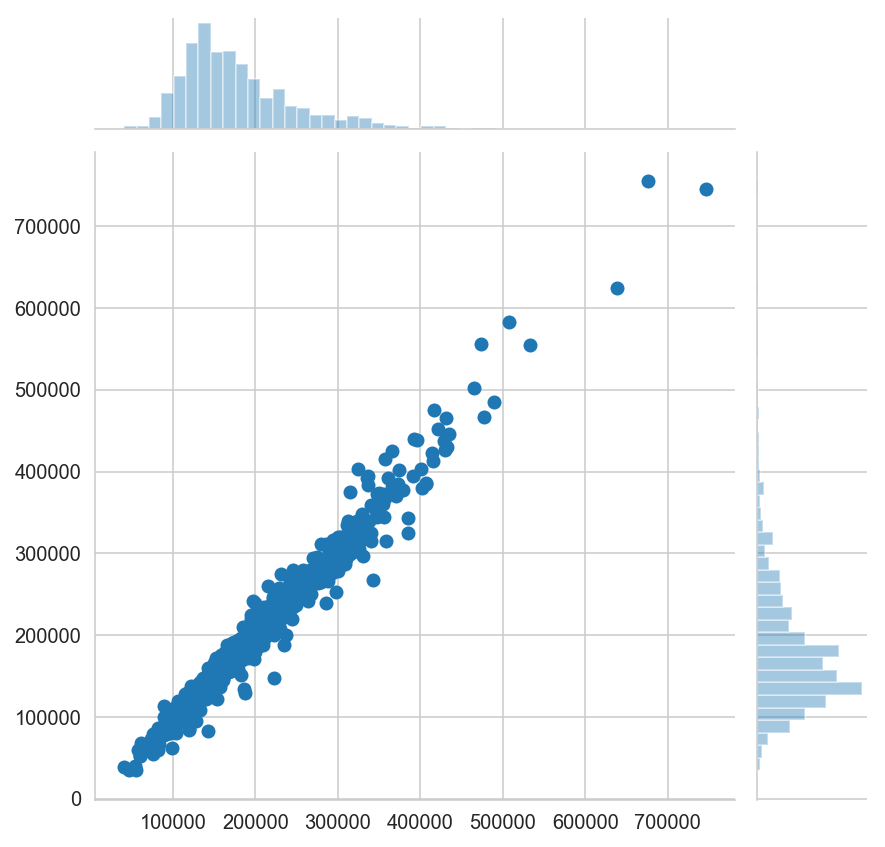

In [1336]:
model = br.fit(Xskb,y)
print(model.score(Xskb,y))
print(cross_val_score(model, Xskb,y, cv= 10))
model.score(X_test_fixed[skb_columns],y_test_fixed)
sns.jointplot(br.predict(Xskb), y)

0.9999893526407124
[0.83495647 0.86754329 0.88252919 0.8809443  0.86179038 0.89179824
 0.87016486 0.89270256 0.90886788 0.85373775]


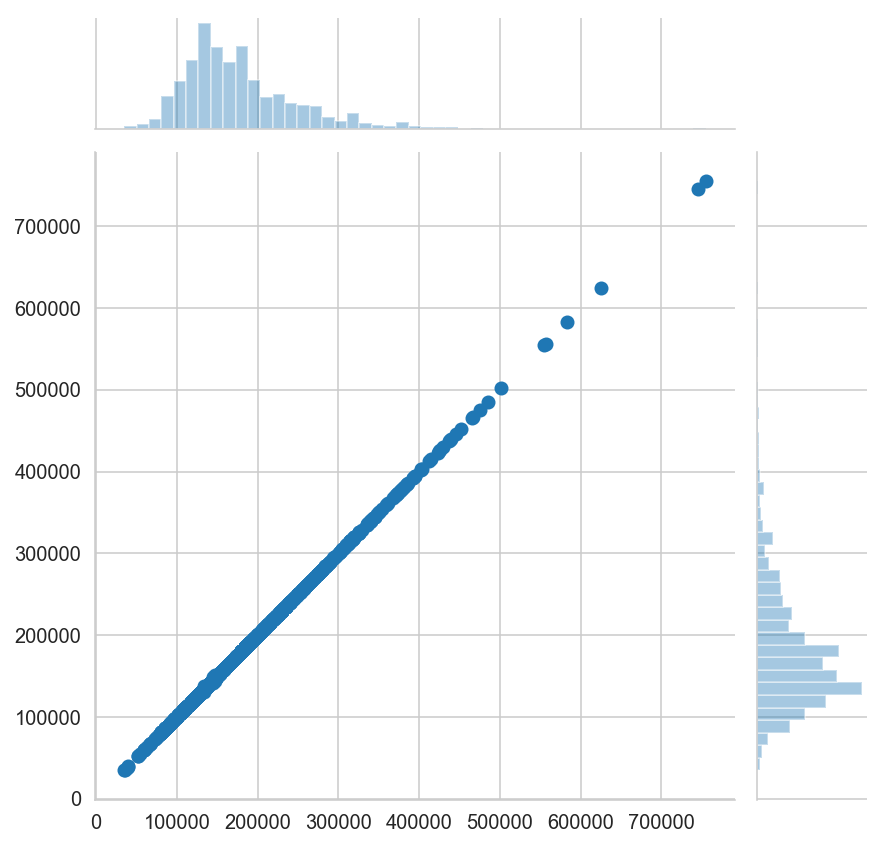

In [1337]:
model = et.fit(Xskb,y)
print(model.score(Xskb,y))
print(cross_val_score(model, Xskb,y, cv= 10))
model.score(X_test_fixed[skb_columns],y_test_fixed)
sns.jointplot(et.predict(Xskb), y)

0.9999893526407124
[0.70660849 0.7813536  0.76682722 0.75284463 0.78991014 0.7368795
 0.7362695  0.72645765 0.75642862 0.72227184]


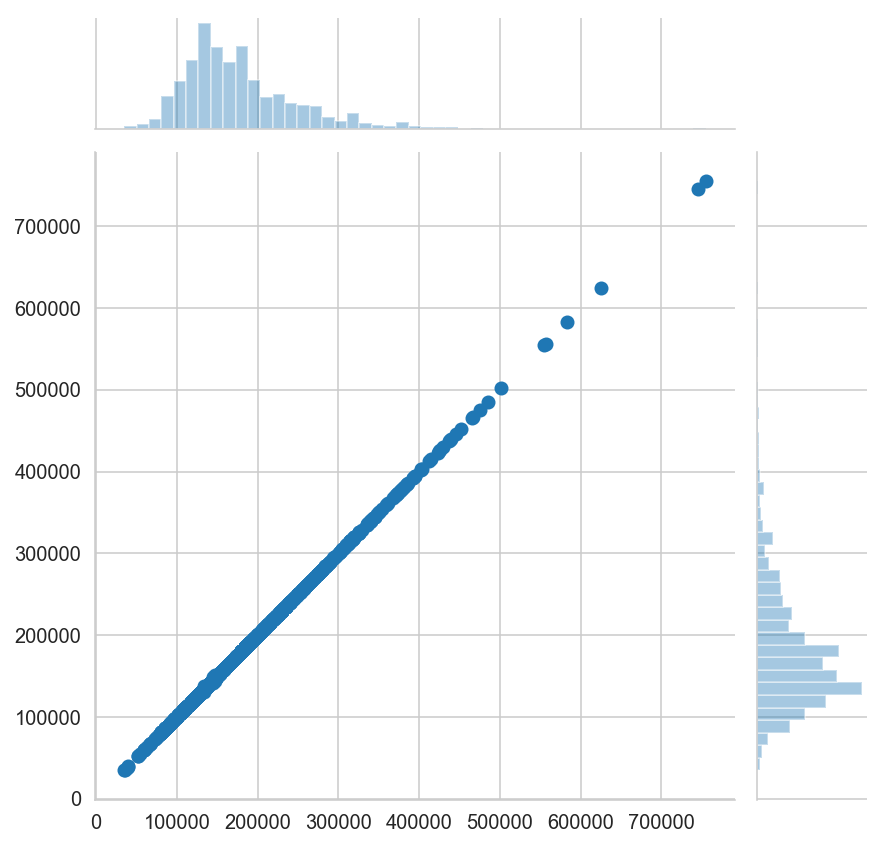

In [1338]:
model = dt.fit(Xskb,y)
print(model.score(Xskb,y))
print(cross_val_score(model, Xskb,y, cv= 10))
model.score(X_test_fixed[skb_columns],y_test_fixed)
sns.jointplot(dt.predict(Xskb), y)

0.9724428265630467
[0.81505564 0.856464   0.88757742 0.87684214 0.85541516 0.89406706
 0.84477228 0.86078791 0.88622784 0.84433887]


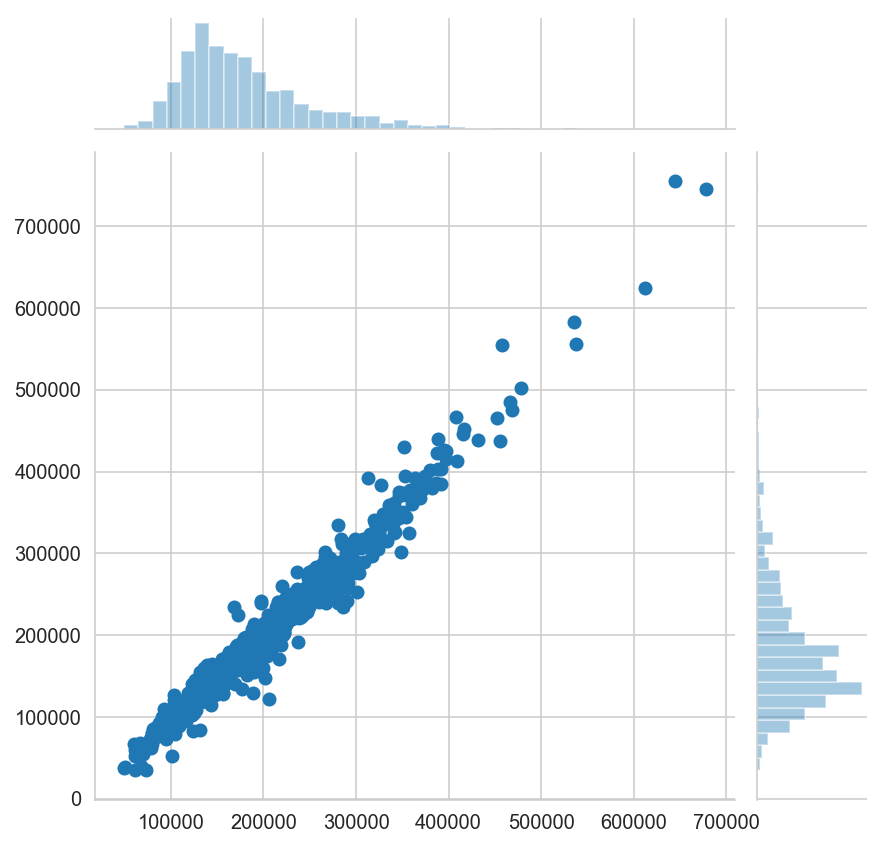

In [1339]:
model = rf.fit(Xskb,y)
print(model.score(Xskb,y))
print(cross_val_score(model, Xskb,y, cv= 10))
model.score(X_test_fixed[skb_columns],y_test_fixed)
sns.jointplot(rf.predict(Xskb), y)

## Gridsearch & Gradient decent 

In [1340]:
X=predictor_dummies.drop(['SalePrice'], axis=1)
y= house_Continuous.SalePrice.values

X_train_fixed=X[house_Continuous.YrSold.isin([2006, 2007, 2008, 2009])]
X_test_fixed =X[ house_Continuous.YrSold == 2010]

y_train_fixed=y[house_Continuous.YrSold.isin([2006, 2007, 2008, 2009])]
y_test_fixed =y[house_Continuous.YrSold == 2010]

X_train_fixed.shape,X_test_fixed.shape,y_train_fixed.shape,y_test_fixed.shape

((1283, 39), (175, 39), (1283,), (175,))

In [1341]:
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# set up my gridsearch parameters:
sgd_params = {
    'loss':['squared_loss'],
    'penalty':['l2','l1'],
    'alpha':np.arange(2,3,0.1),
    'l1_ratio': np.arange(1,100)/100
}

sgd_reg = SGDRegressor()
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=5, verbose=False, n_jobs= -1)

In [1342]:
rfc = RandomForestRegressor(n_estimators= 100, max_features= 'auto')
rfc.fit(X_train_fixed, y_train_fixed)
rfc.score(X_test_fixed, y_test_fixed)

0.8956481582321089

In [1343]:
# set up my gridsearch parameters:
rfg_params = {
    'n_estimators': np.arange(40,60,10),
    'max_depth': np.arange(10,30,10),
    'max_features':['auto','sqrt'],
    'max_leaf_nodes': np.arange(90,120,10),
    }

rfg = RandomForestRegressor()
rfg_gs = GridSearchCV(rfg, rfg_params, cv=5, verbose=False, n_jobs= -1)

In [1344]:
rfg_gs.fit(X_train_fixed, y_train_fixed)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': array([40, 50]), 'max_depth': array([10, 20]), 'max_features': ['auto', 'sqrt'], 'max_leaf_nodes': array([ 90, 100, 110])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

In [1345]:
print(rfg_gs.best_params_)
print(rfg_gs.best_score_)
print(rfg_gs.best_estimator_)
print(rfg_gs.score(X_test_fixed, y_test_fixed))

{'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 110, 'n_estimators': 50}
0.8812720424075585
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=110,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0.8948352570944398


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [1346]:
house_categorical.columns;

In [1347]:
house_cat= house[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition','MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition','SalePrice','YrSold']]

In [1348]:
house_cat.head(17)

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0        RL   Pave    NA      Reg         Lvl    AllPub    Inside       Gtl   
1        RL   Pave    NA      Reg         Lvl    AllPub       FR2       Gtl   
2        RL   Pave    NA      IR1         Lvl    AllPub    Inside       Gtl   
3        RL   Pave    NA      IR1         Lvl    AllPub    Corner       Gtl   
4        RL   Pave    NA      IR1         Lvl    AllPub       FR2       Gtl   
5        RL   Pave    NA      IR1         Lvl    AllPub    Inside       Gtl   
6        RL   Pave    NA      Reg         Lvl    AllPub    Inside       Gtl   
7        RL   Pave    NA      IR1         Lvl    AllPub    Corner       Gtl   
8        RM   Pave    NA      Reg         Lvl    AllPub    Inside       Gtl   
9        RL   Pave    NA      Reg         Lvl    AllPub    Corner       Gtl   
10       RL   Pave    NA      Reg         Lvl    AllPub    Inside       Gtl   
11       RL   Pave    NA      IR1         Lvl    AllPub    Inside       Gtl   
12       RL   Pave    NA      IR2         Lvl    AllPub    Inside       Gtl   
13       RL   Pave    NA      IR1         Lvl    AllPub    Inside       Gtl   
14       RL   Pave    NA      IR1         Lvl    AllPub    Corner       Gtl   
15       RM   Pave    NA      Reg         Lvl    AllPub    Corner       Gtl   
16       RL   Pave    NA      IR1         Lvl    AllPub   CulDSac       Gtl   

   Neighborhood Condition1  ...   GarageQual GarageCond PavedDrive PoolQC  \
0       CollgCr       Norm  ...           TA         TA          Y     NA   
1       Veenker      Feedr  ...           TA         TA          Y     NA   
2       CollgCr       Norm  ...           TA         TA          Y     NA   
3       Crawfor       Norm  ...           TA         TA          Y     NA   
4       NoRidge       Norm  ...           TA         TA          Y     NA   
5       Mitchel       Norm  ...           TA         TA          Y     NA   
6       Somerst       Norm  ...           TA         TA          Y     NA   
7        NWAmes       PosN  ...           TA         TA          Y     NA   
8       OldTown     Artery  ...           Fa         TA          Y     NA   
9       BrkSide     Artery  ...           Gd         TA          Y     NA   
10       Sawyer       Norm  ...           TA         TA          Y     NA   
11      NridgHt       Norm  ...           TA         TA          Y     NA   
12       Sawyer       Norm  ...           TA         TA          Y     NA   
13      CollgCr       Norm  ...           TA         TA          Y     NA   
14        NAmes       Norm  ...           TA         TA          Y     NA   
15      BrkSide       Norm  ...           TA         TA          Y     NA   
16        NAmes       Norm  ...           TA         TA          Y     NA   

    Fence MiscFeature SaleType SaleCondition SalePrice YrSold  
0      NA          NA       WD        Normal    208500   2008  
1      NA          NA       WD        Normal    181500   2007  
2      NA          NA       WD        Normal    223500   2008  
3      NA          NA       WD       Abnorml    140000   2006  
4      NA          NA       WD        Normal    250000   2008  
5   MnPrv        Shed       WD        Normal    143000   2009  
6      NA          NA       WD        Normal    307000   2007  
7      NA        Shed       WD        Normal    200000   2009  
8      NA          NA       WD       Abnorml    129900   2008  
9      NA          NA       WD        Normal    118000   2008  
10     NA          NA       WD        Normal    129500   2008  
11     NA          NA      New       Partial    345000   2006  
12     NA          NA       WD        Normal    144000   2008  
13     NA          NA      New       Partial    279500   2007  
14   GdWo          NA       WD        Normal    157000   2008  
15  GdPrv          NA       WD        Normal    132000   2007  
16     NA        Shed       WD        Normal    149000   2010  

[17 rows x 88 columns]

In [1349]:
house_non_fixed=house_cat.copy()
convert=house_non_fixed.apply(LabelEncoder().fit_transform) # to inverse, inverse_transform
min_re = convert.min()
max_re = convert.max()
reno_standardized = (convert-min_re)/(max_re-min_re)
reno_standardized_dummies = pd.get_dummies(reno_standardized)
reno_standardized_dummies.head(17)

MSZoning  Street  Alley  LotShape  LandContour  Utilities  LotConfig  \
0       0.75     1.0    0.5  1.000000          1.0        0.0       1.00   
1       0.75     1.0    0.5  1.000000          1.0        0.0       0.50   
2       0.75     1.0    0.5  0.000000          1.0        0.0       1.00   
3       0.75     1.0    0.5  0.000000          1.0        0.0       0.00   
4       0.75     1.0    0.5  0.000000          1.0        0.0       0.50   
5       0.75     1.0    0.5  0.000000          1.0        0.0       1.00   
6       0.75     1.0    0.5  1.000000          1.0        0.0       1.00   
7       0.75     1.0    0.5  0.000000          1.0        0.0       0.00   
8       1.00     1.0    0.5  1.000000          1.0        0.0       1.00   
9       0.75     1.0    0.5  1.000000          1.0        0.0       0.00   
10      0.75     1.0    0.5  1.000000          1.0        0.0       1.00   
11      0.75     1.0    0.5  0.000000          1.0        0.0       1.00   
12      0.75     1.0    0.5  0.333333          1.0        0.0       1.00   
13      0.75     1.0    0.5  0.000000          1.0        0.0       1.00   
14      0.75     1.0    0.5  0.000000          1.0        0.0       0.00   
15      1.00     1.0    0.5  1.000000          1.0        0.0       0.00   
16      0.75     1.0    0.5  0.000000          1.0        0.0       0.25   

    LandSlope  Neighborhood  Condition1   ...    GarageQual  GarageCond  \
0         0.0      0.208333       0.250   ...           1.0         1.0   
1         0.0      1.000000       0.125   ...           1.0         1.0   
2         0.0      0.208333       0.250   ...           1.0         1.0   
3         0.0      0.250000       0.250   ...           1.0         1.0   
4         0.0      0.625000       0.250   ...           1.0         1.0   
5         0.0      0.458333       0.250   ...           1.0         1.0   
6         0.0      0.875000       0.250   ...           1.0         1.0   
7         0.0      0.583333       0.500   ...           1.0         1.0   
8         0.0      0.708333       0.000   ...           0.2         1.0   
9         0.0      0.125000       0.000   ...           0.4         1.0   
10        0.0      0.791667       0.250   ...           1.0         1.0   
11        0.0      0.666667       0.250   ...           1.0         1.0   
12        0.0      0.791667       0.250   ...           1.0         1.0   
13        0.0      0.208333       0.250   ...           1.0         1.0   
14        0.0      0.500000       0.250   ...           1.0         1.0   
15        0.0      0.125000       0.250   ...           1.0         1.0   
16        0.0      0.500000       0.250   ...           1.0         1.0   

    PavedDrive  PoolQC  Fence  MiscFeature  SaleType  SaleCondition  \
0          1.0     1.0   1.00         0.25      1.00            0.8   
1          1.0     1.0   1.00         0.25      1.00            0.8   
2          1.0     1.0   1.00         0.25      1.00            0.8   
3          1.0     1.0   1.00         0.25      1.00            0.0   
4          1.0     1.0   1.00         0.25      1.00            0.8   
5          1.0     1.0   0.50         0.75      1.00            0.8   
6          1.0     1.0   1.00         0.25      1.00            0.8   
7          1.0     1.0   1.00         0.75      1.00            0.8   
8          1.0     1.0   1.00         0.25      1.00            0.0   
9          1.0     1.0   1.00         0.25      1.00            0.8   
10         1.0     1.0   1.00         0.25      1.00            0.8   
11         1.0     1.0   1.00         0.25      0.75            1.0   
12         1.0     1.0   1.00         0.25      1.00            0.8   
13         1.0     1.0   1.00         0.25      0.75            1.0   
14         1.0     1.0   0.25         0.25      1.00            0.8   
15         1.0     1.0   0.00         0.25      1.00            0.8   
16         1.0     1.0   1.00         0.75      1.00            0.8   

    S

In [1350]:
#house_non_fixed= pd.merge(house_categorical, house[['YrSold']], how='left', left_index= True, right_index= True)

In [1351]:
#house_non_fixed= pd.merge(house_categorical, house[['SalePrice']], how='left', left_index= True, right_index= True)

In [1352]:
# this list of column names will come in handly later.
cols = list(reno_standardized_dummies.columns)
cols.remove('SalePrice')
cols.remove('YrSold')

In [1353]:
X=reno_standardized_dummies[cols]
y=reno_standardized_dummies.SalePrice.values

X_train_non_fixed = reno_standardized_dummies.loc[reno_standardized_dummies['YrSold'] < 1.00,cols]
y_train_non_fixed = reno_standardized_dummies.loc[reno_standardized_dummies['YrSold'] < 1.00,'SalePrice']

X_test_non_fixed = reno_standardized_dummies.loc[reno_standardized_dummies['YrSold'] >= 1.00,cols]
y_test_non_fixed = reno_standardized_dummies.loc[reno_standardized_dummies['YrSold'] >= 1.00,'SalePrice']

X_train_non_fixed.shape,X_test_non_fixed.shape,y_train_non_fixed.shape,y_test_non_fixed .shape

((1283, 172), (175, 172), (1283,), (175,))

In [1354]:
feature_df= feature_select_linear_reg(X_train_non_fixed,y_train_non_fixed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [1355]:
feature_df.sort_values('Coefficients', ascending=False).head(22)

variable_RFECV  support  ranking  variable_skb       score Variable_Lasso  \
5       HeatingQC     True        1      BsmtQual  735.210991       RoofMatl   
6        SaleType     True        1      BsmtQual  735.210991     GarageCond   
7   SaleCondition     True        1      BsmtQual  735.210991      RoofStyle   
8        MSZoning     True        1   KitchenQual  582.123960    Exterior2nd   
9        MSZoning     True        1   KitchenQual  582.123960     Functional   
10         Street     True        1   KitchenQual  582.123960     HouseStyle   
11          Alley     True        1   KitchenQual  582.123960      LandSlope   
12          Alley     True        1    GarageType  461.819178     CentralAir   
13       LotShape     True        1    GarageType  461.819178  SaleCondition   
15    LandContour     True        1    GarageType  461.819178   Neighborhood   
22    Exterior1st     True        1     HeatingQC  320.671563          Alley   
23    Exterior1st     True        1     HeatingQC  320.671563     Condition1   
25   BsmtFinType2     True        1    Foundation  289.220274     MasVnrType   
27       SaleType     True        1    Foundation  289.220274      LandSlope   
28     MasVnrType     True        1    GarageCond  123.475677     PavedDrive   
29    Exterior1st     True        1    GarageCond  123.475677     Electrical   
33    LandContour     True        1    CentralAir  120.970141      ExterCond   
34       LotShape     True        1    CentralAir  120.970141       BsmtCond   
36          Alley     True        1      LotShape  120.276818        Heating   
37      LotConfig     True        1      LotShape  120.276818          Fence   
39         Street     True        1      LotShape  120.276818      RoofStyle   
40      Utilities     True        1  BsmtExposure  116.434366     GarageQual   

    Coefficients  CoeffAbs  
5       0.139862  0.139862  
6       0.119059  0.119059  
7       0.079582  0.079582  
8       0.074922  0.074922  
9       0.072281  0.072281  
10      0.071686  0.071686  
11      0.067909  0.067909  
12      0.063501  0.063501  
13      0.060303  0.060303  
15      0.057678  0.057678  
22      0.037638  0.037638  
23      0.036667  0.036667  
25      0.036368  0.036368  
27      0.032063  0.032063  
28      0.028331  0.028331  
29      0.021683  0.021683  
33      0.017345  0.017345  
34      0.016580  0.016580  
36      0.014102  0.014102  
37      0.014012  0.014012  
39      0.013704  0.013704  
40      0.012936  0.012936

In [1356]:
lasso_columns = list(feature_df.loc[feature_df['CoeffAbs'] > 0, 'Variable_Lasso'])
print('lasso_columns',len(lasso_columns))

skb_columns = list(feature_df.loc[feature_df['score'] > 10, 'variable_skb'])
print('skb_columns',len(skb_columns))

rfecv_columns = list(feature_df.loc[feature_df['ranking'] < 100, 'variable_RFECV'])
print('rfecv_columns',len(rfecv_columns))

lasso_columns 100
skb_columns 124
rfecv_columns 144


In [1357]:
#### RFECV

In [1358]:
X=reno_standardized_dummies.drop(['SalePrice', 'YrSold'], axis=1)
y= reno_standardized_dummies.SalePrice.values

In [1359]:
import warnings
warnings.filterwarnings('ignore')
models = [
    LinearRegression(),
    BaggingRegressor(),
    ExtraTreesRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor()
]
CV = 14
entries = []
cv_d = pd.DataFrame(index=range(CV * len(models)))
for i,model in enumerate(models):
    print(i)
    model_name = model.__class__.__name__
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    indexes = np.argsort(y_test)
    accuracies = cross_val_score(model, X, y, cv=CV)
    model.fit(X_train,y_train)
    model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    RMSE = np.sqrt(np.mean((y_test-y_pred)/y_test)**2)
    print( 'Model' ,model_name)
    print("R2 Cross-validated scores:", np.mean(accuracies))
    print('Score on Train:',  model.score(X_train, y_train))
    print('Score on Test:',  model.score(X_test, y_test))
    print('RMSE = {:.4f}'.format(RMSE))
    r,p = stats.pearsonr(y_test, y_pred)
    print('r2 = {:.4f}'.format(r**2))
    print('p = {:.4f}'.format(p))
    print('')
    
    
    #dataframe
    cv_ind = list(range(1,len(accuracies)+1))
    model_df = pd.DataFrame({'CV': cv_ind,'Accuracy': accuracies})
    model_df['model_name'] = model_name
    model_df = model_df[['model_name','CV', 'Accuracy']]
    if i == 0:
        cv_d = model_df
    else:
        cv_d = pd.concat([cv_d, model_df], axis = 0)
        
# for fold_idx, acc in enumerate(accuracies):
#     entries.append((model_name, fold_idx, acc))
#     cv_d = pd.DataFrame(entries, columns=['model_name', 'fold_idx','acc'])

0
Model LinearRegression
R2 Cross-validated scores: -3.8951177567967825e+21
Score on Train: 0.7092098730887519
Score on Test: 0.6706902884589612
RMSE = 0.4966
r2 = 0.6777
p = 0.0000

1
Model BaggingRegressor
R2 Cross-validated scores: 0.736446503826336
Score on Train: 0.9472789266731855
Score on Test: 0.7851529215149032
RMSE = 0.5800
r2 = 0.7853
p = 0.0000

2
Model ExtraTreesRegressor
R2 Cross-validated scores: 0.7536848208486708
Score on Train: 0.9996726080378364
Score on Test: 0.7513203153866147
RMSE = 0.6123
r2 = 0.7555
p = 0.0000

3
Model DecisionTreeRegressor
R2 Cross-validated scores: 0.56794065560268
Score on Train: 0.9996726080378364
Score on Test: 0.49838519630249445
RMSE = 0.4504
r2 = 0.5743
p = 0.0000

4
Model RandomForestRegressor
R2 Cross-validated scores: 0.7633443078814611
Score on Train: 0.9538436070453685
Score on Test: 0.7453997797291416
RMSE = 0.6815
r2 = 0.7456
p = 0.0000



In [1362]:
lr= LinearRegression()
model = rf.fit(X,y)
print(model.score(X,y))
print(cross_val_score(model, X, y, cv= 10))
cross_val_score(model, X, y, cv= 10).mean()

0.9565707924075026
[0.73734525 0.72057692 0.78322836 0.76053645 0.7571886  0.69069031
 0.78803131 0.75147913 0.74822567 0.72906579]


0.7601559244904074

In [1363]:
lr= LinearRegression()
model = lr.fit(X,y)
print(model.score(X_test_non_fixed[rfecv_columns],y_test_non_fixed))
print(cross_val_score(model, X_test_non_fixed[rfecv_columns],y_test_non_fixed, cv=10))
cross_val_score(model, X_test_non_fixed[rfecv_columns],y_test_non_fixed, cv=10).mean()

ValueError: shapes (175,576) and (86,) not aligned: 576 (dim 1) != 86 (dim 0)

In [ ]:
sns.jointplot(lr.predict(X_test_non_fixed[rfecv_columns]), y_test_non_fixed)

In [ ]:
et=ExtraTreesRegressor()
model = et.fit(Xx,yy)
print(model.score(Xx,yy))
#print(cross_val_score(model, Xx, yy, cv= 10))
print(cross_val_score(model, Xx, yy, cv= 10).mean())

model = et.fit(Xx,yy)
print(model.score(Xx,yy))
print(cross_val_score(model, Xx,yy, cv= 10))
model.score(X_test,y_test)
sns.jointplot(et.predict(Xx), yy)

In [ ]:
fixed this

In [1394]:
renovate_able=house[['OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd','ExterQual', 'ExterCond','BsmtQual', 'BsmtCond','Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual','Functional', 'Fireplaces', 'FireplaceQu','GarageQual','GarageCond', 'PoolQC','Fence','SalePrice']]
renovate_able.head(2)

OverallQual  OverallCond  YearRemodAdd RoofStyle RoofMatl Exterior1st  \
0            7            5          2003     Gable  CompShg     VinylSd   
1            6            8          1976     Gable  CompShg     MetalSd   

  Exterior2nd ExterQual ExterCond BsmtQual    ...    LowQualFinSF KitchenQual  \
0     VinylSd        Gd        TA       Gd    ...               0          Gd   
1     MetalSd        TA        TA       Gd    ...               0          TA   

  Functional Fireplaces FireplaceQu  GarageQual GarageCond PoolQC  Fence  \
0        Typ          0          NA          TA         TA     NA     NA   
1        Typ          1          TA          TA         TA     NA     NA   

  SalePrice  
0    208500  
1    181500  

[2 rows x 25 columns]

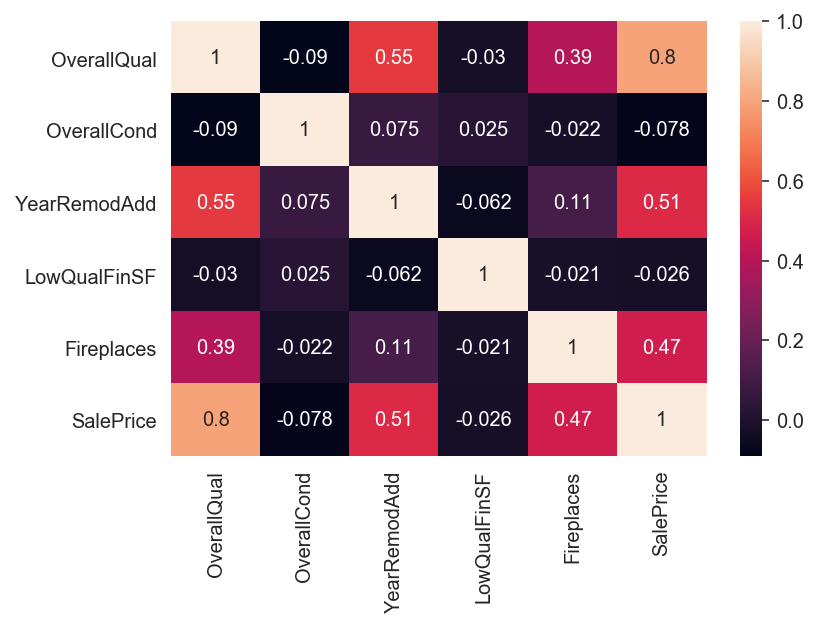

In [1395]:
corr = renovate_able.corr()
sns.heatmap(corr, annot=True)

In [1396]:
convert=renovate_able.apply(LabelEncoder().fit_transform) # to inverse, inverse_transform
display (convert.head(2))

min_re = convert.min()
max_re = convert.max()
reno_standardized = (convert-min_re)/(max_re-min_re)
display (reno_standardized.head(2))

#predictor set
X=reno_standardized.drop(['SalePrice'], axis=1).values
y= renovate_able.loc[:,'SalePrice'].values
Y= renovate_able.loc[:,'SalePrice']


(Y.value_counts()/Y.sum()).describe()

OverallQual  OverallCond  YearRemodAdd  RoofStyle  RoofMatl  Exterior1st  \
0            6            4            53          1         0           12   
1            5            7            26          1         0            8   

   Exterior2nd  ExterQual  ExterCond  BsmtQual    ...      LowQualFinSF  \
0           13          2          4         2    ...                 0   
1            8          3          4         2    ...                 0   

   KitchenQual  Functional  Fireplaces  FireplaceQu  GarageQual  GarageCond  \
0            2           6           0            3           5           5   
1            3           6           1            5           5           5   

   PoolQC  Fence  SalePrice  
0       3      4        411  
1       3      4        339  

[2 rows x 25 columns]

OverallQual  OverallCond  YearRemodAdd  RoofStyle  RoofMatl  Exterior1st  \
0     0.666667        0.500      0.883333        0.2       0.0     0.857143   
1     0.555556        0.875      0.433333        0.2       0.0     0.571429   

   Exterior2nd  ExterQual  ExterCond  BsmtQual    ...      LowQualFinSF  \
0     0.866667   0.666667        1.0       0.5    ...               0.0   
1     0.533333   1.000000        1.0       0.5    ...               0.0   

   KitchenQual  Functional  Fireplaces  FireplaceQu  GarageQual  GarageCond  \
0     0.666667         1.0    0.000000          0.6         1.0         1.0   
1     1.000000         1.0    0.333333          1.0         1.0         1.0   

   PoolQC  Fence  SalePrice  
0     1.0    1.0   0.621785  
1     1.0    1.0   0.512859  

[2 rows x 25 columns]

count    6.620000e+02
mean     8.348807e-09
std      8.766198e-09
min      3.790748e-09
25%      3.790748e-09
50%      3.790748e-09
75%      1.137224e-08
max      7.581496e-08
Name: SalePrice, dtype: float64

In [1397]:
# iterate through folds 5-10 (best 5,13)
#for folds in range(5,12):
folds=14
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
indexes = np.argsort(y_test)
    
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=folds)
model.fit(X_train,y_train)
model.score(X_test, y_test)
predictions  =  model.predict(X)  
y_pred = model.predict(X_test)
RMSE = np.sqrt(np.mean((y_test-y_pred)/y_test)**2)


print('K:', folds)
print( 'Model' ,model)
print('')
print('Score on Train:',  model.score(X_train, y_train))
print('Score on Test:',  model.score(X_test, y_test))
print("R2 Cross-validated scores:", np.mean(scores))
print('RMSE = {:.4f}'.format(RMSE))
r,p = stats.pearsonr(y_test, y_pred)
print('r2 = {:.4f}'.format(r**2))
print('p = {:.4f}'.format(p))

K: 14
Model LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Score on Train: 0.7536608964166754
Score on Test: 0.6963119487591461
R2 Cross-validated scores: 0.7267788033466062
RMSE = 0.0384
r2 = 0.7007
p = 0.0000


In [1398]:
# iterate through folds 5-10 (best 5,13)
#for folds in range(5,12):
folds=14
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
indexes = np.argsort(y_test)
    
model = RidgeCV()
scores = cross_val_score(model, X, y, cv=folds)
model.fit(X_train,y_train)
model.score(X_test, y_test)
predictions  =  model.predict(X)  
y_pred = model.predict(X_test)
RMSE = np.sqrt(np.mean((y_test-y_pred)/y_test)**2)


print('K:', folds)
print( 'Model' ,model)
print('')
print('Score on Train:',  model.score(X_train, y_train))
print('Score on Test:',  model.score(X_test, y_test))
print("R2 Cross-validated scores:", np.mean(scores))
print('RMSE = {:.4f}'.format(RMSE))
r,p = stats.pearsonr(y_test, y_pred)
print('r2 = {:.4f}'.format(r**2))
print('p = {:.4f}'.format(p))

K: 14
Model RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

Score on Train: 0.753086051656185
Score on Test: 0.6973359228481764
R2 Cross-validated scores: 0.7299887318034085
RMSE = 0.0401
r2 = 0.7004
p = 0.0000


In [1403]:
import patsy
#predictor set
X=reno_standardized.drop(['SalePrice'], axis=1).values
y= renovate_able.loc[:,'SalePrice'].values
x=reno_standardized.drop(['SalePrice'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.77)

# standardize the predictors
ss = StandardScaler()
Xs = ss.fit_transform(X)
print(Xs.shape)
# set up my gridsearch parameters:
sgd_params = {
    'loss':['squared_loss','huber'],
    'penalty':['l1','l2'],
    'alpha':np.logspace(-5,1,25)
}

sgd_reg = SGDRegressor()
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=5, verbose=False)
print (sgd_reg_gs.fit(Xs, y))
print('best_params',sgd_reg_gs.best_params_)
print('best_score',sgd_reg_gs.best_score_)

sgd_reg = sgd_reg_gs.best_estimator_
sgd_reg
value_coefs = pd.DataFrame({'coef':sgd_reg.coef_,
                            'abs_coef':np.abs(sgd_reg.coef_),
                            'pred':x.columns})
value_coefs.sort_values('coef', ascending=False, inplace=True)
value_coefs.iloc[0:21, :].sort_values('coef', ascending=False).head(22)



(1458, 24)
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'loss': ['squared_loss', 'huber'], 'penalty': ['l1', 'l2'], 'alpha': array([1.00000e-05, 1.77828e-05, 3.16228e-05, 5.62341e-05, 1.00000e-04,
       1.77828e-04, 3.16228e-04, 5.62341e-04, 1.00000e-03, 1.77828e-03,
       3.16228e-03, 5.62341e-03, 1.00000e-02, 1.77828e-02, 3.16228e-02,
       5.62341e-02, 1.00000e-01, 1.77828e-01, 3.16228e-01, 5.62341e-01,
       1.00000e+00, 1.77828e+00, 3.16228e+00, 5.62341e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=T

coef      abs_coef          pred
0   32322.911207  32322.911207   OverallQual
18  14994.241788  14994.241788    Fireplaces
4    6092.558912   6092.558912      RoofMatl
3    6022.474819   6022.474819     RoofStyle
2    3421.831980   3421.831980  YearRemodAdd
20   3057.306491   3057.306491    GarageQual
13   2614.554853   2614.554853    CentralAir
1    2584.031586   2584.031586   OverallCond
21   1952.319925   1952.319925    GarageCond
14   1758.746765   1758.746765    Electrical
17   1716.007206   1716.007206    Functional
8    1396.879991   1396.879991     ExterCond
6    1317.609263   1317.609263   Exterior2nd
10   1248.459884   1248.459884      BsmtCond
23   1065.857085   1065.857085         Fence
11    739.090127    739.090127       Heating
15   -101.456971    101.456971  LowQualFinSF
19   -229.597170    229.597170   FireplaceQu
12  -1856.137803   1856.137803     HeatingQC
22  -4190.827740   4190.827740        PoolQC
5   -5225.237472   5225.237472   Exterior1st

RMSE = 0.0002
r2 = 0.7438
p = 0.0000


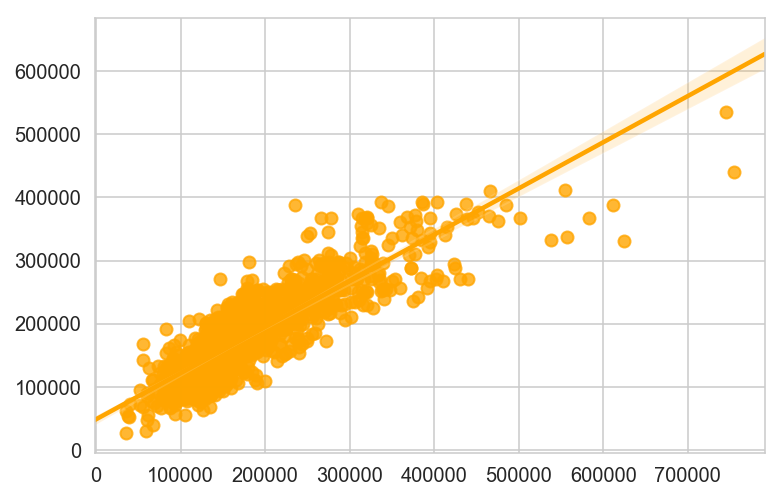

In [1401]:
sgd_best = SGDRegressor(loss=sgd_reg_gs.best_params_['loss'], penalty=sgd_reg_gs.best_params_['penalty'], alpha=sgd_reg_gs.best_params_['alpha'])
sgd_best.fit(Xs,y)

yy_pred = sgd_best.predict(Xs)
plt.figure()
sns.regplot(y, yy_pred, color='orange')

RMSE = np.sqrt(np.mean((y-yy_pred)/np.mean(y))**2)
print('RMSE = {:.4f}'.format(RMSE))
r,p = stats.pearsonr(y, yy_pred)
print('r2 = {:.4f}'.format(r**2))
print('p = {:.4f}'.format(p))

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
#https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/
#http://localhost:8888/notebooks/Desktop/generalassembly/Unit-4-Restructured/03.Trees_and_Ensamble/dsi-unit-4.03-ensemble-intro_to_ensembles_bagging-lesson/solution-code/esamblecodealongsrikanta...ipynb#

In [37]:
residential = house[house.MSZoning.isin(['RL', 'RM', 'RH'])]
residential.SaleCondition.value_counts()

Normal     1155
Partial     101
Abnorml      92
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [38]:
#new dataframe 
classification_convert=residential.apply(LabelEncoder().fit_transform) 

classification_dummies = pd.get_dummies(residential)

In [39]:
classification_convert.SaleCondition.value_counts()/1155*100

4    100.000000
5      8.744589
0      7.965368
3      1.731602
2      0.952381
1      0.346320
Name: SaleCondition, dtype: float64

In [40]:
#https://elitedatascience.com/imbalanced-classes
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Separate input features (X) and target variable (y)
X=classification_convert.drop(['SaleCondition'], axis=1)
y= classification_convert.loc[:,'SaleCondition']

In [41]:
# Train model
clf_0 = LogisticRegression().fit(X, y)
# Predict on training set
pred_y_0 = clf_0.predict(X)

# How's the accuracy?
print( accuracy_score(pred_y_0, y) )

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9096167751265365


In [42]:
print( np.unique( pred_y_0 ) )

[0 1 2 3 4 5]


### Up-sample Minority Class

In [43]:
from sklearn.utils import resample

In [44]:
Normal = classification_convert[classification_convert.SaleCondition==4]
Partial = classification_convert[classification_convert.SaleCondition==5]
Abnorml = classification_convert[classification_convert.SaleCondition==0]
Family = classification_convert[classification_convert.SaleCondition==3]
Alloca = classification_convert[classification_convert.SaleCondition==2]
AdjLand = classification_convert[classification_convert.SaleCondition==1]

In [45]:
# Upsample minority class
Abnorml_upsampled = resample(Abnorml, 
                                 replace=True,     # sample with replacement
                                 n_samples=1155,    # to match majority class
                                 random_state=48) # reproducible results
Family_upsampled = resample(Family, 
                                 replace=True,     # sample with replacement
                                 n_samples=1155,    # to match majority class
                                 random_state=48) # reproducible results
Alloca_upsampled = resample(Alloca, 
                                 replace=True,     # sample with replacement
                                 n_samples=1155,    # to match majority class
                                 random_state=48) # reproducible results
AdjLand_upsampled = resample(AdjLand, 
                                 replace=True,     # sample with replacement
                                 n_samples=1155,    # to match majority class
                                 random_state=48) # reproducible results
Partial_upsampled = resample(Partial, 
                                 replace=True,     # sample with replacement
                                 n_samples=1155,    # to match majority class
                                 random_state=48) # reproducible results

In [46]:
upsampled = pd.concat([Normal,Abnorml_upsampled,Family_upsampled, Alloca_upsampled, AdjLand_upsampled, Partial_upsampled])

In [47]:
upsampled.SaleCondition.value_counts()

3    1155
2    1155
5    1155
1    1155
4    1155
0    1155
Name: SaleCondition, dtype: int64

In [48]:
# Separate input features (X) and target variable (y)
y = upsampled.SaleCondition
X = upsampled.drop('SaleCondition', axis=1)
 
# Train model
clf_1 = LogisticRegression().fit(X, y)
 
# Predict on training set
pred_y_1 = clf_1.predict(X)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_1 ) )

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[0 1 2 3 4 5]


In [49]:
# How's our accuracy?
print( accuracy_score(y, pred_y_1) )

0.884992784992785


In [50]:
# Upsample minority class
Normal_downsampled = resample(Normal, 
                                 replace=True,     # sample with replacement
                                 n_samples=488,    # to match majority class
                                 random_state=48) # reproducible results
Abnorml_downsampled = resample(Abnorml, 
                                 replace=True,     # sample with replacement
                                 n_samples=488,    # to match majority class
                                 random_state=48) # reproducible results
Family_downsampled = resample(Family, 
                                 replace=True,     # sample with replacement
                                 n_samples=488,    # to match majority class
                                 random_state=48) # reproducible results
Alloca_downsampled = resample(Alloca, 
                                 replace=True,     # sample with replacement
                                 n_samples=488,    # to match majority class
                                 random_state=48) # reproducible results
AdjLand_downsampled = resample(AdjLand, 
                                 replace=True,     # sample with replacement
                                 n_samples=488,    # to match majority class
                                 random_state=48) # reproducible results
Partial_downsampled = resample(Partial, 
                                 replace=True,     # sample with replacement
                                 n_samples=488,    # to match majority class
                                 random_state=48) # reproducible results

In [51]:
downsampled = pd.concat([Normal_downsampled,Abnorml_downsampled,Family_downsampled, Alloca_downsampled, AdjLand_downsampled, Partial_downsampled])

In [52]:
downsampled.SaleCondition.value_counts()

5    488
3    488
1    488
4    488
2    488
0    488
Name: SaleCondition, dtype: int64

In [53]:
# Separate input features (X) and target variable (y)
y = downsampled.SaleCondition
X = downsampled.drop('SaleCondition', axis=1)
 
# Train model
clf_2 = LogisticRegression().fit(X, y)
 
# Predict on training set
pred_y_2 = clf_2.predict(X)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_2 ) )

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[0 1 2 3 4 5]


In [54]:
# How's our accuracy?
print( accuracy_score(y, pred_y_2) )

0.875


### For a general-purpose metric for classification, we recommend Area Under ROC Curve (AUROC).

In [55]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [56]:
# Predict class probabilities
prob_y_2 = clf_2.predict_proba(X)
# Keep only the positive class
prob_y_2 = [p[1] for p in prob_y_2]
prob_y_2[:5]

[6.811108610685123e-112,
 9.251154431937382e-14,
 1.1918457666001244e-70,
 6.249574478488568e-194,
 6.506227746814457e-47]

In [57]:
#use upsampled

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
y = upsampled.SaleCondition
X = upsampled.drop('SaleCondition', axis=1)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
ss = StandardScaler()
Xs = ss.fit_transform(X)

all_sample = upsampled.copy()
all_sample_a = ss.fit_transform(all_sample)
in_y=ss.inverse_transform(all_sample_a)

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [59]:
#Train multinomial logistic regression
#http://dataaspirant.com/2017/05/15/implement-multinomial-logistic-regression-python/
#https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f


X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33)

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_predlr = lr.predict(X_test)

mul_lr = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, y_train)
mul_lr.fit(X_train, y_train)
y_predmul_lr = mul_lr.predict(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_predknn = knn.predict(X_test)

bc=BaggingClassifier(random_state=48)
bc.fit(X_train, y_train)
y_predbc = bc.predict(X_test)

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [60]:
print ("Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, lr.predict(X_train)))
print ("Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, lr.predict(X_test)))
print ("  ")   
print ("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, mul_lr.predict(X_train)))
print ( "Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))
print ("  ") 
print ( "knn classification Train Accuracy :: ", metrics.accuracy_score(y_train, knn.predict(X_train)))
print ( "knn classification Test Accuracy :: ", metrics.accuracy_score(y_test, knn.predict(X_test)))
print ("  ") 
print ( "BaggingClassifier classification Train Accuracy :: ", metrics.accuracy_score(y_train, bc.predict(X_train)))
print ( "BaggingClassifier classification Test Accuracy :: ", metrics.accuracy_score(y_test, bc.predict(X_test)))

Logistic regression Train Accuracy ::  0.8892957139780314
Logistic regression Test Accuracy ::  0.8740708351552252
  
Multinomial Logistic regression Train Accuracy ::  0.902649149256946
Multinomial Logistic regression Test Accuracy ::  0.8911237428946218
  
knn classification Train Accuracy ::  0.9448632349773853
knn classification Test Accuracy ::  0.9243550502842152
  
BaggingClassifier classification Train Accuracy ::  0.9993538660348912
BaggingClassifier classification Test Accuracy ::  0.9794490599038042


In [61]:
features=downsampled.drop('SaleCondition', axis=1)
labels= downsampled.SaleCondition
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=48),
    KNeighborsClassifier(),
    BaggingClassifier(random_state=48),
    RandomForestClassifier(random_state=48),
    ExtraTreesClassifier(),
    DecisionTreeClassifier()]

In [62]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
 

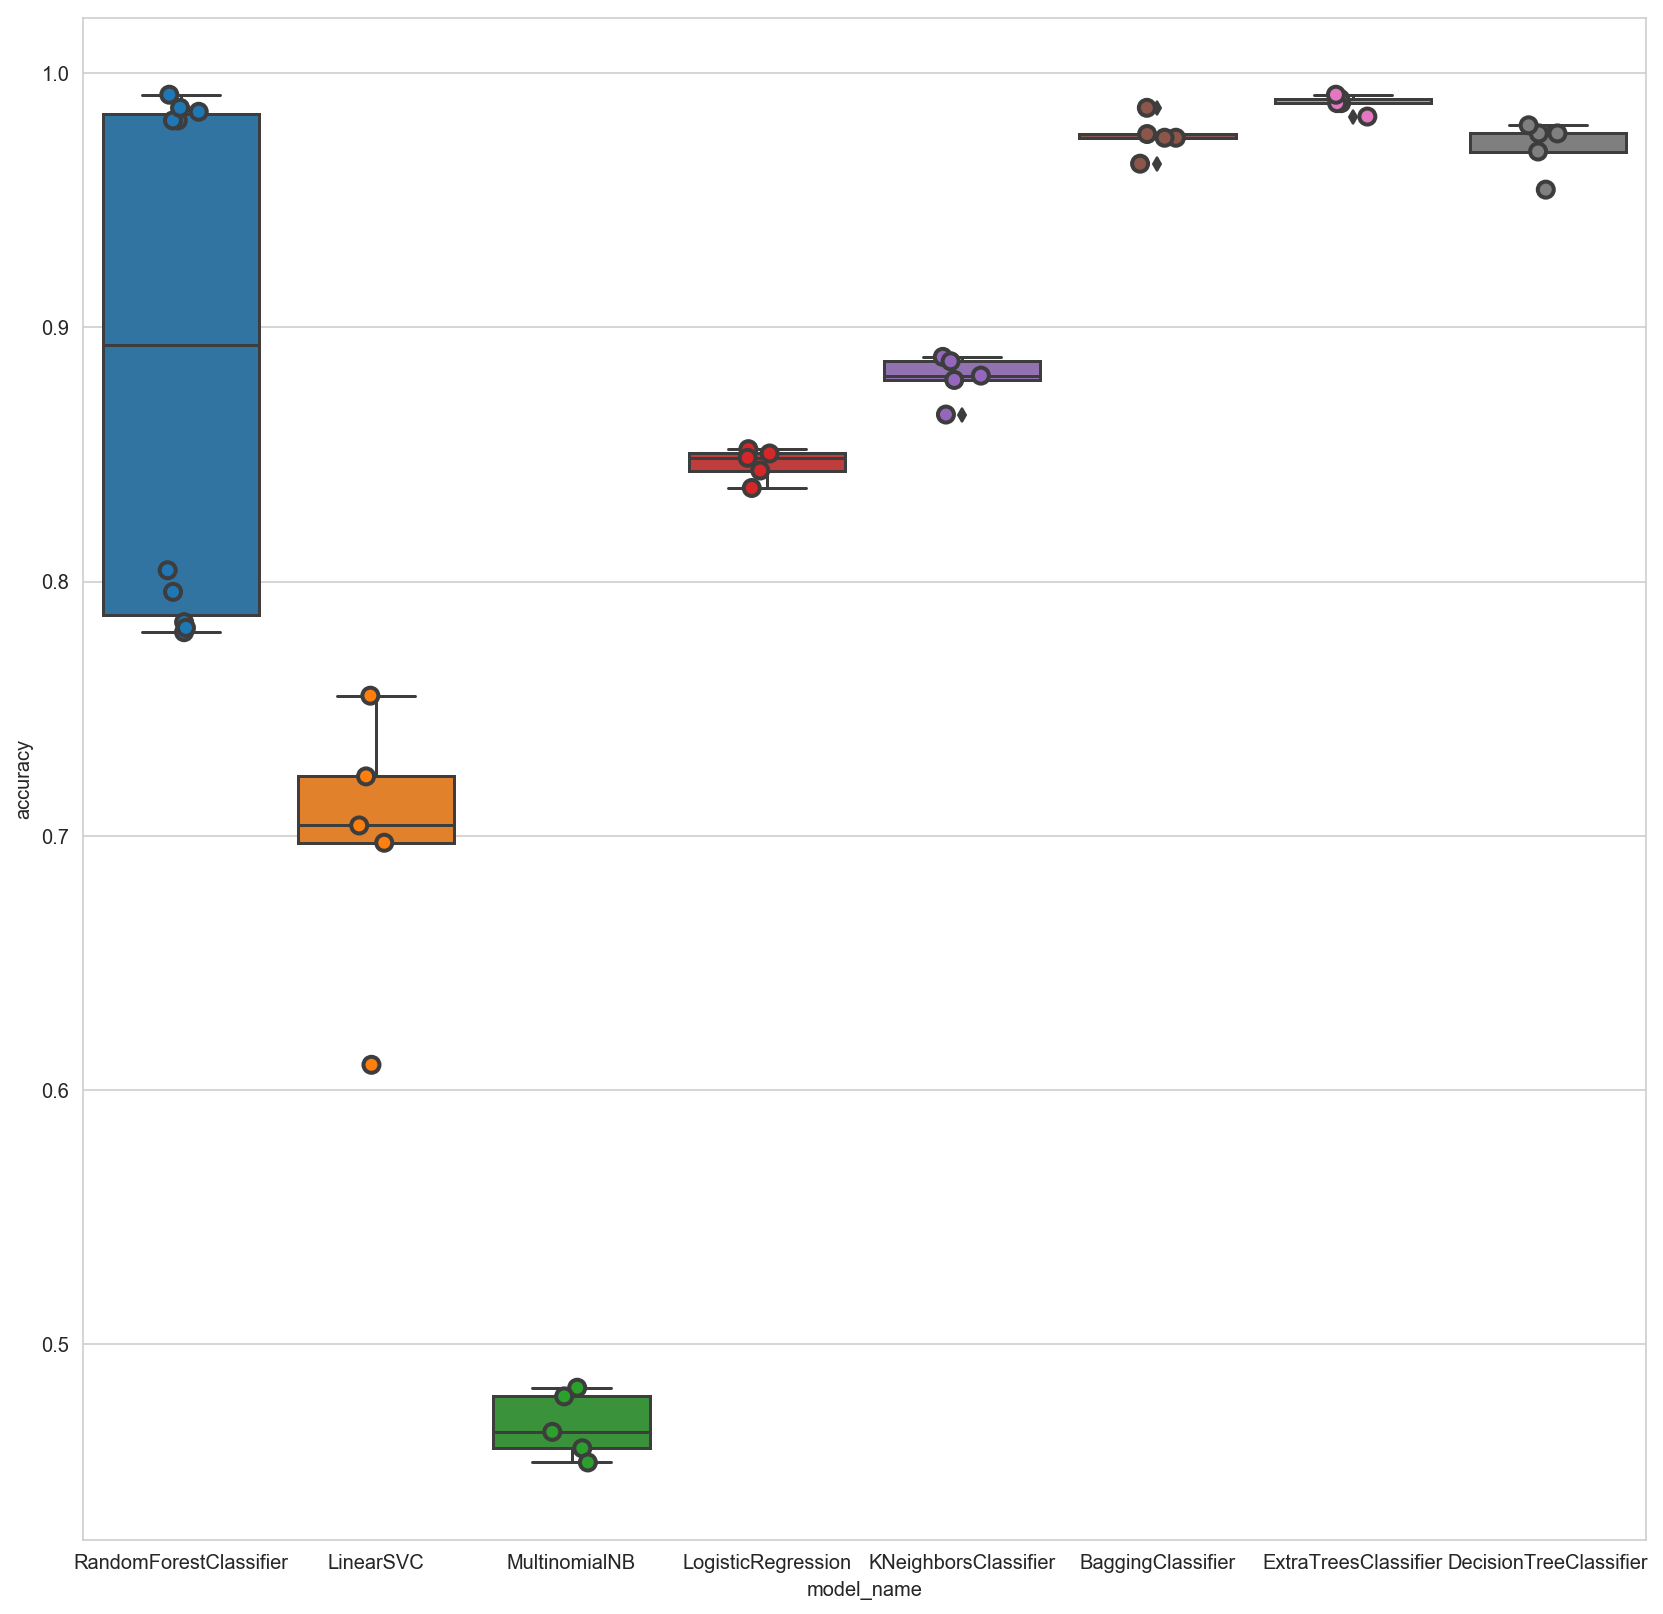

In [63]:
import seaborn as sns
plt.figure(figsize=[14,14])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [64]:
cv_df.groupby('model_name').accuracy.mean()

model_name
BaggingClassifier         0.975093
DecisionTreeClassifier    0.970983
ExtraTreesClassifier      0.988043
KNeighborsClassifier      0.880153
LinearSVC                 0.697959
LogisticRegression        0.846287
MultinomialNB             0.468203
RandomForestClassifier    0.887115
Name: accuracy, dtype: float64

In [69]:
model = RandomForestClassifier()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, downsampled.index,test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [70]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=residential.SaleCondition.unique()))

              precision    recall  f1-score   support

      Normal       0.92      0.99      0.95       178
     Abnorml       1.00      1.00      1.00       154
     Partial       1.00      1.00      1.00       145
     AdjLand       0.99      1.00      1.00       166
      Alloca       0.99      0.89      0.94       157
      Family       1.00      1.00      1.00       167

   micro avg       0.98      0.98      0.98       967
   macro avg       0.98      0.98      0.98       967
weighted avg       0.98      0.98      0.98       967



Accuracy is:  0.9782833505687694


/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


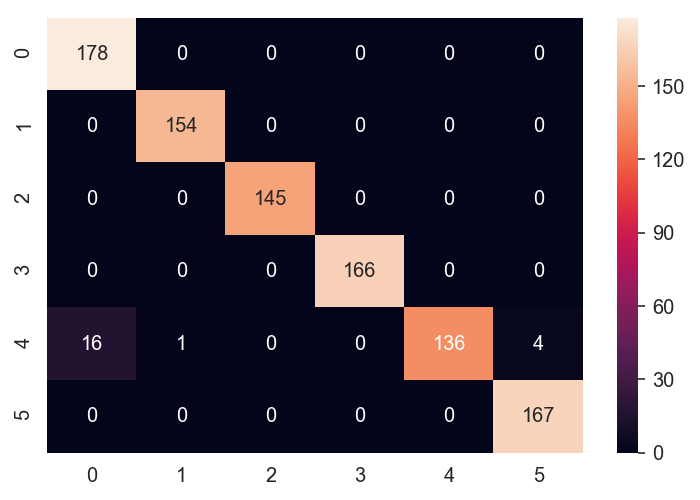

In [71]:
#RandomForestClassifier
lr = RandomForestClassifier(random_state=48)      
lr = lr.fit(X_train,y_train)

ac = accuracy_score(y_test,lr.predict(X_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,lr.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d")

In [68]:
c= upsampled.corr().abs()#.sort_values('SalePrice', ascending = True)
c.sort_values('SaleCondition',ascending = False)
choosen_corr = c[c['SaleCondition'] > 0.40]
choosen_corr['SaleCondition']

OverallQual      0.460718
YearBuilt        0.471114
YearRemodAdd     0.463053
ExterQual        0.468921
BsmtQual         0.402022
HeatingQC        0.425760
GarageYrBlt      0.488471
GarageCars       0.463168
GarageArea       0.461521
SaleCondition    1.000000
SalePrice        0.502025
Name: SaleCondition, dtype: float64

In [ ]:
#run feature selection
#http://localhost:8888/notebooks/Desktop/generalassembly/Unit-3-Restructured/02_Classification/dsi-unit-3.18-evaluation-classifiers_confusion_matrix_roc-lesson/solution-code/evaluating-classifiers-confusion-matrix-solutions.ipynb
#try
#http://localhost:8888/notebooks/Desktop/Unit-3-Restructured/03_Optimization/dsi-unit-3.21-optimization-feature_selection-lab/solution-code/feature-selection-lab-solutions.ipynb